In [1]:
#Used for displaying plots below the cell, inverts %matplotlib inline
%matplotlib inline
import math
import random
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sn
import itertools
import dalex as dx

#Pre-processing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn import base
from category_encoders import OneHotEncoder, OrdinalEncoder

from sklearn.cluster import AgglomerativeClustering

#Models
from sklearn import linear_model
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from wittgenstein import RIPPER
from sklearn.neural_network import MLPClassifier

#Model selection
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score, learning_curve, ShuffleSplit, train_test_split
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, plot_confusion_matrix, \
    classification_report, plot_roc_curve, confusion_matrix

#visualize the decision tree obtained 
import pydotplus 
from IPython.display import Image

from imblearn.over_sampling import SMOTE, ADASYN, SMOTENC

import matplotlib.gridspec as gridspec
from mlxtend.plotting import plot_decision_regions

In [2]:
vendor_df_num = pd.read_csv('./task1-result_num_wo_out.csv', sep=',', index_col=[0,1])
vendor_df_cat = pd.read_csv('./task1-result_cat_wo_out.csv', sep=',', index_col=[0,1])

#Used for retrieving the outliers from task 1
vendor_df_num_w_out = pd.read_csv('./task1-result_num_w_out.csv', sep=',', index_col=[0,1])
vendor_df_cat_w_out = pd.read_csv('./task1-result_cat_w_out.csv', sep=',', index_col=[0,1])

## Categorical features binarisation
Sklearns models require us to have only numerical features in our dataset, therefore we need to binarise the categorical features.

In [3]:
vendor_df_cat.head()

TopBrand                TopCountry  \
vendor_code name                                                       
1           1stWave Technologies   CORSAIR                New Zeland   
2           Adorama                CRUCIAL  United States of America   
3           Alternate              G.SKILL                    France   
4           Alternate Italia       G.SKILL                     Italy   
5           Alza                  KINGSTON            United Kingdom   

                                 TopCurrency  TopSalesMonth  
vendor_code name                                             
1           1stWave Technologies         NZD             11  
2           Adorama                      USD              4  
3           Alternate                    EUR              3  
4           Alternate Italia             EUR              3  
5           Alza                         GBP             12

Of these features only TopSalesMonth has a natural ordering (the numer of the month from 1 to 12), however this order is not really meaningful in this context because there is no apparent benefit in having as TopSalesMonth value a month that is greater in number.  
Therefore we will use a one-hot encoding dropping.  

Note that for the encoding we will consider only the values present in the vendor dataset, which isn't the complete list, however this seems the only practical solution given that otherwise the number of features surpasses the number of datapoints available.  

In [4]:
cat_features_one_enc = \
    OneHotEncoder(cols=["TopBrand", "TopCountry", "TopCurrency", "TopSalesMonth"], use_cat_names=True).fit(vendor_df_cat_w_out)

vendor_df_cat_discr = cat_features_one_enc.transform(vendor_df_cat)
vendor_df_cat_discr_w_out = cat_features_one_enc.transform(vendor_df_cat_w_out)

/home/avenger/.local/lib/python3.9/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


### Result

In [5]:
vendor_df_cat_discr.head()

TopBrand_CORSAIR  TopBrand_CRUCIAL  \
vendor_code name                                                       
1           1stWave Technologies                 1                 0   
2           Adorama                              0                 1   
3           Alternate                            0                 0   
4           Alternate Italia                     0                 0   
5           Alza                                 0                 0   

                                  TopBrand_G.SKILL  TopBrand_KINGSTON  \
vendor_code name                                                        
1           1stWave Technologies                 0                  0   
2           Adorama                              0                  0   
3           Alternate                            1                  0   
4           Alternate Italia                     1                  0   
5           Alza                                 0                  1   

                                  TopBrand_VISIONTEK  TopCountry_New Zeland  \
vendor_code name                                                              
1           1stWave Technologies                   0                      1   
2           Adorama                                0                      0   
3           Alternate                              0                      0   
4           Alternate Italia                       0                      0   
5           Alza                                   0                      0   

                                  TopCountry_United States of America  \
vendor_code name                                                        
1           1stWave Technologies                                    0   
2           Adorama                                                 1   
3           Alternate                                               0   
4           Alternate Italia                                        0   
5           Alza                                                    0   

                                  TopCountry_France  TopCountry_Italy  \
vendor_code name                                                        
1           1stWave Technologies                  0                 0   
2           Adorama                               0                 0   
3           Alternate                             1                 0   
4           Alternate Italia                      0                 1   
5           Alza                                  0                 0   

                                  TopCountry_United Kingdom  ...  \
vendor_code name                                             ...   
1           1stWave Technologies                          0  ...   
2           Adorama                                       0  ...   
3           Alternate                                     0  ...   
4           Alternate Italia                              0  ...   
5           Alza                                          1  ...   

                                  TopSalesMonth_3.0  TopSalesMonth_12.0  \
vendor_code name                                                          
1           1stWave Technologies                  0                   0   
2           Adorama                               0                   0   
3           Alternate                             1                   0   
4           Alternate Italia                      1                   0   
5           Alza                                  0                   1   

                                  TopSalesMonth_8.0  TopSalesMonth_1.0  \
vendor_code name                                                         
1           1stWave Technologies                  0                  0   
2           Adorama                               0                  0   
3           Alternate                             0                  0   
4           Alternate Italia                      0               

We can see that we have 30 features in total.

## Define big-seller/small-seller label

### Normalisation
In order to conduct the analysis we use a minmax normalisation in order to keep the features easily interpretable.

In [6]:
vend_scaler = MinMaxScaler()
vend_scaler.fit(vendor_df_num.values)
vendor_norm = vend_scaler.transform(vendor_df_num.values)
vendor_df_norm = pd.DataFrame(vendor_norm, columns=vendor_df_num.columns, index=vendor_df_num.index)

### Analysis

In [7]:
vendor_df_num.head()

I   Iu  MaxValuePerOrder  \
vendor_code name                                                 
1           1stWave Technologies    774   60        565.439098   
2           Adorama                3274  186       1761.990000   
3           Alternate              3047  203        860.154236   
4           Alternate Italia        407  101        774.077840   
5           Alza                  12959  276       1188.115658   

                                  AvgValuePerOrder  AvgMemoryPerOrder  \
vendor_code name                                                        
1           1stWave Technologies        132.989886          13.074935   
2           Adorama                     146.248003          14.628894   
3           Alternate                   155.134195          11.530030   
4           Alternate Italia            142.140184          10.034398   
5           Alza                        166.036705          13.514777   

                                  IAvgMonthSales  TotMonthBusiness      Eram  \
vendor_code name                                                               
1           1stWave Technologies     4117.366865                25  5.361843   
2           Adorama                 23940.798168                20  6.754711   
3           Alternate              157564.631150                 3  7.373634   
4           Alternate Italia        28925.527422                 2  6.486558   
5           Alza                   126568.803904                17  7.612859   

                                      Egeo      Ecur  
vendor_code name                                      
1           1stWave Technologies  0.643988  0.643988  
2           Adorama               0.000000  0.000000  
3           Alternate             1.679995  0.000000  
4           Alternate Italia      0.898296  0.898296  
5           Alza                  1.165894  1.094659

What defines a seller as big?  
We will take inspiration from the clustering results and define the **big-seller/small-seller** labels by using the **I/IAvgMonthSales** features.  

In [8]:
clust_labels = AgglomerativeClustering(n_clusters=2, linkage="average").fit(vendor_norm).labels_
clust_labels_df = vendor_df_num.copy()
clust_labels_df.loc[:, "Label"] = -1

for i in range(len(clust_labels)):
    
    if clust_labels[i] == 0:
        clust_labels_df.iloc[i, -1] = "small-seller"
    else:
        clust_labels_df.iloc[i, -1] = "big-seller"

In [9]:
clust_labels_df.loc[clust_labels_df["Label"] == "small-seller"].max()

I                            27633
Iu                             680
MaxValuePerOrder       3195.875774
AvgValuePerOrder        499.458429
AvgMemoryPerOrder        30.890521
IAvgMonthSales       354101.045624
TotMonthBusiness                25
Eram                      9.006487
Egeo                      1.679995
Ecur                      1.522173
Label                 small-seller
dtype: object

In [10]:
clust_labels_df.loc[clust_labels_df["Label"] == "big-seller"].min()

I                            39137
Iu                             393
MaxValuePerOrder       1839.953682
AvgValuePerOrder        152.947845
AvgMemoryPerOrder        14.982037
IAvgMonthSales       284764.654091
TotMonthBusiness                23
Eram                      7.960206
Egeo                           0.0
Ecur                           0.0
Label                   big-seller
dtype: object

Unfortunately, if we were to perfectly adhere to the clustering results, the number of samples in the **big-seller** label is too low to perform any meaningful predictive analysis.  
We will therefore expand the meaning of **big-seller**, currently dominated by the **I** feature (note the min and max of **I** for each label), to also include entries that have a relatively low **I** but a high **IAvgSalesMonth** value.

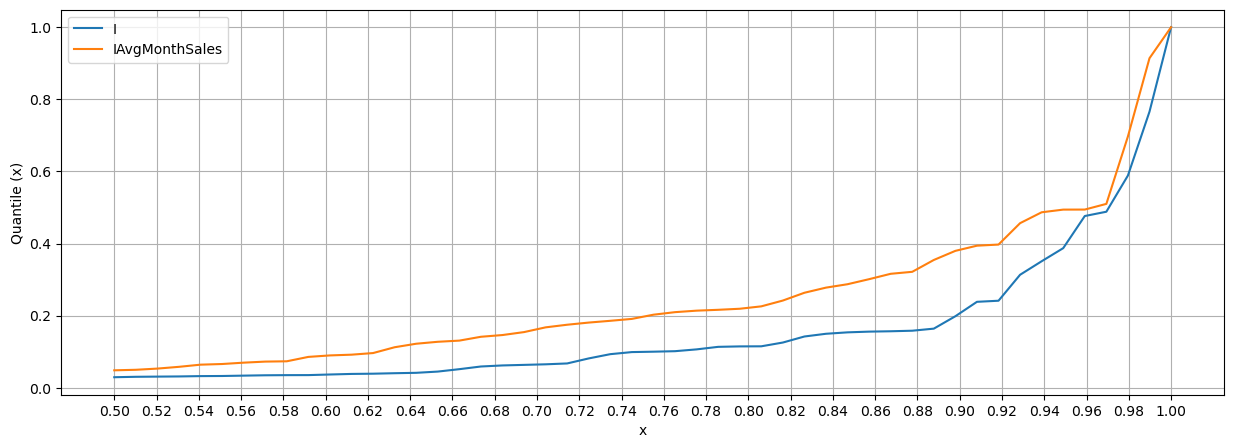

In [11]:
key_features = ["I", "IAvgMonthSales"]
pred_label_df = vendor_df_norm.copy()

pred_label_df[key_features].quantile(np.linspace(0.5, 1, 50)).plot(figsize=(15,5), grid=True)
plt.xlabel("x")
plt.ylabel("Quantile (x)")
plt.xticks(np.arange(0.5, 1.02, 0.02))
plt.show()

### Label assignment

In [12]:
pred_label_df["Label"] = "small-seller"

pred_label_df.loc[pred_label_df["I"] >= pred_label_df["I"].quantile(0.80), "Label"] = "big-seller"
pred_label_df.loc[pred_label_df["IAvgMonthSales"] >= pred_label_df["IAvgMonthSales"].quantile(0.90), "Label"] = "big-seller"

pred_label_df.groupby("Label").size()

Label
big-seller      16
small-seller    59
dtype: int64

We decide to go with:
- big-seller: any entry having **I** >= quantile(0.8) or **IAvgMonthSales** >= quantile(0.8) of the whole dataset
- small-seller: everything else

We decided to go for this definition based on the plot above, in which the values of these features start to take off (forming a knee) around that value.  
This definition doubles the amount of data points that we have to work with when it comes to the **big-seller** label.

In [13]:
small_seller_df_norm = pred_label_df.loc[pred_label_df["Label"] == "small-seller"]
small_seller_df_norm.describe()

I         Iu  MaxValuePerOrder  AvgValuePerOrder  \
count  59.000000  59.000000         59.000000         59.000000   
mean    0.027195   0.112363          0.160053          0.264247   
std     0.028808   0.096034          0.121216          0.222967   
min     0.000000   0.000000          0.000000          0.000000   
25%     0.005920   0.036977          0.063853          0.122839   
50%     0.018712   0.088424          0.124713          0.172221   
75%     0.035073   0.165997          0.259288          0.347845   
max     0.113253   0.543408          0.492266          1.000000   

       AvgMemoryPerOrder  IAvgMonthSales  TotMonthBusiness       Eram  \
count          59.000000       59.000000         59.000000  59.000000   
mean            0.361157        0.068316          0.595339   0.518504   
std             0.211379        0.085802          0.380786   0.205527   
min             0.000000        0.000000          0.000000   0.000000   
25%             0.209956        0.012075          0.208333   0.416818   
50%             0.320440        0.038242          0.666667   0.566039   
75%             0.476771        0.080837          1.000000   0.672809   
max             1.000000        0.368735          1.000000   0.899448   

            Egeo       Ecur  
count  59.000000  59.000000  
mean    0.292167   0.259680  
std     0.204815   0.218184  
min     0.000000   0.000000  
25%     0.192710   0.000000  
50%     0.328149   0.300021  
75%     0.368002   0.394126  
max     1.000000   1.000000

In [14]:
big_seller_df_norm = pred_label_df.loc[pred_label_df["Label"] == "big-seller"]
big_seller_df_norm.describe()

I         Iu  MaxValuePerOrder  AvgValuePerOrder  \
count  16.000000  16.000000         16.000000         16.000000   
mean    0.312479   0.408762          0.336851          0.248761   
std     0.247203   0.257505          0.242397          0.120629   
min     0.114889   0.165595          0.153306          0.127989   
25%     0.154051   0.225683          0.164017          0.179757   
50%     0.202028   0.303457          0.291883          0.211621   
75%     0.390255   0.481310          0.324304          0.292474   
max     1.000000   1.000000          1.000000          0.639707   

       AvgMemoryPerOrder  IAvgMonthSales  TotMonthBusiness       Eram  \
count          16.000000       16.000000         16.000000  16.000000   
mean            0.431251        0.397517          0.882812   0.782936   
std             0.095910        0.251342          0.180161   0.117875   
min             0.308643        0.129627          0.500000   0.644442   
25%             0.362183        0.210666          0.864583   0.682351   
50%             0.405553        0.357635          1.000000   0.759081   
75%             0.503459        0.494118          1.000000   0.892422   
max             0.607392        1.000000          1.000000   1.000000   

            Egeo       Ecur  
count  16.000000  16.000000  
mean    0.299745   0.303996  
std     0.127232   0.160005  
min     0.000000   0.000000  
25%     0.264957   0.291278  
50%     0.351979   0.385131  
75%     0.386953   0.426001  
max     0.390736   0.431248

### Feature correlations

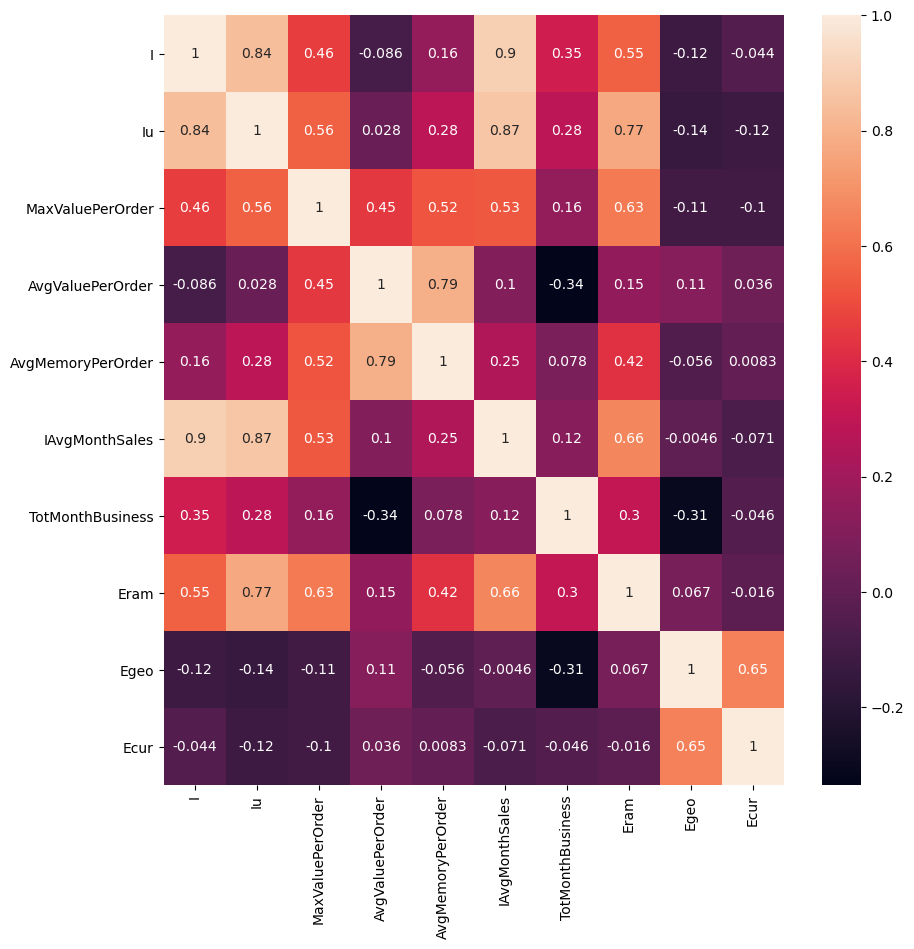

In [15]:
plt.figure(figsize=(10,10))
sn.heatmap(vendor_df_num.corr(), annot=True)
plt.show()

## Dataset preparation

### Merge all features in a single dataset

In [16]:
vendor_df = pd.concat([vendor_df_num, vendor_df_cat_discr], axis=1)
vendor_df_w_out = pd.concat([vendor_df_num_w_out, vendor_df_cat_discr_w_out], axis=1)

### Add outliers  

In [17]:
outlier_df = vendor_df_w_out.loc[~vendor_df_w_out.index.isin(vendor_df.index)]
outlier_df

I    Iu  MaxValuePerOrder  \
vendor_code name                                                
32          geizhals_unknown  2020083  1733      10630.741494   
43          Mindfactory        248228   774       6044.234544   
68          pricespy_unknown   318591  1659       4465.589602   

                              AvgValuePerOrder  AvgMemoryPerOrder  \
vendor_code name                                                    
32          geizhals_unknown        164.006403          14.541547   
43          Mindfactory             207.345263          19.361700   
68          pricespy_unknown        220.574502          20.171635   

                              IAvgMonthSales  TotMonthBusiness       Eram  \
vendor_code name                                                            
32          geizhals_unknown    5.343654e+06                62  10.512789   
43          Mindfactory         2.058756e+06                25   9.189418   
68          pricespy_unknown    1.849291e+06                38  10.118133   

                                  Egeo      Ecur  ...  TopSalesMonth_3.0  \
vendor_code name                                  ...                      
32          geizhals_unknown  0.337642  0.000000  ...                  1   
43          Mindfactory       0.334336  0.000000  ...                  0   
68          pricespy_unknown  0.441207  0.441207  ...                  1   

                              TopSalesMonth_12.0  TopSalesMonth_8.0  \
vendor_code name                                                      
32          geizhals_unknown                   0                  0   
43          Mindfactory                        0                  0   
68          pricespy_unknown                   0                  0   

                              TopSalesMonth_1.0  TopSalesMonth_7.0  \
vendor_code name                                                     
32          geizhals_unknown                  0                  0   
43          Mindfactory                       1                  0   
68          pricespy_unknown                  0                  0   

                              TopSalesMonth_10.0  TopSalesMonth_2.0  \
vendor_code name                                                      
32          geizhals_unknown                   0                  0   
43          Mindfactory                        0                  0   
68          pricespy_unknown                   0                  0   

                              TopSalesMonth_9.0  TopSalesMonth_6.0  \
vendor_code name                                                     
32          geizhals_unknown                  0                  0   
43          Mindfactory                       0                  0   
68          pricespy_unknown                  0                  0   

                              TopSalesMonth_5.0  
vendor_code name                                 
32          geizhals_unknown                  0  
43          Mindfactory                       0  
68          pricespy_unknown                  0  

[3 rows x 44 columns]

We already know from our analysis that the outliers from Task 1 present extreme values in the **I/IAvgSalesMonth** features, therefore it seems only natural to include them as **big-sellers**.

In [18]:
labeled_df_w_out = vendor_df_w_out.copy()

#big-seller labels
labeled_df_w_out.loc[big_seller_df_norm.index, "Label"] = "big-seller"
labeled_df_w_out.loc[outlier_df.index, "Label"] = "big-seller"

#small-seller labels
labeled_df_w_out.loc[small_seller_df_norm.index, "Label"] = "small-seller"

### Removal of features used to define labels

In [19]:
pred_df = labeled_df_w_out.drop(["I", "IAvgMonthSales", "Iu"], axis=1)
labels = pred_df.pop('Label')

Apart from the labels used above we also removed **Iu** since it is strongly correlated with the features removed and has a big impact on the different models.

### Standardisation
We choose to use a StandardScaler instead of a MinMaxScaler given its better handling of outliers and because the focus of this task is not the direct interpretability of the values as it was the case during clustering.

In [20]:
pred_scaler = StandardScaler()
pred_norm = pred_scaler.fit_transform(pred_df.values)
pred_df_norm = pd.DataFrame(pred_norm, columns=pred_df.columns, index=pred_df.index)

pred_df_norm.head()

MaxValuePerOrder  AvgValuePerOrder  \
vendor_code name                                                       
1           1stWave Technologies         -0.676333         -0.729306   
2           Adorama                       0.090633         -0.569198   
3           Alternate                    -0.487426         -0.461887   
4           Alternate Italia             -0.542600         -0.618805   
5           Alza                         -0.277209         -0.330226   

                                  AvgMemoryPerOrder  TotMonthBusiness  \
vendor_code name                                                        
1           1stWave Technologies          -0.648874          0.709453   
2           Adorama                       -0.308858          0.222328   
3           Alternate                     -0.986908         -1.433894   
4           Alternate Italia              -1.314161         -1.531318   
5           Alza                          -0.552633         -0.069946   

                                      Eram      Egeo      Ecur  \
vendor_code name                                                 
1           1stWave Technologies -0.683483  0.496859  0.779285   
2           Adorama               0.088941 -1.565545 -1.273951   
3           Alternate             0.432169  3.814725 -1.273951   
4           Alternate Italia     -0.059765  1.311293  1.590099   
5           Alza                  0.564833  2.168290  2.216167   

                                  TopBrand_CORSAIR  TopBrand_CRUCIAL  \
vendor_code name                                                       
1           1stWave Technologies          1.374369         -0.313993   
2           Adorama                      -0.727607          3.184785   
3           Alternate                    -0.727607         -0.313993   
4           Alternate Italia             -0.727607         -0.313993   
5           Alza                         -0.727607         -0.313993   

                                  TopBrand_G.SKILL  ...  TopSalesMonth_3.0  \
vendor_code name                                    ...                      
1           1stWave Technologies         -0.606977  ...          -0.508001   
2           Adorama                      -0.606977  ...          -0.508001   
3           Alternate                     1.647509  ...           1.968502   
4           Alternate Italia              1.647509  ...           1.968502   
5           Alza                         -0.606977  ...          -0.508001   

                                  TopSalesMonth_12.0  TopSalesMonth_8.0  \
vendor_code name                                                          
1           1stWave Technologies           -0.261712          -0.232495   
2           Adorama                        -0.261712          -0.232495   
3           Alternate                      -0.261712          -0.232495   
4           Alternate Italia               -0.261712          -0.232495   
5           Alza                            3.820995          -0.232495   

                                  TopSalesMonth_1.0  TopSalesMonth_7.0  \
vendor_code name                                                         
1           1stWave Technologies          -0.361158          -0.261712   
2           Adorama                       -0.361158          -0.261712   
3           Alternate                     -0.361158          -0.261712   
4           Alternate Italia              -0.361158          -0.261712   
5           Alza                          -0.361158          -0.261712   

                                  TopSalesMonth_10.0  TopSalesMonth_2.0  \
vendor_code name                                                          
1           1stWave Technologies           -0.361158          -0.313993   
2           Adorama                        -0.361158          -0.313993   
3           Alternate                      -0.361158          -0.313993   
4           Alternate Italia               -0.361158          -0.313993   
5      

### Train/test split

As suggested in the literature we use a 70-30 split for training/test set.

In [21]:
#Normalised data
train_set, test_set, train_label, test_label = train_test_split(pred_df_norm, labels, stratify=labels, test_size=0.3, random_state=0)

print(f"Train set size (unbalanced): {len(train_set)}")
print(f"Test set size (unbalanced): {len(test_set)}")

Train set size (unbalanced): 54
Test set size (unbalanced): 24


### Class balancing  
Some of the functions provided by sklearn do not allow for a weighting of the classification scores based on the support of the class, therefore we need to prepare a balanced dataset.  
In order to avoid having the model overfit by simply memorising the repeated datapoints, we will therefore generate new data using SMOTE.  

We performed some preliminary testing with SMOTE, SMOTENC and ADASYN.
The last one performed the best, in particular it generates the least skewed distribution in the categorical features.

In [22]:
ros = ADASYN(random_state=0)

train_set_bal, train_label_bal = ros.fit_resample(train_set, train_label)

print(f"Train set size (balanced): {len(train_set_bal)}")

Train set size (balanced): 81


In [23]:
train_set_bal.head()

MaxValuePerOrder  AvgValuePerOrder  AvgMemoryPerOrder  TotMonthBusiness  \
0         -0.633091         -0.182374          -0.921036         -1.433894   
1         -0.697376         -0.865604          -0.657033          0.709453   
2          0.326020         -0.194194           0.118427          0.514603   
3         -0.178579         -0.595195          -0.191965          0.709453   
4          0.394711          0.753632           0.875033         -0.459645   

       Eram      Egeo      Ecur  TopBrand_CORSAIR  TopBrand_CRUCIAL  \
0 -0.601679  0.581846  0.863894         -0.727607         -0.313993   
1 -0.449730  0.348668  0.631754          1.374369         -0.313993   
2  0.546295 -0.138829  0.146423         -0.727607         -0.313993   
3  0.307058 -1.565545 -1.273951         -0.727607         -0.313993   
4  0.590120  0.486973 -1.273951         -0.727607         -0.313993   

   TopBrand_G.SKILL  ...  TopSalesMonth_3.0  TopSalesMonth_12.0  \
0          1.647509  ...          -0.508001           -0.261712   
1         -0.606977  ...          -0.508001           -0.261712   
2         -0.606977  ...          -0.508001           -0.261712   
3         -0.606977  ...          -0.508001           -0.261712   
4          1.647509  ...          -0.508001           -0.261712   

   TopSalesMonth_8.0  TopSalesMonth_1.0  TopSalesMonth_7.0  \
0          -0.232495          -0.361158          -0.261712   
1          -0.232495          -0.361158          -0.261712   
2          -0.232495          -0.361158           3.820995   
3          -0.232495          -0.361158          -0.261712   
4          -0.232495          -0.361158          -0.261712   

   TopSalesMonth_10.0  TopSalesMonth_2.0  TopSalesMonth_9.0  \
0           -0.361158           3.184785               -0.2   
1           -0.361158          -0.313993               -0.2   
2           -0.361158          -0.313993               -0.2   
3           -0.361158          -0.313993               -0.2   
4           -0.361158          -0.313993               -0.2   

   TopSalesMonth_6.0  TopSalesMonth_5.0  
0               -0.2          -0.162221  
1               -0.2          -0.162221  
2               -0.2          -0.162221  
3                5.0          -0.162221  
4               -0.2           6.164414  

[5 rows x 41 columns]

Note that it balancing has to take place after the train-test split, otherwise information will bleed out into the test set, making our results less reliable.

### Reconstruct categorical dataset
In order to understand the decisions taken by the models we think it is beneficial to reconstruct the categorical dataset using the newly generated datapoints.

In [24]:
def revert_cat_standardisation(df, feature_list):
    
    new_df = df.copy()
    
    for feature in feature_list:

        feature_cols = [col for col in new_df.columns if feature in col]
        feature_df = new_df.loc[:, feature_cols]
        feature_mins = feature_df.min()

        for index, row in feature_df.iterrows():

            for col, value in row.iteritems():

                if value > feature_mins[col]:
                    new_df.loc[index, col] = 1
                else:
                    new_df.loc[index, col] = 0
    
    return new_df

In [25]:
num_features = ["MaxValuePerOrder", "AvgValuePerOrder", "AvgMemoryPerOrder", "TotMonthBusiness", "Eram", "Egeo", "Ecur"]
vendor_df_cat_w_out_bal = pd.concat([train_set_bal, test_set]).reset_index(drop=True).drop(num_features, axis=1)
#Reverse standardisation in order to use encoder's inverse_transform
vendor_df_cat_w_out_bal = \
    revert_cat_standardisation(vendor_df_cat_w_out_bal, ["TopBrand", "TopCountry", "TopCurrency", "TopSalesMonth"])

vendor_df_cat_w_out_bal = cat_features_one_enc.inverse_transform(vendor_df_cat_w_out_bal)
vendor_df_cat_w_out_bal

TopBrand                TopCountry TopCurrency  TopSalesMonth
0     G.SKILL                 Australia         AUD              2
1     CORSAIR                 Australia         AUD             11
2    KINGSTON            United Kingdom         GBP              7
3    KINGSTON  United States of America         USD              6
4     G.SKILL                     Spain         EUR              5
..        ...                       ...         ...            ...
100  KINGSTON            United Kingdom         GBP              3
101   G.SKILL  United States of America         USD              4
102   CORSAIR                 Australia         AUD              3
103   CORSAIR                   Germany         EUR              2
104  KINGSTON                New Zeland         NZD             11

[105 rows x 4 columns]

In [26]:
labels_bal = pd.concat([train_label_bal, test_label]).reset_index(drop=True)
labels_bal

0      small-seller
1      small-seller
2        big-seller
3      small-seller
4      small-seller
           ...     
100    small-seller
101    small-seller
102    small-seller
103    small-seller
104      big-seller
Name: Label, Length: 105, dtype: object

## Auxiliary functions

### Visualisation

In [27]:
def plot_learning_curve(estimator, title, X, y, ax=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 2 plots: the test and training learning curve, the training
    samples vs fit times curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    ax : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if ax is None:
        _, ax = plt.subplots(1, 2, figsize=(15, 5))

    ax[0].set_title(title)
    if ylim is not None:
        ax[0].set_ylim(*ylim)
    ax[0].set_xlabel("Training examples")
    ax[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    ax[0].grid()
    ax[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    ax[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    ax[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    ax[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    ax[0].legend(loc="best")

    # Plot n_samples vs fit_times
    ax[1].grid()
    ax[1].plot(train_sizes, fit_times_mean, 'o-')
    ax[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    ax[1].set_xlabel("Training examples")
    ax[1].set_ylabel("fit_times")
    ax[1].set_title("Scalability of the model")

    return plt


def report_scores(test_label, test_pred):
    print(classification_report(test_label, 
                    test_pred, 
                    target_names=['big-seller', 'small-seller']))

### Plotting the decision boundaries
All the code in the following block is a modified version of the "plot_decision_regions" function from the mlxtend project.  
Our objective is to adapt the code in such a way as to plot the decision boundary of a classifier trained on multi-dimensional (>2) data without needing to retrain it on PCA-ed data or change its parameters.  

To achieve this we simply apply PCA after the datapoints have been classified inside the plot_decision_regions function

In [28]:
# Sebastian Raschka 2014-2020
# mlxtend Machine Learning Library Extensions
#
# A function for plotting decision regions of classifiers.
# Author: Sebastian Raschka <sebastianraschka.com>
#
# License: BSD 3 clause

from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np
from mlxtend.utils import check_Xy, format_kwarg_dictionaries
from math import floor
from math import ceil


def get_feature_range_mask(X, filler_feature_values=None,
                           filler_feature_ranges=None):
    """
    Function that constucts a boolean array to get rid of samples
    in X that are outside the feature range specified by filler_feature_values
    and filler_feature_ranges
    """

    if not isinstance(X, np.ndarray) or not len(X.shape) == 2:
        raise ValueError('X must be a 2D array')
    elif filler_feature_values is None:
        raise ValueError('filler_feature_values must not be None')
    elif filler_feature_ranges is None:
        raise ValueError('filler_feature_ranges must not be None')

    mask = np.ones(X.shape[0], dtype=bool)
    for feature_idx in filler_feature_ranges:
        feature_value = filler_feature_values[feature_idx]
        feature_width = filler_feature_ranges[feature_idx]
        upp_limit = feature_value + feature_width
        low_limit = feature_value - feature_width
        feature_mask = (X[:, feature_idx] > low_limit) & \
                       (X[:, feature_idx] < upp_limit)
        mask = mask & feature_mask

    return mask


def plot_decision_regions_2d_pca(X, y, clf,
                          label_map=None,
                          X_columns=None,
                          ax=None,
                          X_highlight=None,
                          zoom_factor=1.,
                          legend=1,
                          hide_spines=True,
                          markers='s^oxv<>',
                          colors=('#1f77b4,#ff7f0e,#3ca02c,#d62728,'
                                  '#9467bd,#8c564b,#e377c2,'
                                  '#7f7f7f,#bcbd22,#17becf'),
                          scatter_kwargs=None,
                          contourf_kwargs=None,
                          scatter_highlight_kwargs=None):
    """Plot decision regions of a classifier.

    Please note that this functions assumes that class labels are
    labeled consecutively, e.g,. 0, 1, 2, 3, 4, and 5. If you have class
    labels with integer labels > 4, you may want to provide additional colors
    and/or markers as `colors` and `markers` arguments.
    See http://matplotlib.org/examples/color/named_colors.html for more
    information.

    Parameters
    ----------
    X : array-like, shape = [n_samples, n_features]
        Feature Matrix.

    y : array-like, shape = [n_samples]
        True class labels.

    clf : Classifier object.
        Must have a .predict method.
        
    label_map : dict, {classifier_label:idx}.
    
    X_columns : array-like.
        Used to reconstruct a temporary dataframe if the classifier needs it

    ax : matplotlib.axes.Axes (default: None)
        An existing matplotlib Axes. Creates
        one if ax=None.

    X_highlight : array-like, shape = [n_samples, n_features] (default: None)
        An array with data points that are used to highlight samples in `X`.

    zoom_factor : float (default: 1.0)
        Controls the scale of the x- and y-axis of the decision plot.

    hide_spines : bool (default: True)
        Hide axis spines if True.

    legend : int (default: 1)
        Integer to specify the legend location.
        No legend if legend is 0.

    markers : str (default: 's^oxv<>')
        Scatterplot markers.

    colors : str (default: 'red,blue,limegreen,gray,cyan')
        Comma separated list of colors.

    scatter_kwargs : dict (default: None)
        Keyword arguments for underlying matplotlib scatter function.

    contourf_kwargs : dict (default: None)
        Keyword arguments for underlying matplotlib contourf function.

    scatter_highlight_kwargs : dict (default: None)
        Keyword arguments for underlying matplotlib scatter function.

    Returns
    ---------
    ax : matplotlib.axes.Axes object
    """

    check_Xy(X, y, y_int=True)  # Validate X and y arrays
    
    pca_dim = 2
    pca = PCA(n_components = pca_dim)
    X_pca = pca.fit_transform(X)
    dim = pca_dim

    if ax is None:
        ax = plt.gca()

    plot_testdata = True
    if not isinstance(X_highlight, np.ndarray):
        if X_highlight is not None:
            raise ValueError('X_highlight must be a NumPy array or None')
        else:
            plot_testdata = False
    elif len(X_highlight.shape) < 2:
        raise ValueError('X_highlight must be a 2D array')

    feature_index = (0, 1)
    x_index, y_index = feature_index

    marker_gen = cycle(list(markers))

    n_classes = np.unique(y).shape[0]
    colors = colors.split(',')
    colors_gen = cycle(colors)
    colors = [next(colors_gen) for c in range(n_classes)]

    # Get minimum and maximum
    x_min, x_max = (X_pca[:, x_index].min() - 1./zoom_factor,
                    X_pca[:, x_index].max() + 1./zoom_factor)
    if dim == 1:
        y_min, y_max = -1, 1
    else:
        y_min, y_max = (X_pca[:, y_index].min() - 1./zoom_factor,
                        X_pca[:, y_index].max() + 1./zoom_factor)

    xnum, ynum = plt.gcf().dpi * plt.gcf().get_size_inches()
    xnum, ynum = floor(xnum), ceil(ynum)
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, num=xnum),
                         np.linspace(y_min, y_max, num=ynum))


    X_grid = np.array([xx.ravel(), yy.ravel()]).T
    X_predict = np.zeros((X_grid.shape[0], dim))
    X_predict[:, x_index] = X_grid[:, 0]
    X_predict[:, y_index] = X_grid[:, 1]
    
    X_to_predict = pca.inverse_transform(X_predict.astype(X.dtype))
    
    if X_columns is not None:
        X_to_predict = pd.DataFrame(X_to_predict, columns=X_columns)  
        
    Z = clf.predict(X_to_predict)
    
    if label_map is not None:
        Z = np.array([label_map[Z[i]] for i in range(len(Z))])
    
    Z = Z.reshape(xx.shape)
    
    # Plot decision region
    # Make sure contourf_kwargs has backwards compatible defaults
    contourf_kwargs_default = {'alpha': 0.45, 'antialiased': True}
    contourf_kwargs = format_kwarg_dictionaries(
                        default_kwargs=contourf_kwargs_default,
                        user_kwargs=contourf_kwargs,
                        protected_keys=['colors', 'levels'])
    cset = ax.contourf(xx, yy, Z,
                       colors=colors,
                       levels=np.arange(Z.max() + 2) - 0.5,
                       **contourf_kwargs)

    ax.contour(xx, yy, Z, cset.levels,
               colors='k',
               linewidths=0.5,
               antialiased=True)

    ax.axis([xx.min(), xx.max(), yy.min(), yy.max()])

    # Scatter training data samples
    # Make sure scatter_kwargs has backwards compatible defaults
    scatter_kwargs_default = {'alpha': 0.8, 'edgecolor': 'black'}
    scatter_kwargs = format_kwarg_dictionaries(
                        default_kwargs=scatter_kwargs_default,
                        user_kwargs=scatter_kwargs,
                        protected_keys=['c', 'marker', 'label'])
    
    for idx, c in enumerate(np.unique(y)):
        y_data = X_pca[y == c, y_index]
        x_data = X_pca[y == c, x_index]

        ax.scatter(x=x_data,
                   y=y_data,
                   c=colors[idx],
                   marker=next(marker_gen),
                   label=c,
                   **scatter_kwargs)

    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if dim == 1:
        ax.axes.get_yaxis().set_ticks([])

    if plot_testdata:
        x_data = X_highlight[:, x_index]
        y_data = X_highlight[:, y_index]

        # Make sure scatter_highlight_kwargs backwards compatible defaults
        scatter_highlight_defaults = {'c': 'none',
                                      'edgecolor': 'black',
                                      'alpha': 1.0,
                                      'linewidths': 1,
                                      'marker': 'o',
                                      's': 80}
        scatter_highlight_kwargs = format_kwarg_dictionaries(
                                    default_kwargs=scatter_highlight_defaults,
                                    user_kwargs=scatter_highlight_kwargs)
        ax.scatter(x_data,
                   y_data,
                   **scatter_highlight_kwargs)

    if legend:
        
        handles, labels = ax.get_legend_handles_labels()
        
        if label_map is None:
            ax.legend(handles, labels,
                      framealpha=0.3, scatterpoints=1, loc=legend)
        else:
            inv_map = {v: k for k, v in label_map.items()}
            ax.legend(handles, [inv_map[int(v)] for v in labels],
                      framealpha=0.3, scatterpoints=1, loc=legend)

    return ax

In [29]:
def plot_decision_boundary(train_sets, train_labels, clfs, titles=None, label_dict={"big-seller":1, "small-seller":0}):
    
    n_models = len(clfs)
    
    if titles != None and n_models != len(titles):
        raise RuntimeError
    
    gs = gridspec.GridSpec((n_models+1)//2, 2)
    fig = plt.figure(figsize=(15,5*(n_models+1)//2))

    for clf, t_set, t_lab, title, grd in zip(clfs,
                         train_sets,
                         train_labels,
                         titles,
                         itertools.product([0, 1], repeat=2)):
        
        X = t_set.values
        y = np.array(t_lab.replace(label_dict))
        
        ax = plt.subplot(gs[grd[0], grd[1]])
        
        fig = plot_decision_regions_2d_pca(X=X, y=y, clf=clf, legend=2, label_map=label_dict, X_columns=t_set.columns)
        
        plt.title(title)
    
    plt.show()

When using this function keep in mind that this is useful just to get a feel for what the model is doing.

In [30]:
np.sum(PCA(n_components = 2).fit(train_set).explained_variance_ratio_)

0.20981264684518336

In [31]:
np.sum(PCA(n_components = 2).fit(train_set_bal).explained_variance_ratio_)

0.23514379414897307

Keep in mind that a pca transformation of these datasets, using only 2 components, is able to explain only about half of the variance.

# Interpretable models

## Logistic regression
We use cross-validation in order to set the parameters of the model.
However, in order to make a fair comparison between the balanced and unbalanced dataset, we specify a random_state variable shared among the models.

In [32]:
random_state_lin=0

### Unbalanced classes

In [33]:
#define the parameters' values you want to try
param_grid_log = {"penalty": ["l2"],
              "C": np.linspace(0.1, 1, 100),
              "random_state": [random_state_lin]}
#define the model
clf = linear_model.LogisticRegression()
#define the grid search
grid_search_log_unb = GridSearchCV(clf, param_grid=param_grid_log,
                            n_jobs=-1,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_log_unb.fit(train_set, train_label)

print('Best settings parameters ', grid_search_log_unb.best_params_)
print("Setting's accuracy score mean and std ", grid_search_log_unb.cv_results_['mean_test_score'][0], 
      grid_search_log_unb.cv_results_['std_test_score'][0])


log_unb = linear_model.LogisticRegression(**grid_search_log_unb.best_params_).fit(train_set, train_label)

test_pred_log_unb = log_unb.predict(test_set)
test_pred_proba_log_unb = log_unb.predict_proba(test_set)

Best settings parameters  {'C': 0.34545454545454546, 'penalty': 'l2', 'random_state': 0}
Setting's accuracy score mean and std  0.7963636363636365 0.035255853508482406


### Balanced classes

In [34]:
#define the parameters' values you want to try
param_grid_log = {"penalty": ["l2"],
              "C": np.linspace(0.1, 1, 100),
              "random_state": [random_state_lin]}
#define the model
clf = linear_model.LogisticRegression()
#define the grid search
grid_search_log_bal = GridSearchCV(clf, param_grid=param_grid_log,
                            n_jobs=-1,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_log_bal.fit(train_set, train_label)

print('Best settings parameters ', grid_search_log_bal.best_params_)
print("Setting's accuracy score mean and std ", grid_search_log_bal.cv_results_['mean_test_score'][0], 
      grid_search_log_bal.cv_results_['std_test_score'][0])

log_bal = linear_model.LogisticRegression(**grid_search_log_bal.best_params_).fit(train_set_bal, train_label_bal)

test_pred_log_bal = log_bal.predict(test_set)
test_pred_proba_log_bal = log_bal.predict_proba(test_set)

Best settings parameters  {'C': 0.34545454545454546, 'penalty': 'l2', 'random_state': 0}
Setting's accuracy score mean and std  0.7963636363636365 0.035255853508482406


### Balanced classes with class_weight parameter

In [35]:
#define the parameters' values you want to try
param_grid_log = {"penalty": ["l2"],
              "C": np.linspace(0.1, 1, 100),
              "random_state": [random_state_lin],
              "class_weight": ["balanced"]}
#define the model
clf = linear_model.LogisticRegression()
#define the grid search
grid_search_log_wei = GridSearchCV(clf, param_grid=param_grid_log,
                            n_jobs=-1,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_log_wei.fit(train_set, train_label)

print('Best settings parameters ', grid_search_log_wei.best_params_)
print("Setting's accuracy score mean and std ", grid_search_log_wei.cv_results_['mean_test_score'][0], 
      grid_search_log_wei.cv_results_['std_test_score'][0])


log_wei = linear_model.LogisticRegression(**grid_search_log_wei.best_params_).fit(train_set, train_label)

test_pred_log_wei = log_wei.predict(test_set)
test_pred_proba_log_wei = log_wei.predict_proba(test_set)

Best settings parameters  {'C': 0.2545454545454545, 'class_weight': 'balanced', 'penalty': 'l2', 'random_state': 0}
Setting's accuracy score mean and std  0.7636363636363637 0.16861124537264918


### Evaluation

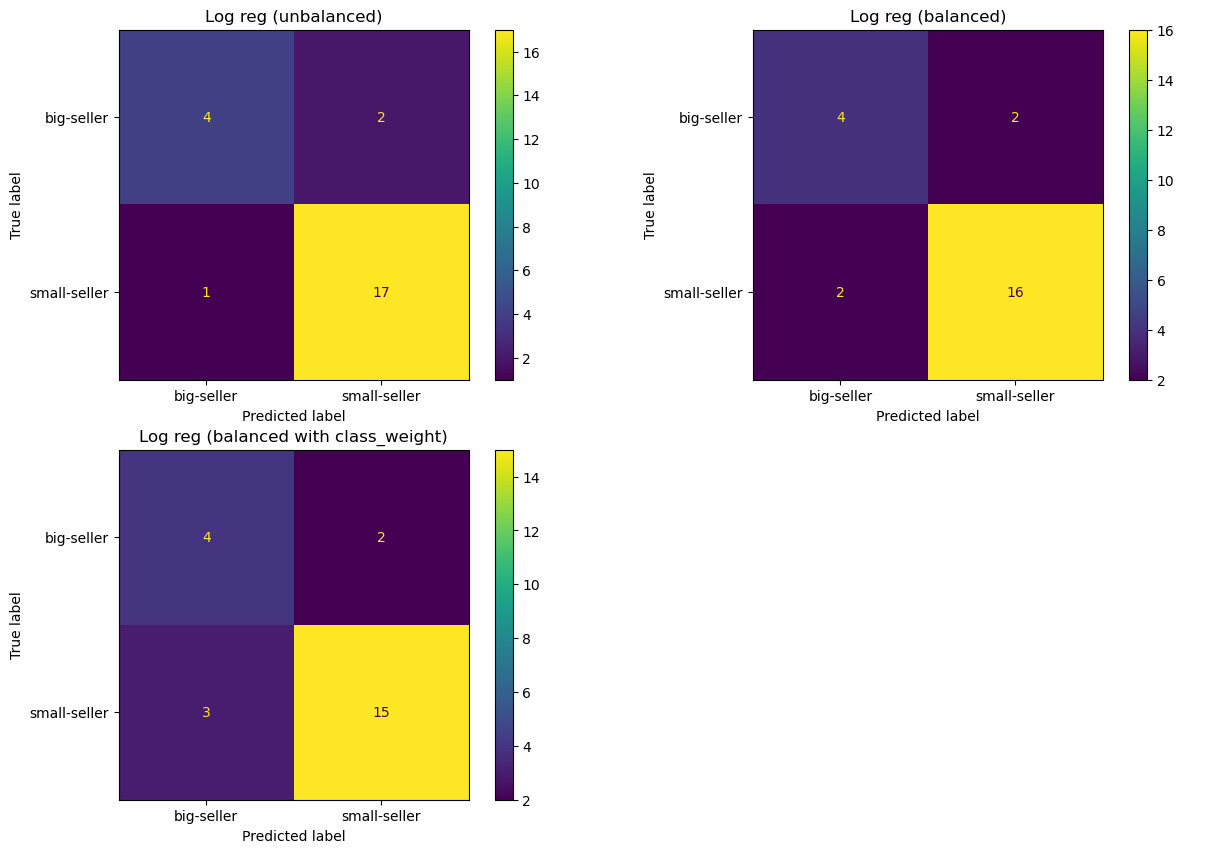

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

axes[0][0].set_title("Log reg (unbalanced)")
plot_confusion_matrix(log_unb, test_set, test_label, ax=axes[0][0])
axes[0][1].set_title("Log reg (balanced)")
plot_confusion_matrix(log_bal, test_set, test_label, ax=axes[0][1])
axes[1][0].set_title("Log reg (balanced with class_weight)")
plot_confusion_matrix(log_wei, test_set, test_label, ax=axes[1][0])
axes[1][1].axis('off')
plt.show() 

In [37]:
print("Log reg (unbalanced)")
report_scores(test_label, test_pred_log_unb)
print("\n")
print("Log reg (balanced)")
report_scores(test_label, test_pred_log_bal)
print("\n")
print("Log reg (balanced with class_weight)")
report_scores(test_label, test_pred_log_wei)

Log reg (unbalanced)
              precision    recall  f1-score   support

  big-seller       0.80      0.67      0.73         6
small-seller       0.89      0.94      0.92        18

    accuracy                           0.88        24
   macro avg       0.85      0.81      0.82        24
weighted avg       0.87      0.88      0.87        24



Log reg (balanced)
              precision    recall  f1-score   support

  big-seller       0.67      0.67      0.67         6
small-seller       0.89      0.89      0.89        18

    accuracy                           0.83        24
   macro avg       0.78      0.78      0.78        24
weighted avg       0.83      0.83      0.83        24



Log reg (balanced with class_weight)
              precision    recall  f1-score   support

  big-seller       0.57      0.67      0.62         6
small-seller       0.88      0.83      0.86        18

    accuracy                           0.79        24
   macro avg       0.73      0.75      0.74    

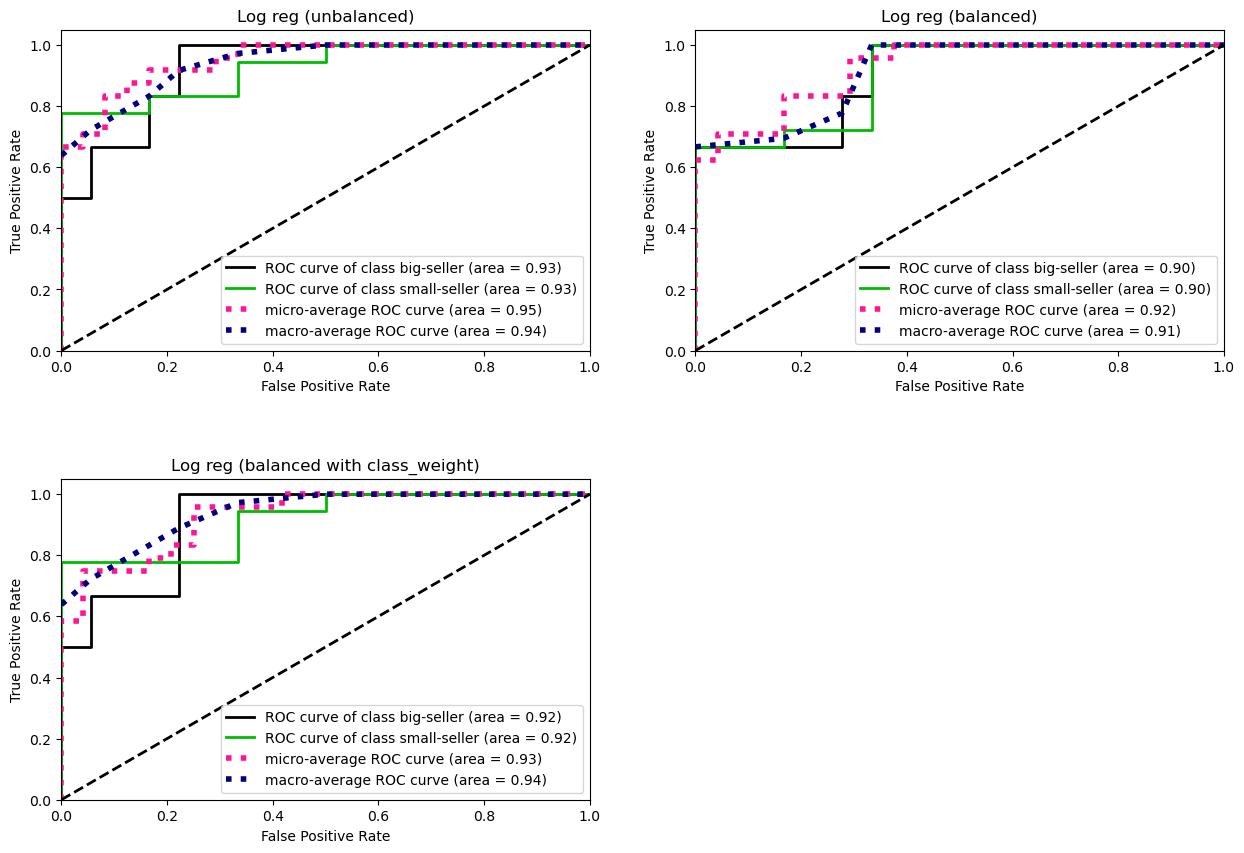

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

skplt.metrics.plot_roc(test_label.values, test_pred_proba_log_unb, title="Log reg (unbalanced)", ax=axes[0][0])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_log_bal, title="Log reg (balanced)", ax=axes[0][1])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_log_wei, title="Log reg (balanced with class_weight)", ax=axes[1][0])
axes[1][1].axis("off")
plt.show()

All of the models performed quite well with similar results, the unbalanced version seems to perform slightly better.  

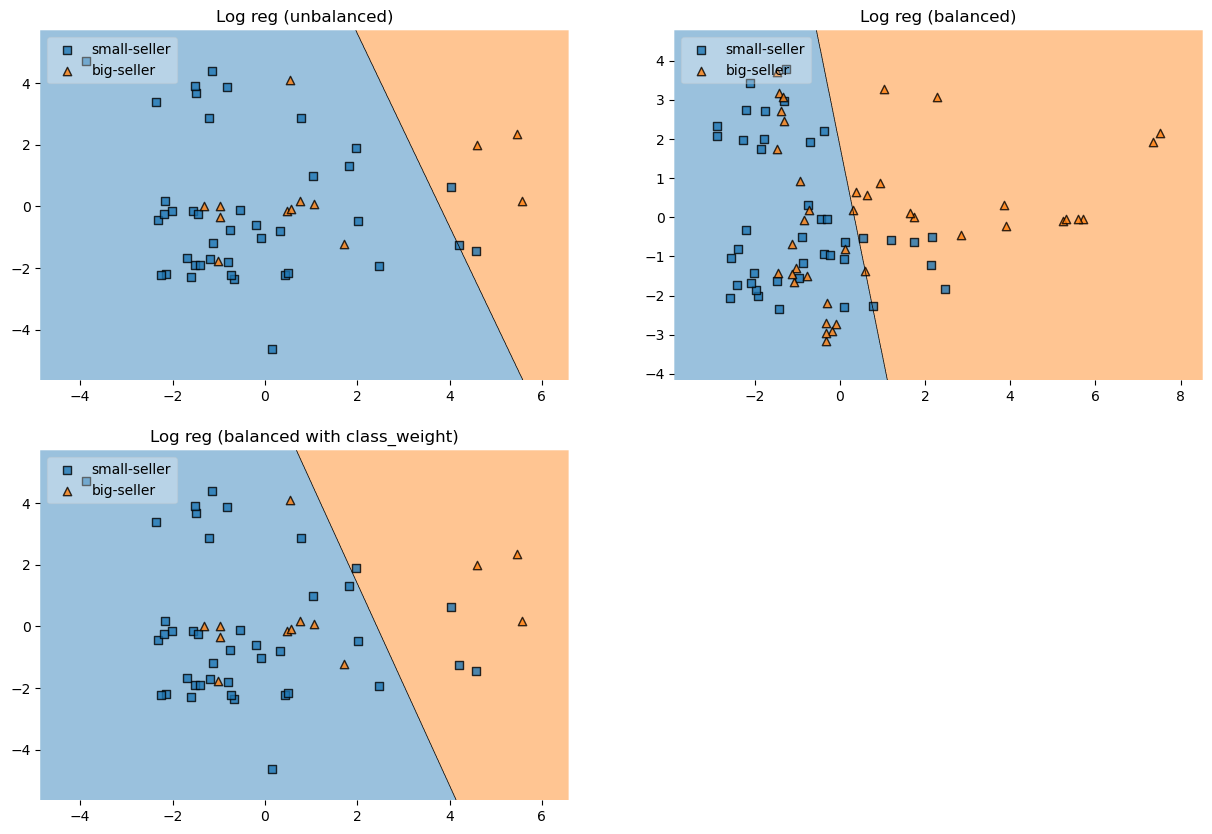

In [39]:
plot_decision_boundary([train_set, train_set_bal, train_set], [train_label, train_label_bal, train_label], \
                       [log_unb, log_bal, log_wei], \
                       ["Log reg (unbalanced)", "Log reg (balanced)", "Log reg (balanced with class_weight)"])

The decision boundary of the logistic regression is a line, which is not surprising since the model is a composition of a linear regression combined and the logistic function.  
It's also worth pointing out that balanced dataset changes the components of the PCA.

### Interpretation
Compared to their linear regression counterpart logistic regressions are not so immediate to interpret since the weights no longer influence the prediction in a linear way.  

In order to interpret the weights/coefficients we need to compute the odds ratios of the features, which in the logistic regression case is the ratio exp(linear model with feature changed)/exp(starting linear model).  
These can be algebraically reduced to computing exp(weight-j), where j is the index of the feature that we are changing.  

#### Unbalanced

In [40]:
coef_df_unb = pd.DataFrame(log_unb.coef_.reshape(-1,1), index=pred_df.columns, columns=["Feature weight"])
coef_df_unb.loc[:, "Odds ratio"] = np.exp(log_unb.coef_.reshape(-1,1))

In [41]:
coef_df_unb.sort_values("Odds ratio", ascending=False).head(5)

Feature weight  Odds ratio
TopSalesMonth_8.0         0.353068    1.423427
TopSalesMonth_11.0        0.315550    1.371013
TopCountry_Spain          0.275735    1.317499
TopSalesMonth_3.0         0.270617    1.310772
TopBrand_CRUCIAL          0.226439    1.254127

In [42]:
coef_df_unb.sort_values("Odds ratio", ascending=True).head(5)

Feature weight  Odds ratio
Eram                    -0.908041    0.403314
TotMonthBusiness        -0.559088    0.571730
MaxValuePerOrder        -0.512517    0.598986
TopSalesMonth_7.0       -0.446993    0.639548
TopCountry_France       -0.331677    0.717719

We can see that TopSalesMonth (8, 11,3) are the features with the highest Odds ratio (>=1.29), followed by TopCountry_Spain and TopBrand_CRUCIAL.  
The odds ratio value means that by each increase of 1 unit (in the original non-standardised values) for the numerical features or by changing the categorical feature TopSalesMonth from 0 to 1 we increase the probability of classifying a datapoint as small-seller by a factor equal to odds ratio.  

Likewise, by increasing Eram/TotMonthBusiness/etc (features with the lowest odds ratio) we increase the probability of classifying the entry as a big-seller.

This rests on the assumption that only one feature is changed/flipped at any single point:  

In example:

In [43]:
test_point = train_set.iloc[0]
test_point_changed = test_point.copy()
test_point_changed.loc["Eram"] = test_point_changed.loc["Eram"]+1

print("Original datapoint")
print(f"Label: {train_label.iloc[0]}")
print(f"Prob: {log_unb.predict_proba(test_point.values.reshape(1, -1))}\n")
print("Changed datapoint")
print(f"Label: {train_label.iloc[0]}")
print(f"Prob: {log_unb.predict_proba(test_point_changed.values.reshape(1, -1))}")

Original datapoint
Label: small-seller
Prob: [[0.01013266 0.98986734]]

Changed datapoint
Label: small-seller
Prob: [[0.02475247 0.97524753]]


By increasing Eram we increase the probability that the entry is a big-seller, according to the model.  
This makes sense given the positive correlation of Eram with the features used to construct the labels.

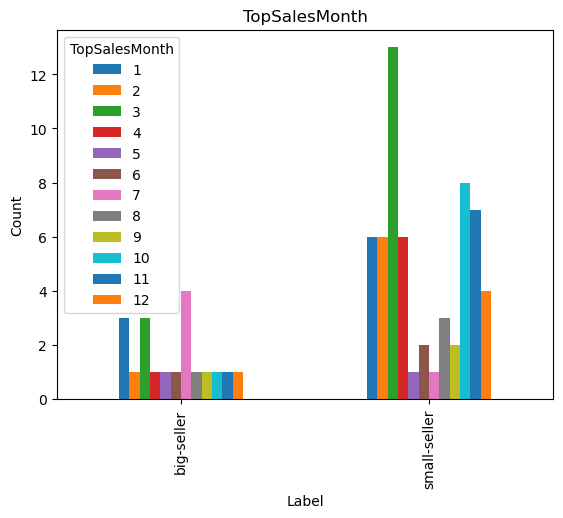

In [44]:
xt_pct = pd.crosstab(labels, vendor_df_cat_w_out["TopSalesMonth"])
xt_pct.plot(kind='bar', stacked=False, xlabel='Label', ylabel="Count", title="TopSalesMonth")
plt.show()

We can see that for the months 3 and 11 the odds ratio value seems justified by a (comparatively) greater concentration of small-seller vendors in those months.  
However the vendors with value 8 are few in both labels, it doesn't seem a particularly good feature for the purpose to us.

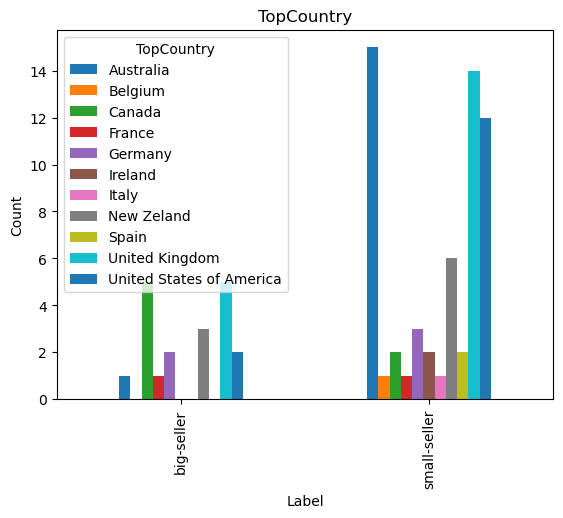

In [45]:
xt_pct = pd.crosstab(labels, vendor_df_cat_w_out["TopCountry"])
xt_pct.plot(kind='bar', stacked=False, xlabel='Label', ylabel="Count", title="TopCountry")
plt.show()

Regarding the TopCountry feature, the odds ratio reflects the fact that Spain is only represented in the small-seller label.  

#### Balanced

In [46]:
coef_df_bal = pd.DataFrame(log_bal.coef_.reshape(-1,1), index=pred_df.columns, columns=["Feature weight"])
coef_df_bal.loc[:, "Odds ratio"] = np.exp(log_bal.coef_.reshape(-1,1))

In [47]:
coef_df_bal.sort_values("Odds ratio", ascending=False).head(5)

Feature weight  Odds ratio
TopSalesMonth_8.0         0.477122    1.611430
TopSalesMonth_11.0        0.394310    1.483361
TopSalesMonth_3.0         0.316665    1.372543
TopBrand_CRUCIAL          0.308397    1.361242
TopCountry_Spain          0.305027    1.356662

Here we can see that the TopCountry_Spain variable is less influential.  
The considerations regarding the months are the same as above.

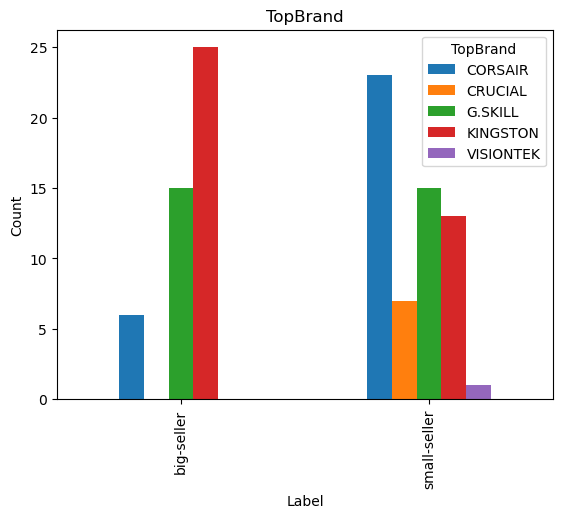

In [48]:
xt_pct = pd.crosstab(labels_bal, vendor_df_cat_w_out_bal["TopBrand"])
xt_pct.plot(kind='bar', stacked=False, xlabel='Label', ylabel="Count", title="TopBrand")
plt.show()

Crucial is represented only among the small-seller vendors, explaining the choice.

In [49]:
coef_df_bal.sort_values("Odds ratio", ascending=True).head(5)

Feature weight  Odds ratio
Eram                     -1.196791    0.302162
TotMonthBusiness         -0.745773    0.474368
MaxValuePerOrder         -0.669215    0.512110
TopSalesMonth_7.0        -0.563103    0.569439
TopSalesMonth_10.0       -0.460075    0.631237

The features with the lowest odds ratio are the same ones.

#### Balanced with class_weight

In [50]:
coef_df_wei = pd.DataFrame(log_wei.coef_.reshape(-1,1), index=pred_df.columns, columns=["Feature weight"])
coef_df_wei.loc[:, "Odds ratio"] = np.exp(log_wei.coef_.reshape(-1,1))

In [51]:
coef_df_wei.sort_values("Odds ratio", ascending=False).head(5)

Feature weight  Odds ratio
TopSalesMonth_8.0         0.325253    1.384381
TopSalesMonth_11.0        0.299871    1.349684
TopSalesMonth_3.0         0.268973    1.308620
TopCountry_Spain          0.251481    1.285929
TopBrand_CRUCIAL          0.233131    1.262547

Same features as in the unbalanced case, however they have a lower odds ratio.

In [52]:
coef_df_wei.sort_values("Odds ratio", ascending=True).head(5)

Feature weight  Odds ratio
Eram                    -0.878059    0.415589
TotMonthBusiness        -0.544396    0.580192
MaxValuePerOrder        -0.481724    0.617718
TopSalesMonth_7.0       -0.408683    0.664525
TopCountry_France       -0.296965    0.743070

Same as above.

## Decision trees

### Parameter search and fitting

In [53]:
random_state_dt = 0

#### Unbalanced classes

In [54]:
#define the parameters' values you want to try
param_grid_dt = {"max_depth": range(2, 10),
              "min_samples_split": range(2, 10),
              "min_samples_leaf": range(1, 5),
              "max_features": [None, "log2", "sqrt"],
              "criterion": ["gini", "entropy"],
              "random_state": [random_state_dt]}
#define the model
clf = tree.DecisionTreeClassifier()
#define the grid search
grid_search_dt_unb = GridSearchCV(clf, param_grid=param_grid_dt,
                            n_jobs=-1,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_dt_unb.fit(train_set, train_label)

print('Best settings parameters ', grid_search_dt_unb.best_params_)
print("Setting's accuracy score mean and std ", grid_search_dt_unb.cv_results_['mean_test_score'][0], 
      grid_search_dt_unb.cv_results_['std_test_score'][0])


#define a decision tree with the parameters found and fit it
dt_unb = tree.DecisionTreeClassifier(**grid_search_dt_unb.best_params_)
dt_unb.fit(train_set, train_label)

test_pred_dt_unb = dt_unb.predict(test_set)
test_pred_proba_dt_unb = dt_unb.predict_proba(test_set)

Best settings parameters  {'criterion': 'gini', 'max_depth': 9, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 3, 'random_state': 0}
Setting's accuracy score mean and std  0.7618181818181818 0.0898851425040602


#### Balanced classes

In [55]:
#define the parameters' values you want to try
param_grid_dt = {"max_depth": range(2, 10),
              "min_samples_split": range(2, 10),
              "min_samples_leaf": range(1, 5),
              "max_features": [None, "log2", "sqrt"],
              "criterion": ["gini", "entropy"],
              "random_state": [random_state_dt]}
#define the model
clf = tree.DecisionTreeClassifier()
#define the grid search
grid_search_dt_bal = GridSearchCV(clf, param_grid=param_grid_dt,
                            n_jobs=-1,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_dt_bal.fit(train_set_bal, train_label_bal)

print('Best settings parameters ', grid_search_dt_bal.best_params_)
print("Setting's accuracy score mean and std ", grid_search_dt_bal.cv_results_['mean_test_score'][0], 
      grid_search_dt_bal.cv_results_['std_test_score'][0])


#define a decision tree with the parameters found and fit it
dt_bal = tree.DecisionTreeClassifier(**grid_search_dt_bal.best_params_)
dt_bal.fit(train_set_bal, train_label_bal)

test_pred_dt_bal = dt_bal.predict(test_set)
test_pred_proba_dt_bal = dt_bal.predict_proba(test_set)

Best settings parameters  {'criterion': 'entropy', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 0}
Setting's accuracy score mean and std  0.8647058823529411 0.09075447885656086


#### Balanced classes with class_weight

In [56]:
#define the parameters' values you want to try
param_grid_dt = {"max_depth": range(2, 10),
              "min_samples_split": range(2, 10),
              "min_samples_leaf": range(1, 5),
              "max_features": [None, "log2", "sqrt"],
              "criterion": ["gini", "entropy"],
              "random_state": [random_state_dt],
              "class_weight": ["balanced"]}
#define the model
clf = tree.DecisionTreeClassifier()
#define the grid search
grid_search_dt_wei = GridSearchCV(clf, param_grid=param_grid_dt,
                            n_jobs=-1,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_dt_wei.fit(train_set, train_label)

print('Best settings parameters ', grid_search_dt_wei.best_params_)
print("Setting's accuracy score mean and std ", grid_search_dt_wei.cv_results_['mean_test_score'][0], 
      grid_search_dt_wei.cv_results_['std_test_score'][0])


#define a decision tree with the parameters found and fit it
dt_wei = tree.DecisionTreeClassifier(**grid_search_dt_wei.best_params_)
dt_wei.fit(train_set, train_label)

test_pred_dt_wei = dt_wei.predict(test_set)
test_pred_proba_dt_wei = dt_wei.predict_proba(test_set)

Best settings parameters  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 4, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 0}
Setting's accuracy score mean and std  0.7581818181818182 0.12538865199684848


### Evaluation

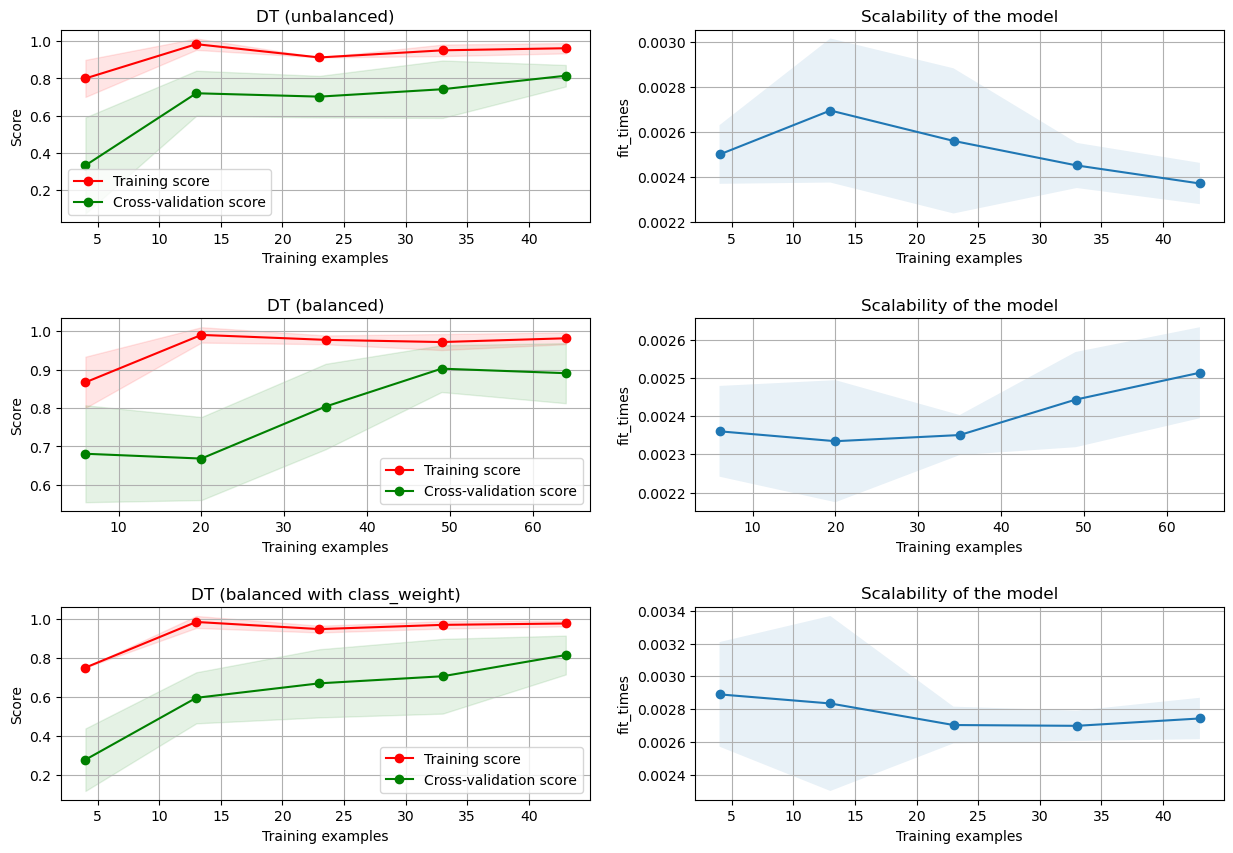

In [57]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

plot_learning_curve(dt_unb, "DT (unbalanced)", train_set, train_label, ax=axes[0])
plot_learning_curve(dt_bal, "DT (balanced)", train_set_bal, train_label_bal, ax=axes[1])
plot_learning_curve(dt_wei, "DT (balanced with class_weight)", train_set,train_label, ax=axes[2])

plt.show()

The learning curve suggests, through the upward trend of the cv score, that the model could benefit from more datapoints.

DT (unbalanced)


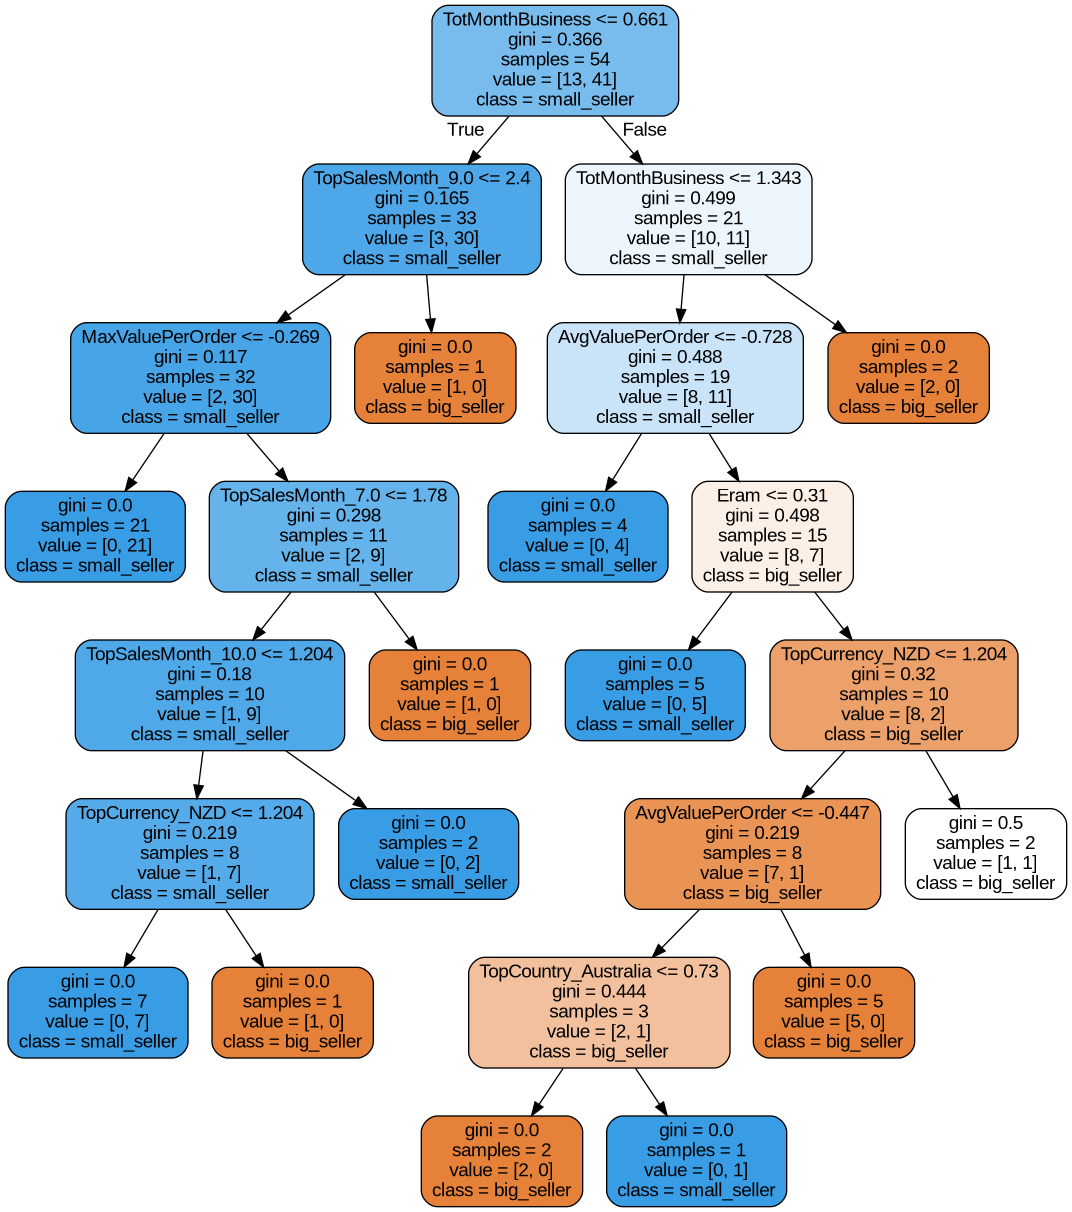

In [58]:
print("DT (unbalanced)")
dot_data = tree.export_graphviz(dt_unb, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['big_seller', 'small_seller'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

DT (balanced)


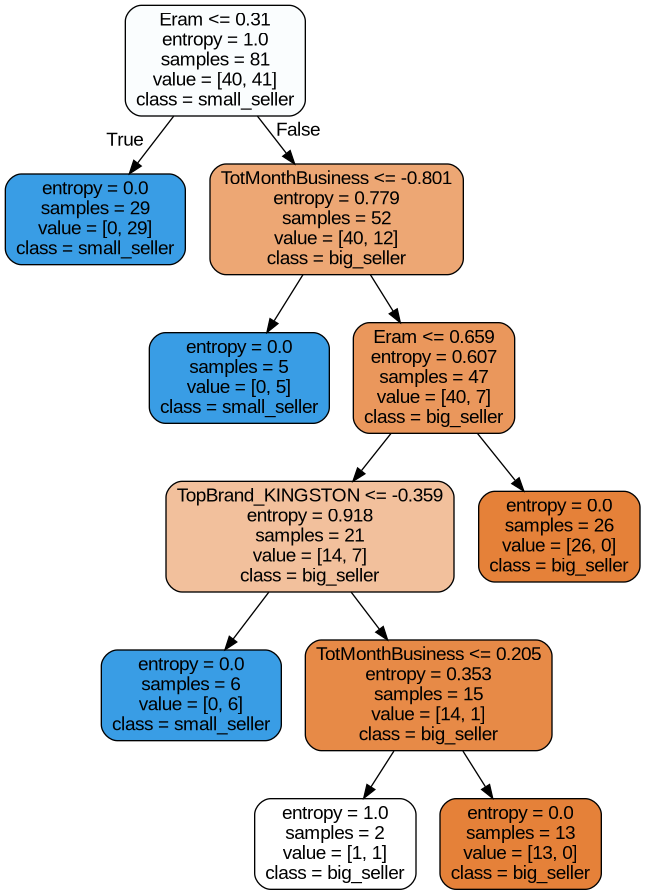

In [59]:
print("DT (balanced)")
dot_data = tree.export_graphviz(dt_bal, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['big_seller', 'small_seller'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

DT (balanced with class_weight)


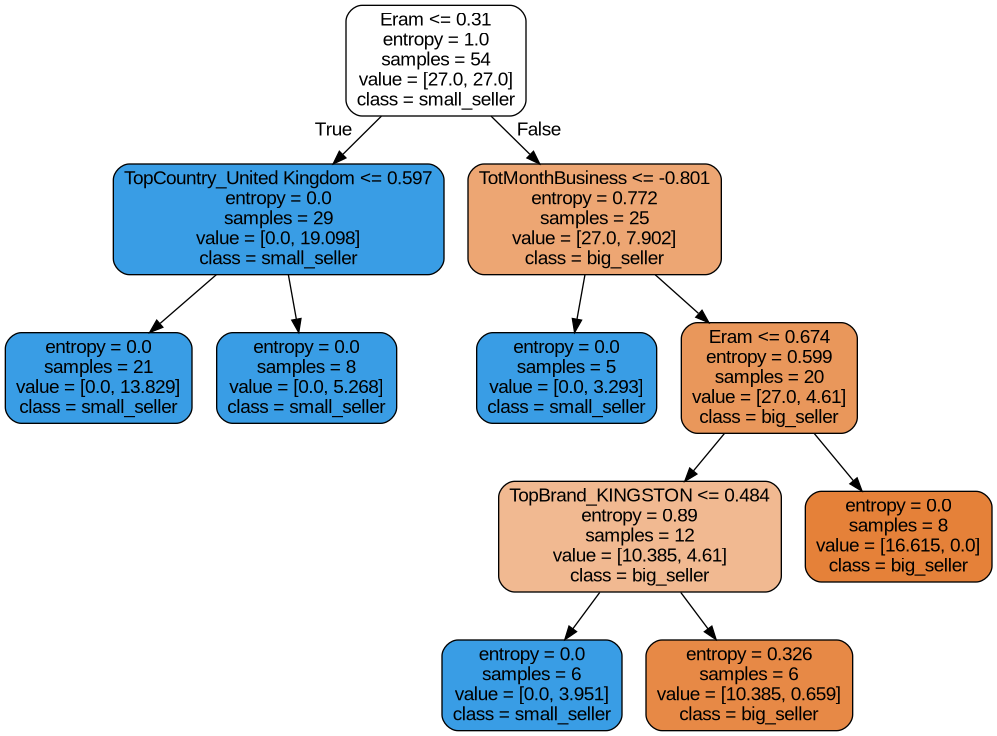

In [60]:
print("DT (balanced with class_weight)")
dot_data = tree.export_graphviz(dt_wei, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['big_seller', 'small_seller'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [61]:
print("DT (unbalanced)")
report_scores(test_label, test_pred_dt_unb)
print("\n")
print("DT (balanced)")
report_scores(test_label, test_pred_dt_bal)
print("\n")
print("DT (balanced with class_weight)")
report_scores(test_label, test_pred_dt_wei)

DT (unbalanced)
              precision    recall  f1-score   support

  big-seller       0.50      0.50      0.50         6
small-seller       0.83      0.83      0.83        18

    accuracy                           0.75        24
   macro avg       0.67      0.67      0.67        24
weighted avg       0.75      0.75      0.75        24



DT (balanced)
              precision    recall  f1-score   support

  big-seller       1.00      0.83      0.91         6
small-seller       0.95      1.00      0.97        18

    accuracy                           0.96        24
   macro avg       0.97      0.92      0.94        24
weighted avg       0.96      0.96      0.96        24



DT (balanced with class_weight)
              precision    recall  f1-score   support

  big-seller       1.00      0.83      0.91         6
small-seller       0.95      1.00      0.97        18

    accuracy                           0.96        24
   macro avg       0.97      0.92      0.94        24
weighted

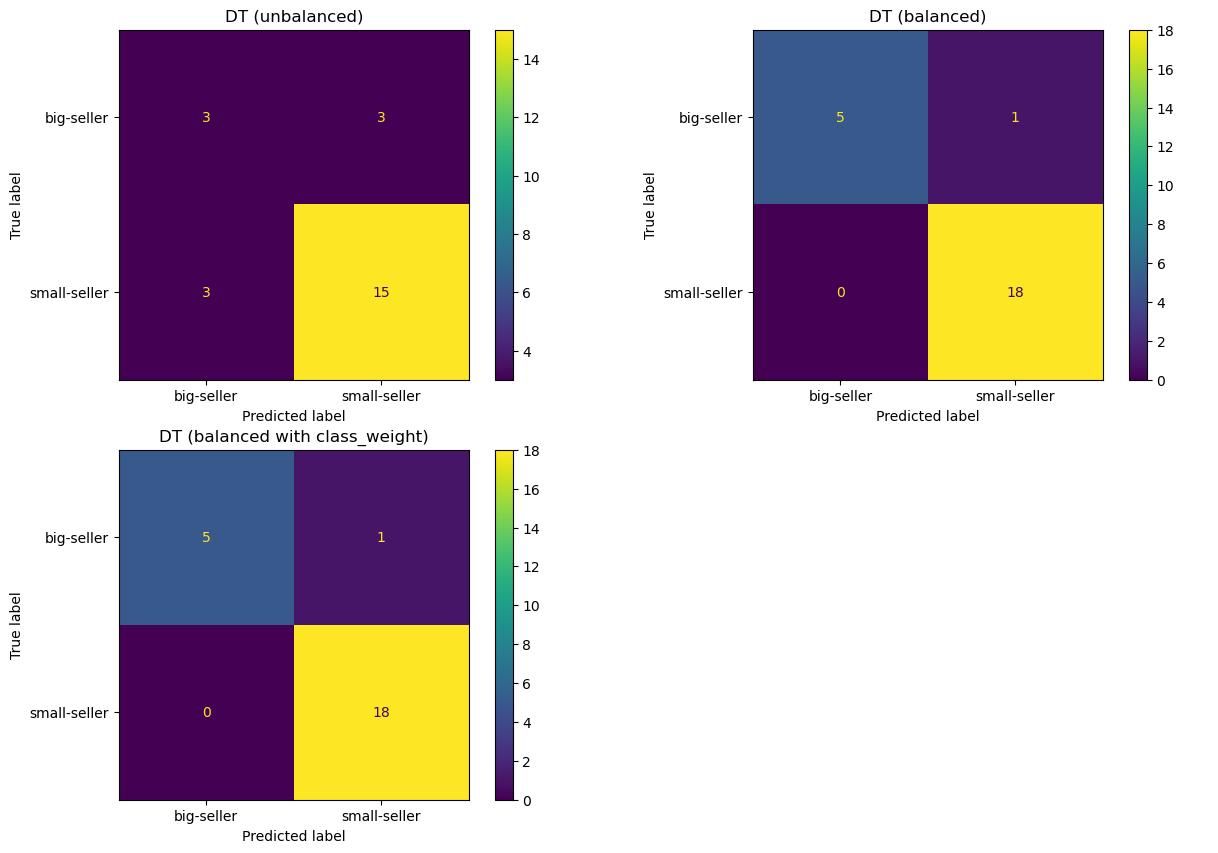

In [62]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

axes[0][0].set_title("DT (unbalanced)")
plot_confusion_matrix(dt_unb, test_set, test_label, ax=axes[0][0])
axes[0][1].set_title("DT (balanced)")
plot_confusion_matrix(dt_bal, test_set, test_label, ax=axes[0][1])
axes[1][0].set_title("DT (balanced with class_weight)")
plot_confusion_matrix(dt_wei, test_set, test_label, ax=axes[1][0])
axes[1][1].axis('off')
plt.show()

Both the metrics results and size of the first dt point to a case of overfitting, in the next section we will try to limit the tree's complexity through the use of ccp_alpha coefficients.  
The third tree decided to use the feature TopCountry with value UnitedKingdom even though it didn't use it during the training phase (note the entropy equal to 0), it seems that it could benefit from post-pruning.

The last two trees have identical results and number of nodes used, they differ in the choice of features used.

### Post-pruning

In [63]:
#Adapted from sklearn example on dt pruning
def ccp_alpha_pruning(dt, dt_params, dataset, labels, title=None):
    
    if title:
        print(title)
        
    path = dt.cost_complexity_pruning_path(dataset, labels)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities

    fig, ax = plt.subplots(3, 1, figsize=(10,10))

    ax[0].plot(ccp_alphas[:-1], impurities[:-1], marker='o', drawstyle="steps-post")
    ax[0].set_xlabel("Effective alpha")
    ax[0].set_ylabel("Total impurity of leaves")
    ax[0].set_title("Total Impurity vs effective alpha for training set")

    clfs = []
    for ccp_alpha in ccp_alphas:
        clf = tree.DecisionTreeClassifier(**dt_params, ccp_alpha=ccp_alpha)
        clf.fit(dataset, labels)
        clfs.append(clf)

    print("Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
          clfs[-1].tree_.node_count, ccp_alphas[-1]))


    clfs = clfs[:-1]
    ccp_alphas = ccp_alphas[:-1]

    node_counts = [clf.tree_.node_count for clf in clfs]
    depth = [clf.tree_.max_depth for clf in clfs]
    ax[1].plot(ccp_alphas, node_counts, marker='o', drawstyle="steps-post")
    ax[1].set_xlabel("alpha")
    ax[1].set_ylabel("number of nodes")
    ax[1].set_title("Number of nodes vs alpha")
    ax[2].plot(ccp_alphas, depth, marker='o', drawstyle="steps-post")
    ax[2].set_xlabel("alpha")
    ax[2].set_ylabel("depth of tree")
    ax[2].set_title("Depth vs alpha")
    fig.tight_layout()
    
    return ccp_alphas

#### Unbalanced case

DT (unbalanced)
Number of nodes in the last tree is: 1 with ccp_alpha: 0.0705556446297187


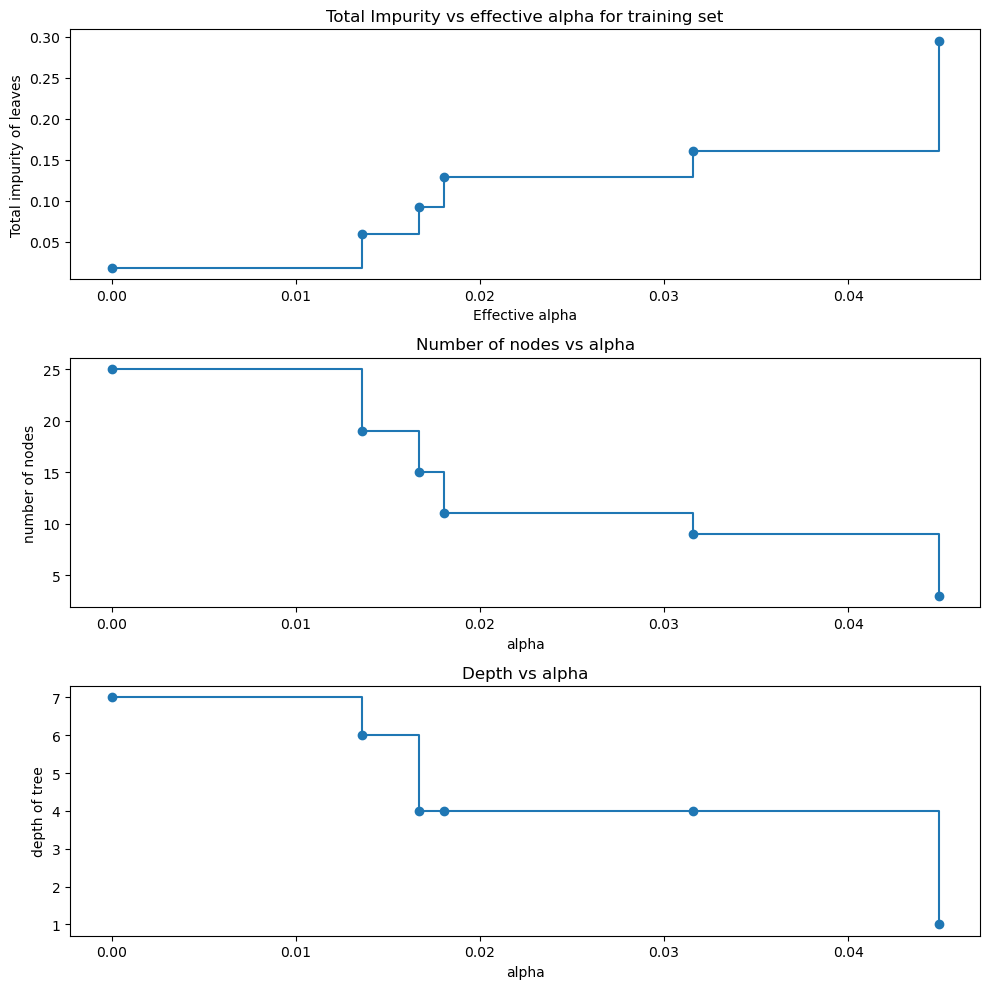

In [64]:
ccp_alphas_unb = ccp_alpha_pruning(dt_unb, grid_search_dt_unb.best_params_, train_set, train_label, "DT (unbalanced)")

In [65]:
dt_unb_post = tree.DecisionTreeClassifier(**grid_search_dt_unb.best_params_, ccp_alpha=ccp_alphas_unb[-3])
dt_unb_post.fit(train_set, train_label)

test_pred_dt_unb_post = dt_unb_post.predict(test_set)
test_pred_proba_dt_unb_post = dt_unb_post.predict_proba(test_set)

DT (unbalanced, post-pruned)


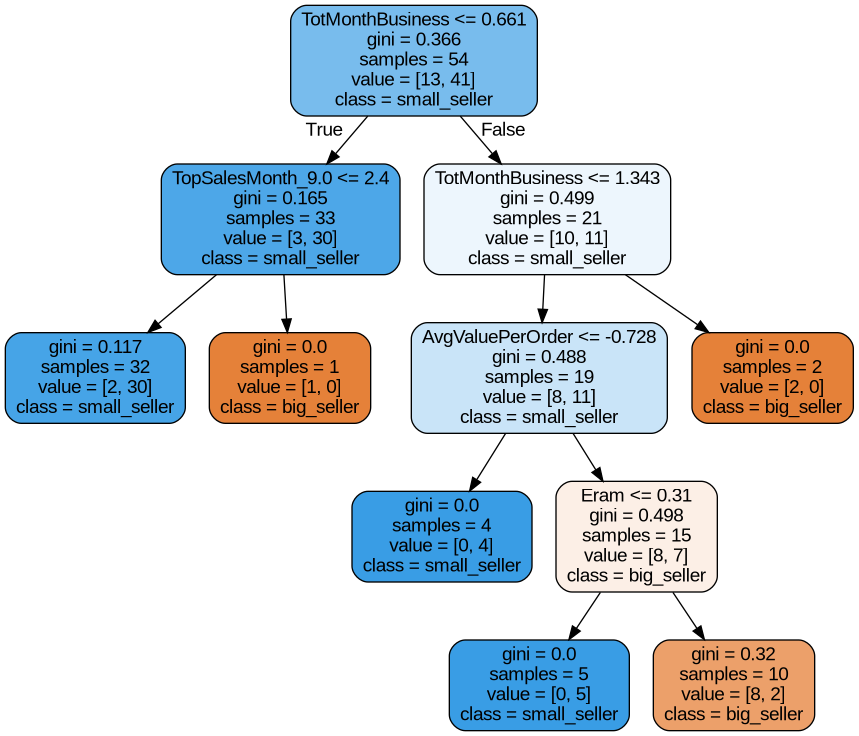

In [66]:
print("DT (unbalanced, post-pruned)")
dot_data = tree.export_graphviz(dt_unb_post, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['big_seller', 'small_seller'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

We reduced the tree using the third to last ccp_alpha value, in order to make its number of nodes more in line with the other dts.

#### Balanced with class_weight

DT (balanced with class_weight)
Number of nodes in the last tree is: 1 with ccp_alpha: 0.5012121720261645


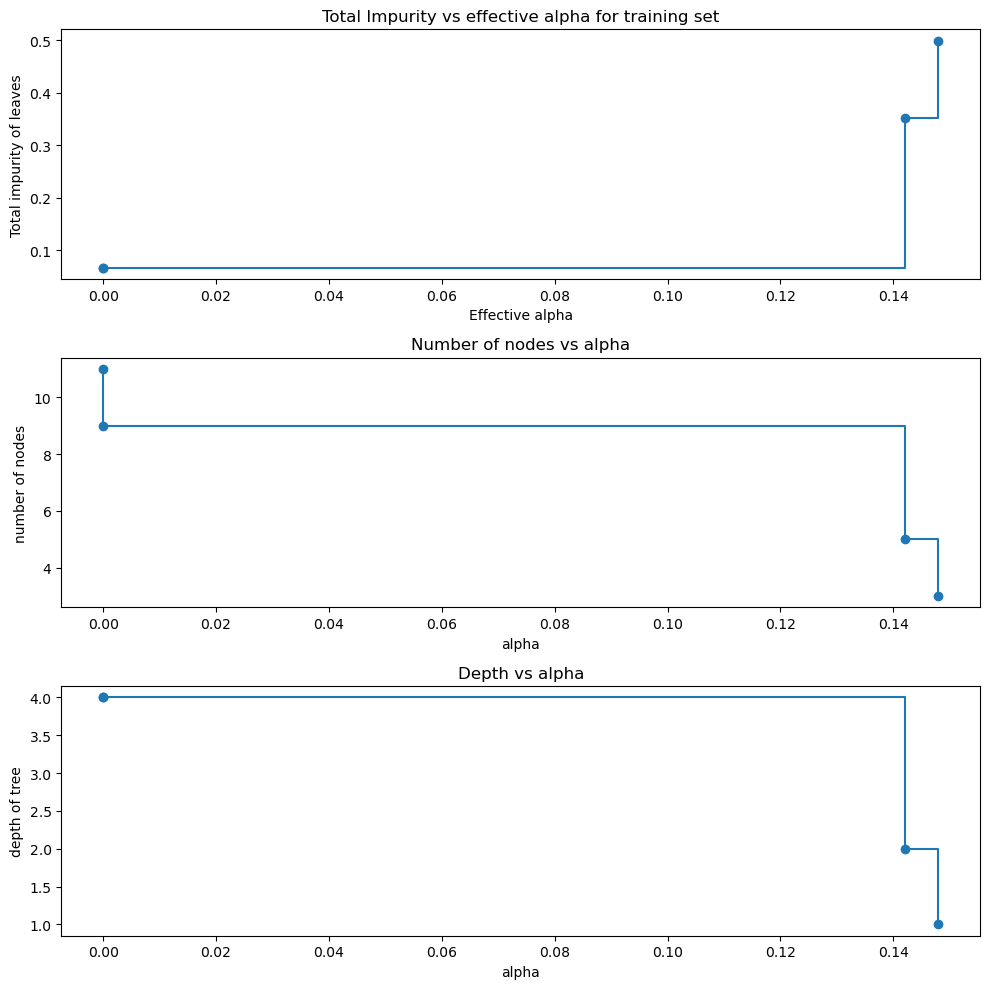

In [67]:
ccp_alphas_wei = ccp_alpha_pruning(dt_wei, grid_search_dt_wei.best_params_, train_set, train_label, "DT (balanced with class_weight)")

In [68]:
dt_wei_post = tree.DecisionTreeClassifier(**grid_search_dt_wei.best_params_, ccp_alpha=ccp_alphas_wei[-3])
dt_wei_post.fit(train_set, train_label)

test_pred_dt_wei_post = dt_wei_post.predict(test_set)
test_pred_proba_dt_wei_post = dt_wei_post.predict_proba(test_set)

DT (balanced with class_weight, post-pruned)


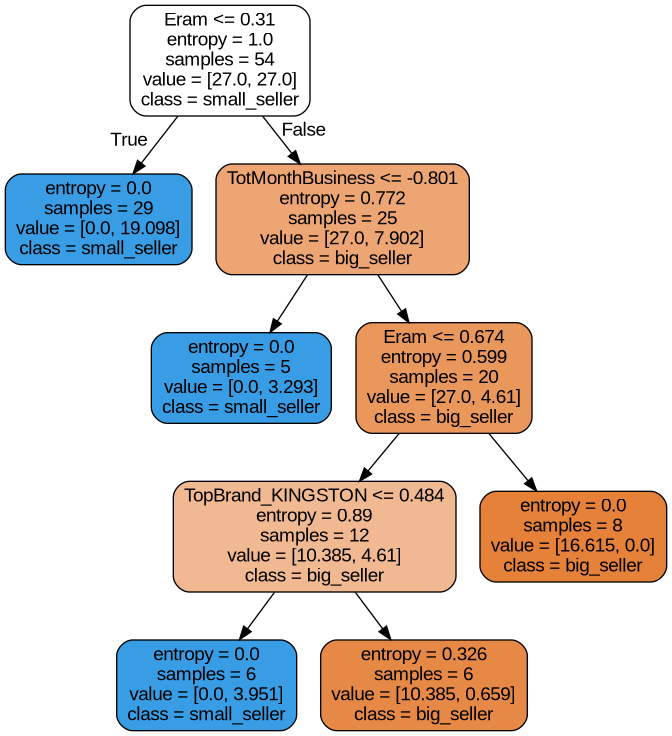

In [69]:
print("DT (balanced with class_weight, post-pruned)")
dot_data = tree.export_graphviz(dt_wei_post, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['big_seller', 'small_seller'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

Here we just removed the unused TopCountry node.

#### Results

In [70]:
print("DT (unbalanced, pruned)")
report_scores(test_label, test_pred_dt_unb_post)
print("\n")
print("DT (balanced, non-pruned)")
report_scores(test_label, test_pred_dt_bal)
print("\n")
print("DT (balanced with class_weight, pruned)")
report_scores(test_label, test_pred_dt_wei_post)

DT (unbalanced, pruned)
              precision    recall  f1-score   support

  big-seller       0.40      0.33      0.36         6
small-seller       0.79      0.83      0.81        18

    accuracy                           0.71        24
   macro avg       0.59      0.58      0.59        24
weighted avg       0.69      0.71      0.70        24



DT (balanced, non-pruned)
              precision    recall  f1-score   support

  big-seller       1.00      0.83      0.91         6
small-seller       0.95      1.00      0.97        18

    accuracy                           0.96        24
   macro avg       0.97      0.92      0.94        24
weighted avg       0.96      0.96      0.96        24



DT (balanced with class_weight, pruned)
              precision    recall  f1-score   support

  big-seller       1.00      0.83      0.91         6
small-seller       0.95      1.00      0.97        18

    accuracy                           0.96        24
   macro avg       0.97      0.92 

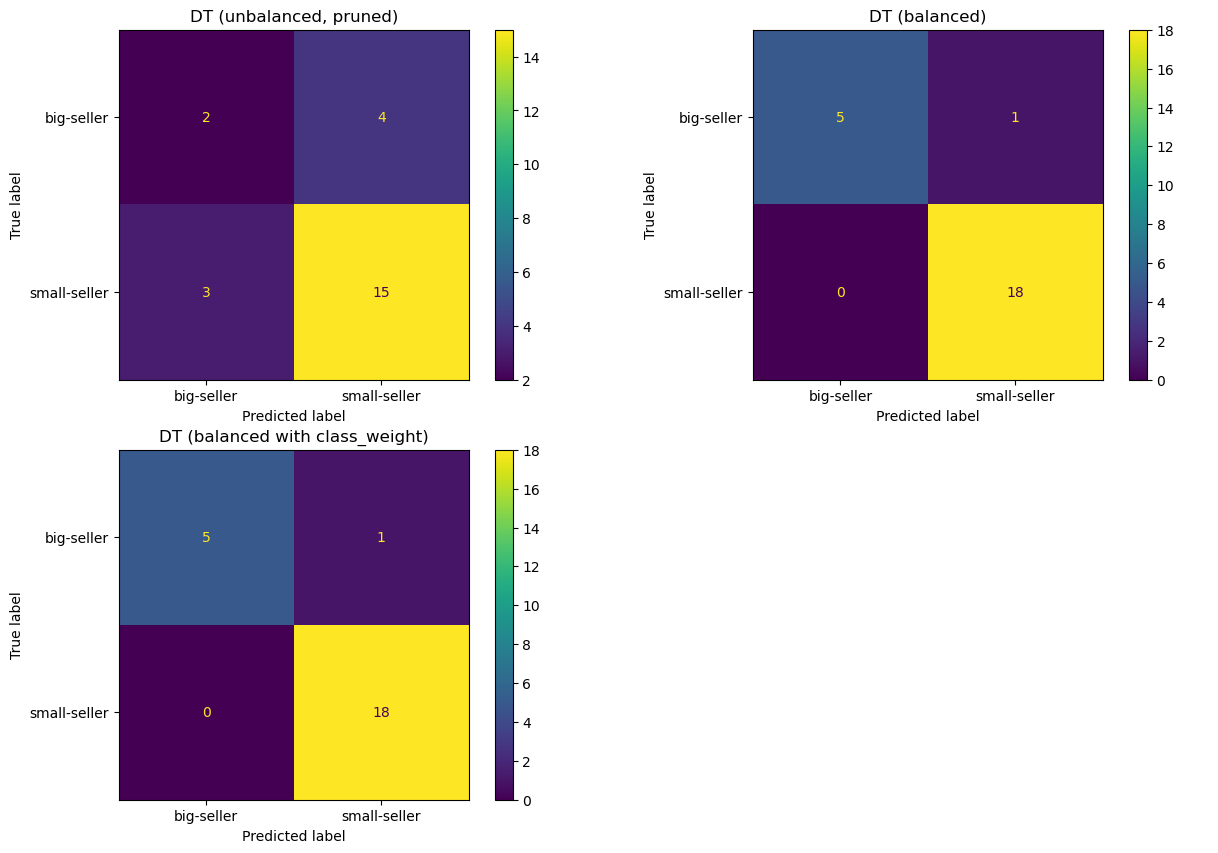

In [71]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

axes[0][0].set_title("DT (unbalanced, pruned)")
plot_confusion_matrix(dt_unb_post, test_set, test_label, ax=axes[0][0])
axes[0][1].set_title("DT (balanced)")
plot_confusion_matrix(dt_bal, test_set, test_label, ax=axes[0][1])
axes[1][0].set_title("DT (balanced with class_weight)")
plot_confusion_matrix(dt_wei, test_set, test_label, ax=axes[1][0])
axes[1][1].axis('off')
plt.show() 

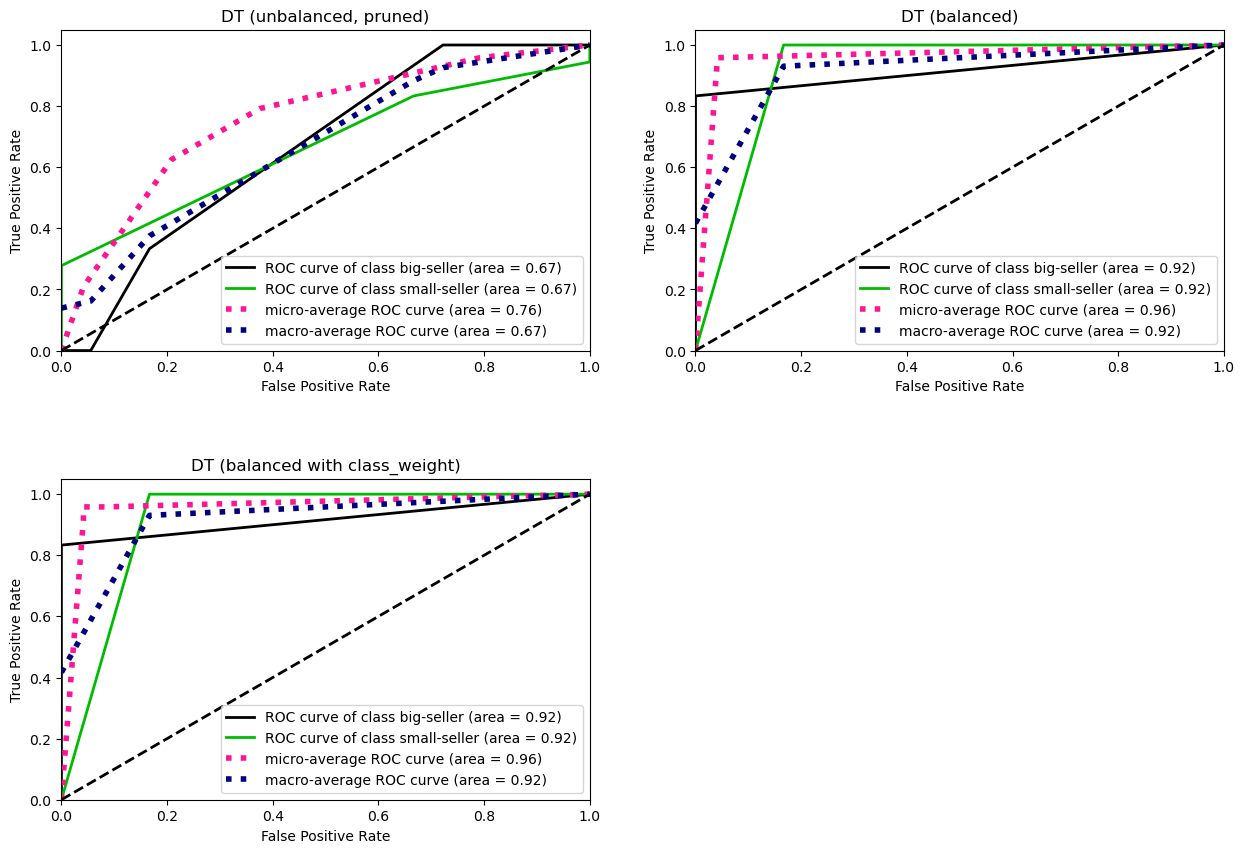

In [72]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

skplt.metrics.plot_roc(test_label.values, test_pred_proba_dt_unb_post, title="DT (unbalanced, pruned)", ax=axes[0][0])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_dt_bal, title="DT (balanced)", ax=axes[0][1])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_dt_wei, title="DT (balanced with class_weight)", ax=axes[1][0])
axes[1][1].axis("off")
plt.show()

The results for the first tree are still worse compared to the other two models, post-pruning made the dt more selective in what it considers big-seller (increasing precision and decreasing recall), improved its accuracy and small-seller related metrics.

The third tree results are unchanged, showing the same results of the second tree while having a lower complexity.

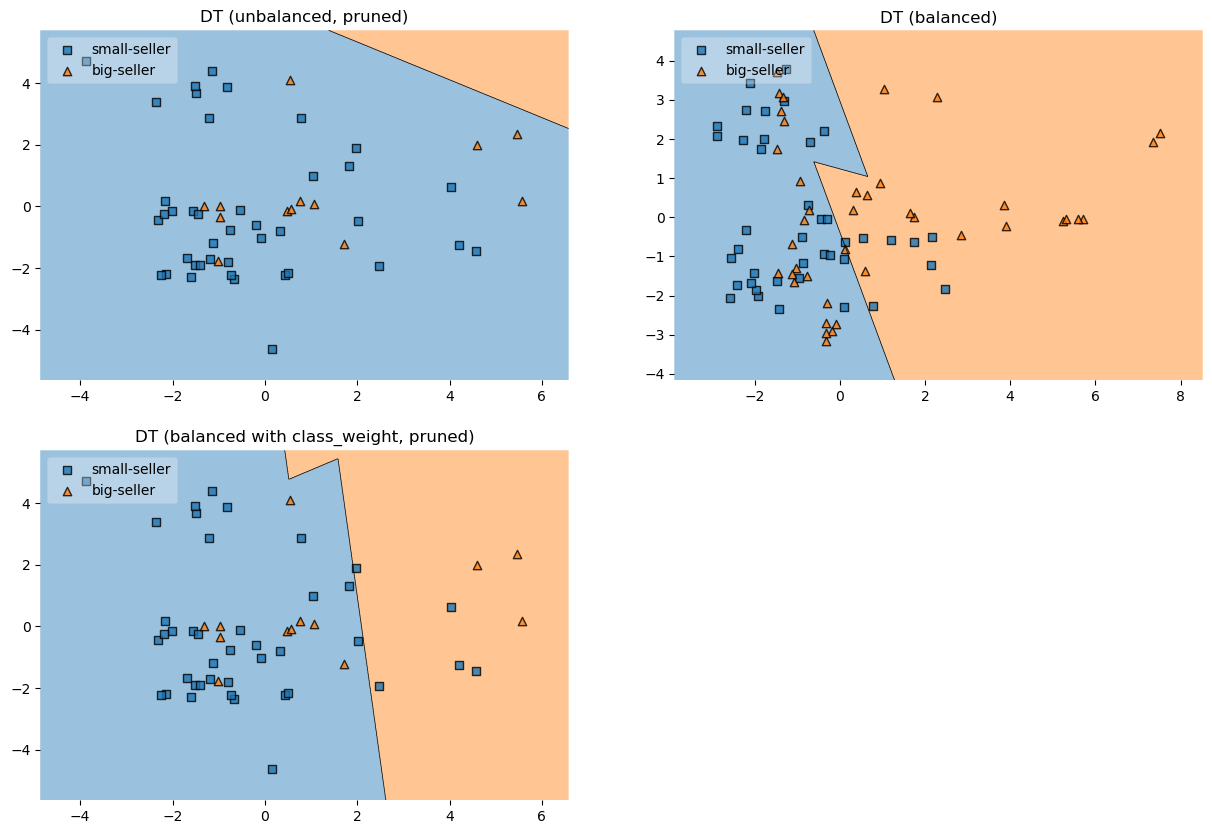

In [73]:
plot_decision_boundary([train_set, train_set_bal, train_set], [train_label, train_label_bal, train_label], \
                       [dt_unb_post, dt_bal, dt_wei_post], \
                       ["DT (unbalanced, pruned)", "DT (balanced)", "DT (balanced with class_weight, pruned)"])

Even though we don't have a complete picture, in this model it is clearly visible that the decision boundary can be more complex than a simple line/hyperplane.

### Interpretation
In the case of decision trees we can understand and interpret the model by just checking the conditions on the nodes of the tree.

DT (balanced with class_weight)


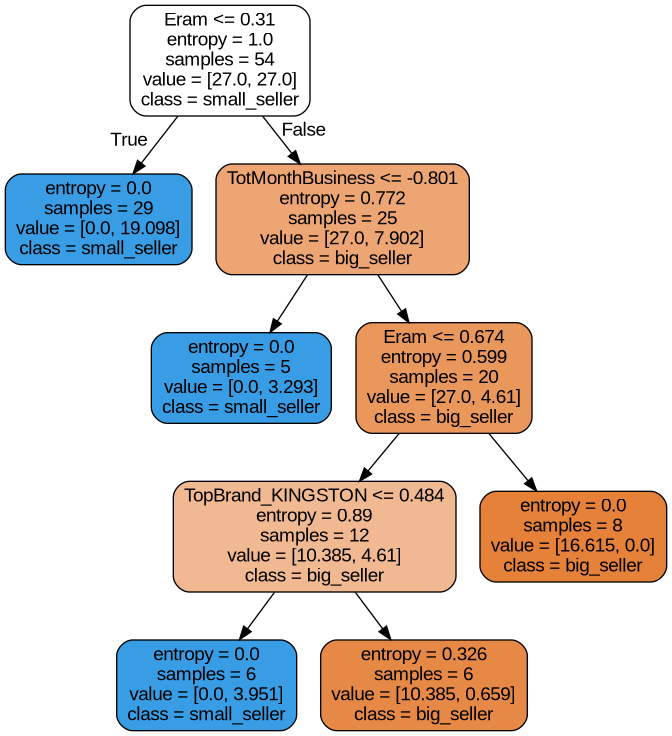

In [279]:
print("DT (balanced with class_weight)")
dot_data = tree.export_graphviz(dt_wei_post, out_file=None, 
                         feature_names=list(train_set.columns),  
                         class_names=['big_seller', 'small_seller'],  
                         filled=True, rounded=True)  
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

## Naives Bayes classifier
Since we have different type on entries in our dataset we will use GaussianNB for contiguous features and CategoricalNB for categorical data.  
Assuming indipendence between the variable we will then multiply the results and see which is the most probable label.

### Categorical/numerical set split
We need to separate the categorical features from the numerical ones in order to feed them to two separate models.

In [75]:
num_train_set = train_set.drop(vendor_df_cat_discr.columns, axis=1)
num_train_set_bal = train_set_bal.drop(vendor_df_cat_discr.columns, axis=1)
num_test_set = test_set.drop(vendor_df_cat_discr.columns, axis=1)

cat_train_set = train_set.loc[:, vendor_df_cat_discr.columns]
cat_train_set_bal = train_set_bal.loc[:, vendor_df_cat_discr.columns]
cat_test_set = test_set.loc[:, vendor_df_cat_discr.columns]

### Ordinal encoding
Since the onehot encoding produces features that are clearly not indipendent from one another and since we want to apply a CategoricalNB model we need to change the encoding.  
Here we opt for ordinal encoding.

In [76]:
cat_features_ord_enc = OrdinalEncoder()

#First we decode the onehot version
#Train set
cat_train_set_dec = cat_features_one_enc.inverse_transform(revert_cat_standardisation(cat_train_set, feature_list=cat_train_set.columns))
cat_features_ord_enc.fit(cat_train_set_dec)
cat_train_set_ord = cat_features_ord_enc.transform(cat_train_set_dec)

#Train set balanced
cat_train_set_bal_dec = cat_features_one_enc.inverse_transform(\
                                    revert_cat_standardisation(cat_train_set_bal, feature_list=cat_train_set.columns))
cat_train_set_bal_ord = cat_features_ord_enc.transform(cat_train_set_bal_dec)

#Test set
cat_test_set_dec = cat_features_one_enc.inverse_transform(\
                                    revert_cat_standardisation(cat_test_set, feature_list=cat_train_set.columns))
cat_test_set_ord = cat_features_ord_enc.transform(cat_test_set_dec)


cat_test_set_ord.head(10)

TopBrand  TopCountry  TopCurrency  \
vendor_code name                                                    
52          Newegg Marketplace         1           3            3   
31          Electronicamente           3           4            4   
13          B H                        4           3            3   
33          IJK                        1           1            1   
26          Dell                       3           3            3   
22          Corsair                    2           3            3   
24          Corsair UK                 2           2            2   
74          shopRBC                    3           9            6   
66          Playtech                   1           5            5   
30          Ebuyer                     2           2            2   

                                TopSalesMonth  
vendor_code name                               
52          Newegg Marketplace              2  
31          Electronicamente                3  
13          B H                             4  
33          IJK                            11  
26          Dell                           10  
22          Corsair                        11  
24          Corsair UK                      2  
74          shopRBC                         7  
66          Playtech                       12  
30          Ebuyer                          7

### Fitting

#### Unbalanced classes

In [77]:
gnb_unb = GaussianNB()
gnb_unb.fit(num_train_set, train_label)

test_pred_gnb_unb = gnb_unb.predict(num_test_set)
test_pred_proba_gnb_unb = gnb_unb.predict_proba(num_test_set)

In [78]:
cnb_unb = CategoricalNB()
cnb_unb.fit(cat_train_set_ord, train_label)

test_pred_cnb_unb = cnb_unb.predict(cat_test_set_ord)
test_pred_proba_cnb_unb = cnb_unb.predict_proba(cat_test_set_ord)

#### Balanced classes

In [79]:
gnb_bal = GaussianNB()
gnb_bal.fit(num_train_set_bal, train_label_bal)

test_pred_gnb_bal = gnb_bal.predict(num_test_set)
test_pred_proba_gnb_bal = gnb_bal.predict_proba(num_test_set)

In [80]:
cnb_bal = CategoricalNB()
cnb_bal.fit(cat_train_set_bal_ord, train_label_bal)

test_pred_cnb_bal = cnb_bal.predict(cat_test_set_ord)
test_pred_proba_cnb_bal = cnb_bal.predict_proba(cat_test_set_ord)

### Evaluation

In [81]:
print("GaussianNB (unbalanced)")
report_scores(test_label, test_pred_gnb_unb)
print("\n")
print("CategoricalNB (unbalanced)")
report_scores(test_label, test_pred_cnb_unb)

GaussianNB (unbalanced)
              precision    recall  f1-score   support

  big-seller       0.60      0.50      0.55         6
small-seller       0.84      0.89      0.86        18

    accuracy                           0.79        24
   macro avg       0.72      0.69      0.71        24
weighted avg       0.78      0.79      0.79        24



CategoricalNB (unbalanced)
              precision    recall  f1-score   support

  big-seller       0.50      0.50      0.50         6
small-seller       0.83      0.83      0.83        18

    accuracy                           0.75        24
   macro avg       0.67      0.67      0.67        24
weighted avg       0.75      0.75      0.75        24



In [82]:
print("GaussianNB (balanced)")
report_scores(test_label, test_pred_gnb_bal)
print("\n")
print("CategoricalNB (balanced)")
report_scores(test_label, test_pred_cnb_bal)

GaussianNB (balanced)
              precision    recall  f1-score   support

  big-seller       0.62      0.83      0.71         6
small-seller       0.94      0.83      0.88        18

    accuracy                           0.83        24
   macro avg       0.78      0.83      0.80        24
weighted avg       0.86      0.83      0.84        24



CategoricalNB (balanced)
              precision    recall  f1-score   support

  big-seller       0.57      0.67      0.62         6
small-seller       0.88      0.83      0.86        18

    accuracy                           0.79        24
   macro avg       0.73      0.75      0.74        24
weighted avg       0.80      0.79      0.80        24



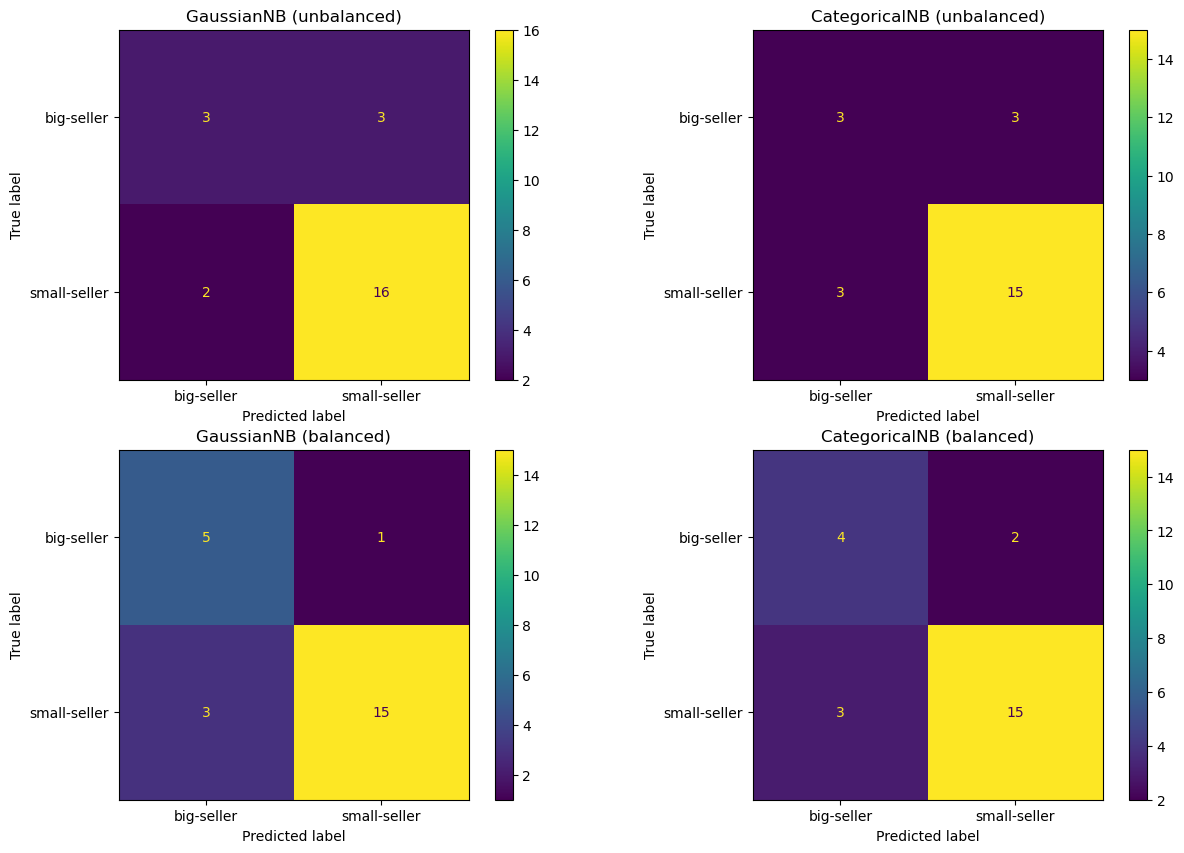

In [83]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

axes[0][0].set_title("GaussianNB (unbalanced)")
plot_confusion_matrix(gnb_unb, num_test_set, test_label, ax=axes[0][0])
axes[0][1].set_title("CategoricalNB (unbalanced)")
plot_confusion_matrix(cnb_unb, cat_test_set_ord, test_label, ax=axes[0][1])
axes[1][0].set_title("GaussianNB (balanced)")
plot_confusion_matrix(gnb_bal, num_test_set, test_label, ax=axes[1][0])
axes[1][1].set_title("CategoricalNB (balanced)")
plot_confusion_matrix(cnb_bal, cat_test_set_ord, test_label, ax=axes[1][1])
plt.show() 

GaussianNB/Categorical individal performance's aren't great with this dataset.  
Using the balanced dataset brought some improvements to the scores.

#### Combine feature probabilities

In [84]:
prod_prob_unb_df = pd.DataFrame(test_pred_proba_gnb_unb*test_pred_proba_cnb_unb, columns=["big-seller", "small-seller"])
prod_prob_bal_df = pd.DataFrame(test_pred_proba_gnb_bal*test_pred_proba_cnb_bal, columns=["big-seller", "small-seller"])

In [284]:
nb_pred_unb_df

array(['small-seller', 'small-seller', 'small-seller', 'small-seller',
       'small-seller', 'small-seller', 'small-seller', 'big-seller',
       'small-seller', 'big-seller', 'small-seller', 'big-seller',
       'big-seller', 'big-seller', 'big-seller', 'small-seller',
       'small-seller', 'small-seller', 'small-seller', 'big-seller',
       'small-seller', 'small-seller', 'small-seller', 'small-seller'],
      dtype='<U12')

In [287]:
test_pred_nb_unb = prod_prob_unb_df.apply(lambda x: "big-seller" if x["big-seller"]>x["small-seller"] else "small-seller", axis=1)
test_pred_nb_bal = prod_prob_bal_df.apply(lambda x: "big-seller" if x["big-seller"]>x["small-seller"] else "small-seller", axis=1)

report_scores(test_label, test_pred_nb_unb)
report_scores(test_label, test_pred_nb_bal)

              precision    recall  f1-score   support

  big-seller       0.80      0.67      0.73         6
small-seller       0.89      0.94      0.92        18

    accuracy                           0.88        24
   macro avg       0.85      0.81      0.82        24
weighted avg       0.87      0.88      0.87        24

              precision    recall  f1-score   support

  big-seller       0.62      0.83      0.71         6
small-seller       0.94      0.83      0.88        18

    accuracy                           0.83        24
   macro avg       0.78      0.83      0.80        24
weighted avg       0.86      0.83      0.84        24



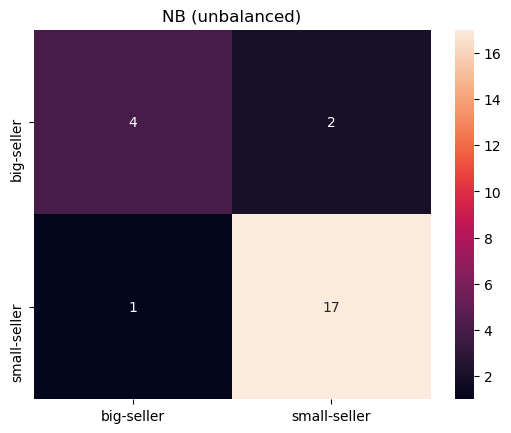

In [289]:
plt.title("NB (unbalanced)")
sn.heatmap(confusion_matrix(test_label, test_pred_nb_unb), annot=True, \
           xticklabels=["big-seller", "small-seller"], yticklabels=["big-seller", "small-seller"])
plt.show()

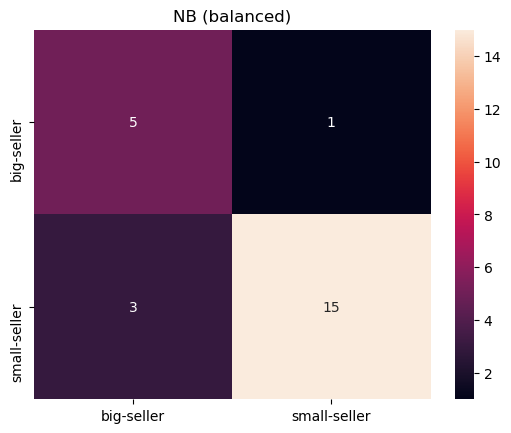

In [290]:
plt.title("NB (balanced)")
sn.heatmap(confusion_matrix(test_label, test_pred_nb_bal), annot=True, \
           xticklabels=["big-seller", "small-seller"], yticklabels=["big-seller", "small-seller"])
plt.show()

The performance for the combined models are really good, we choose the unbalanced case for future comparison due to the higher accuracy and f1-scores.

### Interpretation
Naive bayes classifiers, in general, can be interpreted by taking a look at the per-feature statistics that the model assigns: in the case of GaussianNB they are the mean and std of a gaussian distribution while for CategoricalNB are the feature probabilities.  
We will consider only the unbalanced case this time since it performs much better on the test set compared to the unbalanced one.

In [87]:
cnb_bal.feature_log_prob_

[array([[-3.8286414 , -1.1205912 , -2.03688193, -0.73759894, -3.8286414 ,
         -3.8286414 ],
        [-3.8501476 , -1.36524095, -1.21109027, -1.45225233, -1.90423745,
         -3.15700042]]),
 array([[-3.95124372, -1.64865863, -1.31218639, -3.25809654, -3.95124372,
         -2.85263143, -3.95124372, -1.87180218, -3.95124372, -1.87180218,
         -3.25809654, -3.95124372],
        [-3.97029191, -1.40534256, -1.57239664, -1.77306734, -3.27714473,
         -2.87167962, -3.27714473, -3.27714473, -2.87167962, -2.87167962,
         -3.27714473, -3.27714473]]),
 array([[-3.8501476 , -1.54756251, -1.1420974 , -3.15700042, -1.77070606,
         -2.75153531, -1.77070606],
        [-3.87120101, -1.30625165, -1.47330574, -1.67397643, -1.79175947,
         -2.77258872, -2.77258872]]),
 array([[-3.97029191, -1.66770682, -3.97029191, -2.58399755, -3.27714473,
         -2.58399755, -2.360854  , -1.89085037, -3.97029191, -2.58399755,
         -1.77306734, -3.97029191, -2.87167962],
        [-3.988

#### Numerical features (Global level)

In [88]:
gnb_unb.class_prior_

array([0.24074074, 0.75925926])

In [89]:
gnb_big_df = pd.DataFrame(gnb_unb.sigma_[0], index=num_train_set.columns, columns=["Variance"])
gnb_big_df.loc[:, "Mean"] = gnb_unb.theta_[0]
gnb_big_df

Variance      Mean
MaxValuePerOrder   2.774395  0.896802
AvgValuePerOrder   0.399330 -0.046080
AvgMemoryPerOrder  0.222077  0.279211
TotMonthBusiness   1.219530  0.926785
Eram               0.423491  1.096510
Egeo               0.316810 -0.043539
Ecur               0.683038 -0.083758

In [90]:
gnb_small_df = pd.DataFrame(gnb_unb.sigma_[1], index=num_train_set.columns, columns=["Variance"])
gnb_small_df.loc[:, "Mean"] = gnb_unb.theta_[1]
gnb_small_df

Variance      Mean
MaxValuePerOrder   0.153077 -0.353895
AvgValuePerOrder   0.455516 -0.206324
AvgMemoryPerOrder  0.616571 -0.329429
TotMonthBusiness   0.843143 -0.336082
Eram               0.884079 -0.350397
Egeo               1.416961  0.133868
Ecur               1.234809  0.080080

In example:

In [91]:
def plot_gaussian_feature(feature, title=None):
    
    mu1 = gnb_big_df.loc[feature, "Mean"]
    sigma1 = gnb_big_df.loc["MaxValuePerOrder", "Variance"]
    std1 = math.sqrt(sigma1)
    x1 = np.linspace(gnb_big_df.loc[feature, "Mean"] - 3*std1, mu1 + 3*std1, 100)

    mu2 = gnb_small_df.loc[feature, "Mean"]
    sigma2 = gnb_small_df.loc[feature, "Variance"]
    std2 = math.sqrt(sigma2)
    x2 = np.linspace(gnb_small_df.loc[feature, "Mean"] - 3*std2, mu2 + 3*std2, 100)

    if title != None:
        plt.title(title)
        
    else:
        plt.title(feature)
    
    plt.plot(x1, stats.norm.pdf(x1, mu1, std1), label=f"big-seller ({feature})")
    plt.plot(x2, stats.norm.pdf(x2, mu2, std2), label=f"small-seller ({feature})")
    
    plt.legend()

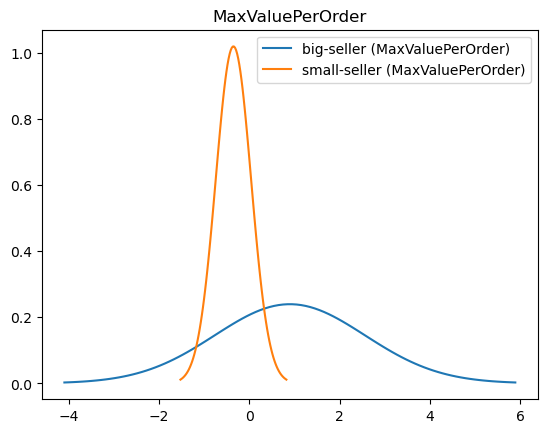

In [92]:
feature = "MaxValuePerOrder"
plot_gaussian_feature(feature)
plt.show()

We can see in this case that the conditional probability for a datapoint with value near 0 is higher for the small-seller label compared to big-seller, meaning that datapoints with features in this region are more likely to be small-seller (according to the model).

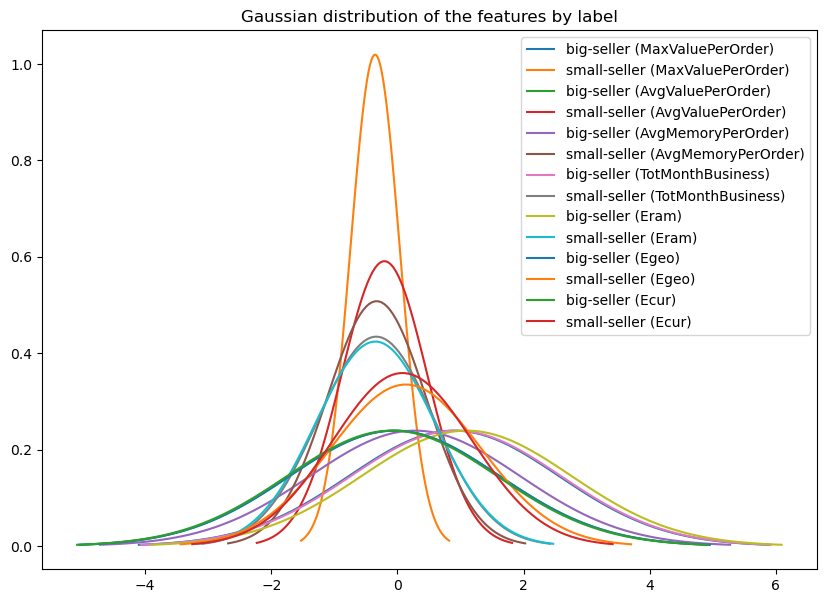

In [93]:
plt.figure(figsize=(10,7))

for feature in num_train_set.columns:

    plot_gaussian_feature(feature, "Gaussian distribution of the features by label")

plt.show()

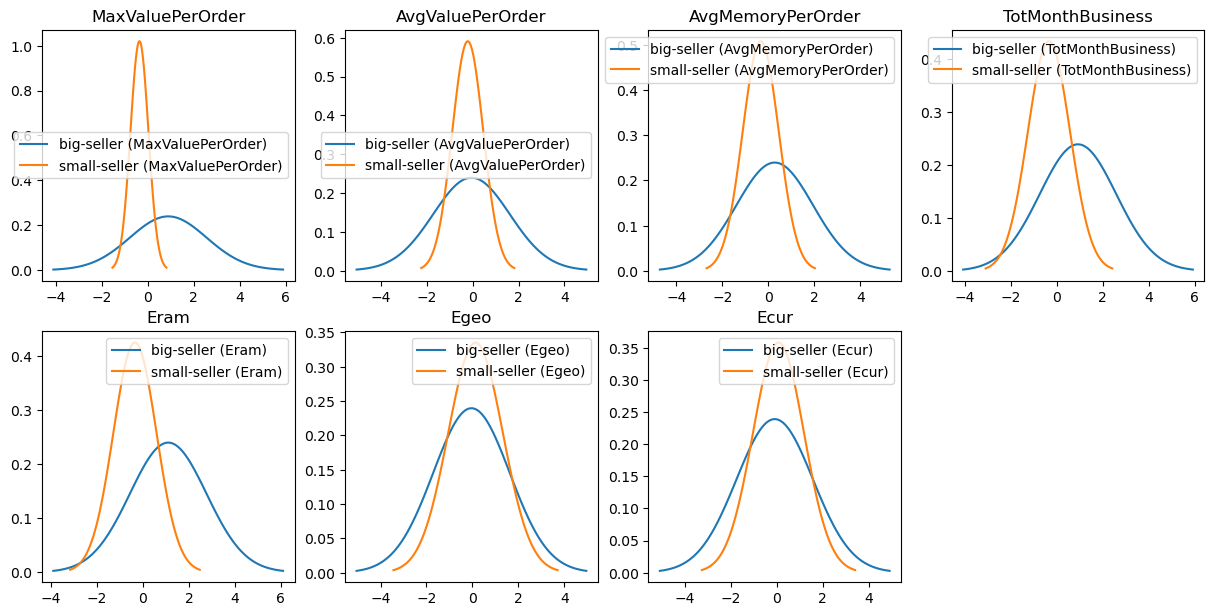

In [94]:
n_features = len(num_train_set.columns)

plt.figure(figsize=(15,15))
fig_dims = ((n_features+1)//2, 4)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i in range(n_features):

    plt.subplot2grid(fig_dims, (i//4, i%4))
    
    feature = num_train_set.columns[i]
    plot_gaussian_feature(feature)

plt.legend()
plt.show()

Here we can see all of different normal distributions used to compute the conditional probability.  
For example, the Egeo and Ecur distributions are almost overlapping, with small-seller having about the same mean but a lower std.  

While others, such as MaxValuePerOrder and TotMonthBusiness, show a clearer preference of the model for a label (depending on the feature value).

#### Numerical features (Instance level)

In [95]:
def construct_cond_prob_df(nb_model, data_point):
    
    gnb_cond_prob_df = pd.DataFrame(columns=["Cond. Prob. big", "Cond. Prob. small"], index=num_train_set.columns)
    
    big_seller_mean = nb_model.theta_[0]
    small_seller_mean = nb_model.theta_[1]
    
    big_seller_std = np.sqrt(nb_model.sigma_[0])
    small_seller_std = np.sqrt(nb_model.sigma_[1])
    
    for i in range(len(data_point)):
        df_index = gnb_cond_prob_df.iloc[i].name
        
        gnb_cond_prob_df.loc[df_index, "Cond. Prob. big"] = stats.norm.pdf(data_point[i], big_seller_mean[i], big_seller_std[i])
        gnb_cond_prob_df.loc[df_index, "Cond. Prob. small"] = stats.norm.pdf(data_point[i], small_seller_mean[i], small_seller_std[i])
    
    return gnb_cond_prob_df

Let's take a particular instance:

In [96]:
num_test_datapoint = num_test_set.iloc[0]
num_test_datapoint

MaxValuePerOrder     2.209395
AvgValuePerOrder    -0.314363
AvgMemoryPerOrder   -0.231588
TotMonthBusiness     0.514603
Eram                 1.451639
Egeo                -1.565545
Ecur                -1.273951
Name: (52, Newegg Marketplace), dtype: float64

In [97]:
gnb_unb.predict_proba(num_test_datapoint.values.reshape(1, -1))

array([[9.99999993e-01, 6.72733002e-09]])

It is classified as a big-seller by the nb model.  
The resulting label prediction must come from the product of the conditional probabilities and the class priors.  

Let's take a look:

In [98]:
gnb_cond_prob_df = construct_cond_prob_df(gnb_unb, num_test_datapoint.values)
gnb_cond_prob_df.sort_values("Cond. Prob. big", ascending=False)

Cond. Prob. big Cond. Prob. small
AvgValuePerOrder         0.576906          0.583572
Eram                     0.528228          0.067617
AvgMemoryPerOrder        0.470472          0.504135
TotMonthBusiness         0.336948          0.282868
MaxValuePerOrder         0.175581               0.0
Ecur                     0.171137          0.170882
Egeo                     0.018312          0.120962

In [99]:
prod_log_likelihood_big = -np.sum(np.log(np.asarray(gnb_cond_prob_df["Cond. Prob. big"])[0]))

print(f"Prob of instance being big seller: {prod_log_likelihood_big*gnb_unb.class_prior_[0]}")

Prob of instance being big seller: 0.4188058688188291


The results obtained roughly correspond to the ones obtained by the model.  
This way we can interpret the behaviour of the model for any specific instance and understand which features tipped the classification.

#### Categorical features
Here the model assign a probability to each value of each feature for every label.  
Using these probabilities we can explain the predictions of the model the same as in the numerical case, both at the global and instance level.

In [100]:
cnb_unb.feature_log_prob_

[array([[-2.94443898, -1.15267951, -1.55814462, -1.15267951, -2.94443898,
         -2.94443898],
        [-3.8501476 , -1.36524095, -1.21109027, -1.45225233, -1.90423745,
         -3.15700042]]),
 array([[-3.21887582, -2.52572864, -1.60943791, -2.52572864, -3.21887582,
         -2.12026354, -3.21887582, -2.12026354, -3.21887582, -2.12026354,
         -2.52572864, -3.21887582],
        [-3.97029191, -1.40534256, -1.57239664, -1.77306734, -3.27714473,
         -2.87167962, -3.27714473, -3.27714473, -2.87167962, -2.87167962,
         -3.27714473, -3.27714473]]),
 array([[-2.99573227, -2.30258509, -1.38629436, -2.30258509, -1.60943791,
         -1.89711998, -1.89711998],
        [-3.87120101, -1.30625165, -1.47330574, -1.67397643, -1.79175947,
         -2.77258872, -2.77258872]]),
 array([[-3.25809654, -1.87180218, -3.25809654, -2.15948425, -2.56494936,
         -2.56494936, -2.56494936, -2.15948425, -3.25809654, -2.56494936,
         -2.56494936, -3.25809654, -2.56494936],
        [-3.988

## K-Nearest Neighbour

### Parameter search and fitting
As usual we perform a grid search to find the optimal parameters, regarding the number of neighbours to query we however decided to use the sqrt(number of features) heuristic.

In [212]:
sqrt_num_feat = int(np.ceil(np.sqrt(pred_df.shape[1])))

#### Unbalanced classes

In [211]:
# define the parameters' values you want to try
param_dist_knn = {
    'n_neighbors': [sqrt_num_feat],
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance']
            }
#define the model
clf = KNeighborsClassifier()
#define the grid search
grid_search_knn_unb = GridSearchCV(clf, param_grid=param_dist_knn,
                            n_jobs=-1,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_knn_unb.fit(train_set, train_label)

print('Best settings parameters ', grid_search_knn_unb.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_knn_unb.cv_results_['mean_test_score'][0], 
      grid_search_knn_unb.cv_results_['std_test_score'][0])


knn_unb = KNeighborsClassifier(**grid_search_knn_unb.best_params_).fit(train_set, train_label)

test_pred_knn_unb = knn_unb.predict(test_set)
test_pred_proba_knn_unb = knn_unb.predict_proba(test_set)

Best settings parameters  {'algorithm': 'ball_tree', 'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
Setting's accuracy score mean and std  0.7963636363636363 0.035255853508482406


#### Balanced classes

In [213]:
#define the parameters' values you want to try
param_dist_knn = {
    'n_neighbors': [sqrt_num_feat],
    'metric': ['euclidean', 'manhattan'],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance']
            }
#define the model
clf = KNeighborsClassifier()
#define search
grid_search_knn_bal = RandomizedSearchCV(clf, param_distributions=param_dist_knn,
                            n_jobs=-1,
                            n_iter=12,
                            scoring=make_scorer(accuracy_score))
#run the search
grid_search_knn_bal.fit(train_set_bal, train_label_bal)

print('Best settings parameters ', grid_search_knn_bal.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_knn_bal.cv_results_['mean_test_score'][0], 
      grid_search_knn_bal.cv_results_['std_test_score'][0])

#Actual model fitting
knn_bal = KNeighborsClassifier(**grid_search_knn_bal.best_params_).fit(train_set_bal, train_label_bal)

test_pred_knn_bal = knn_bal.predict(test_set)
test_pred_proba_knn_bal = knn_bal.predict_proba(test_set)

Best settings parameters  {'weights': 'uniform', 'n_neighbors': 7, 'metric': 'euclidean', 'algorithm': 'ball_tree'}
Setting's accuracy score mean and std  0.6669117647058823 0.1602637585929492


### Evaluation

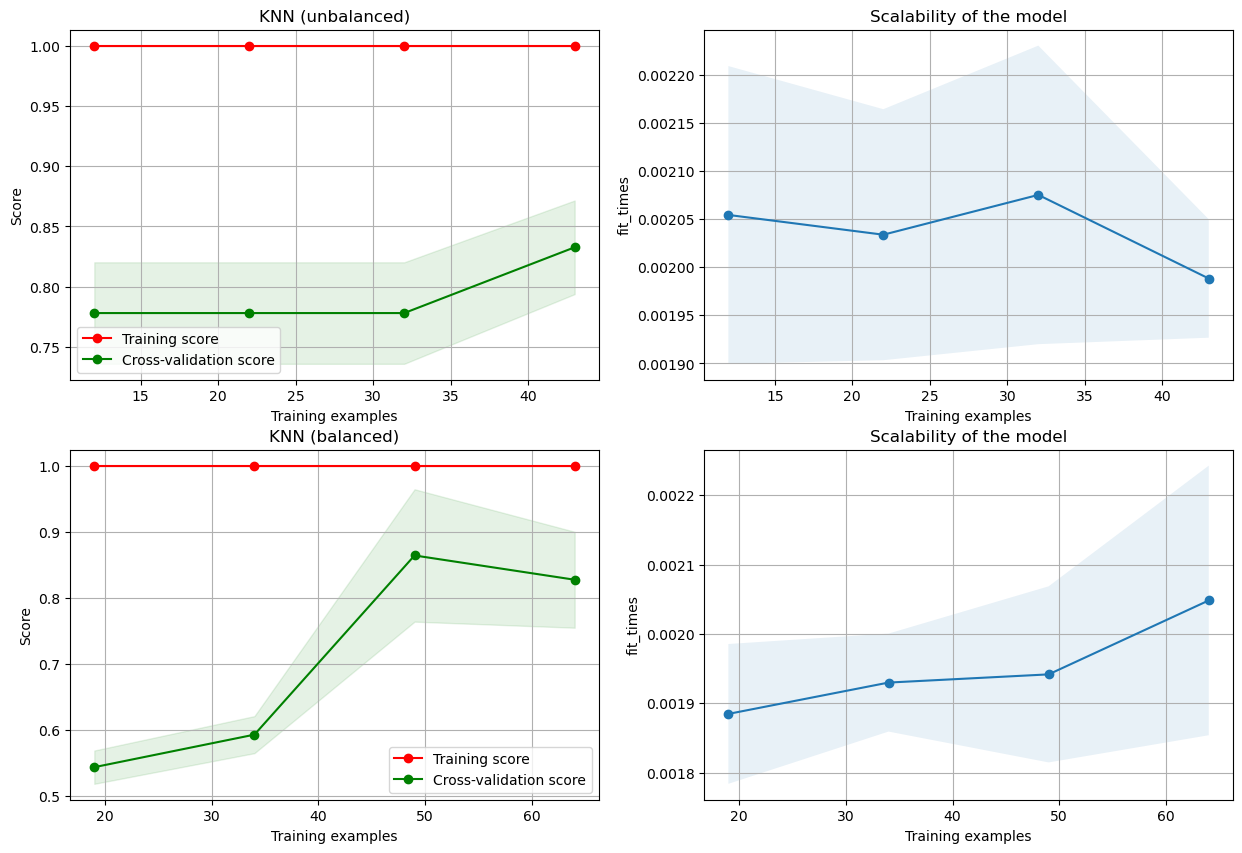

In [214]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plot_learning_curve(knn_unb, "KNN (unbalanced)", train_set, train_label, ax=axes[0], train_sizes=np.linspace(0.3, 1, 4))
plot_learning_curve(knn_bal, "KNN (balanced)", train_set_bal, train_label_bal, ax=axes[1], train_sizes=np.linspace(0.3, 1, 4))

plt.show()

In [215]:
print("KNN (unbalanced)")
report_scores(test_label,test_pred_knn_unb)
print("\n")
print("KNN (balanced)")
report_scores(test_label,test_pred_knn_bal)

KNN (unbalanced)
              precision    recall  f1-score   support

  big-seller       1.00      0.33      0.50         6
small-seller       0.82      1.00      0.90        18

    accuracy                           0.83        24
   macro avg       0.91      0.67      0.70        24
weighted avg       0.86      0.83      0.80        24



KNN (balanced)
              precision    recall  f1-score   support

  big-seller       0.45      0.83      0.59         6
small-seller       0.92      0.67      0.77        18

    accuracy                           0.71        24
   macro avg       0.69      0.75      0.68        24
weighted avg       0.81      0.71      0.73        24



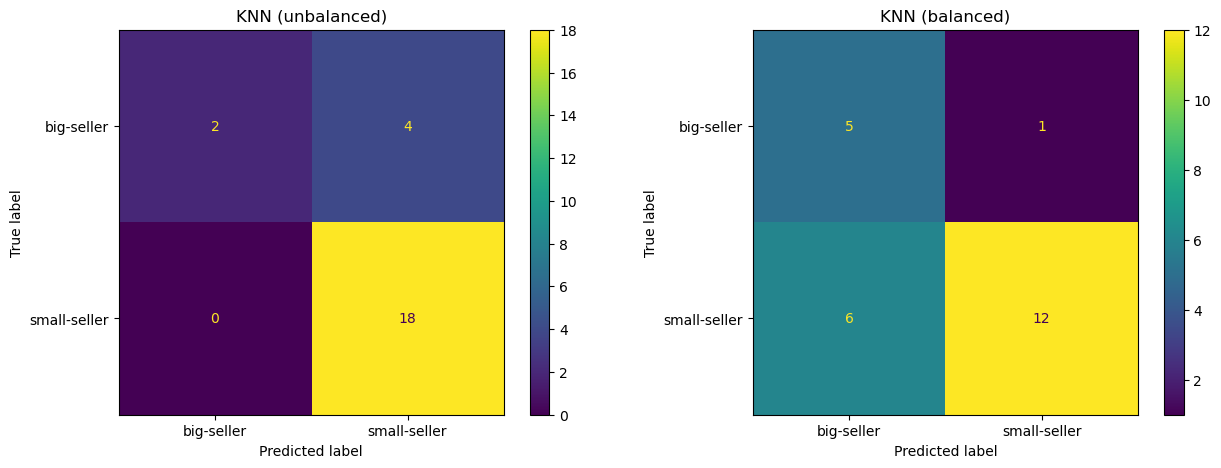

In [187]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

axes[0].set_title("KNN (unbalanced)")
plot_confusion_matrix(knn_unb, test_set, test_label, ax=axes[0])
axes[1].set_title("KNN (balanced)")
plot_confusion_matrix(knn_bal, test_set, test_label, ax=axes[1])
plt.show() 

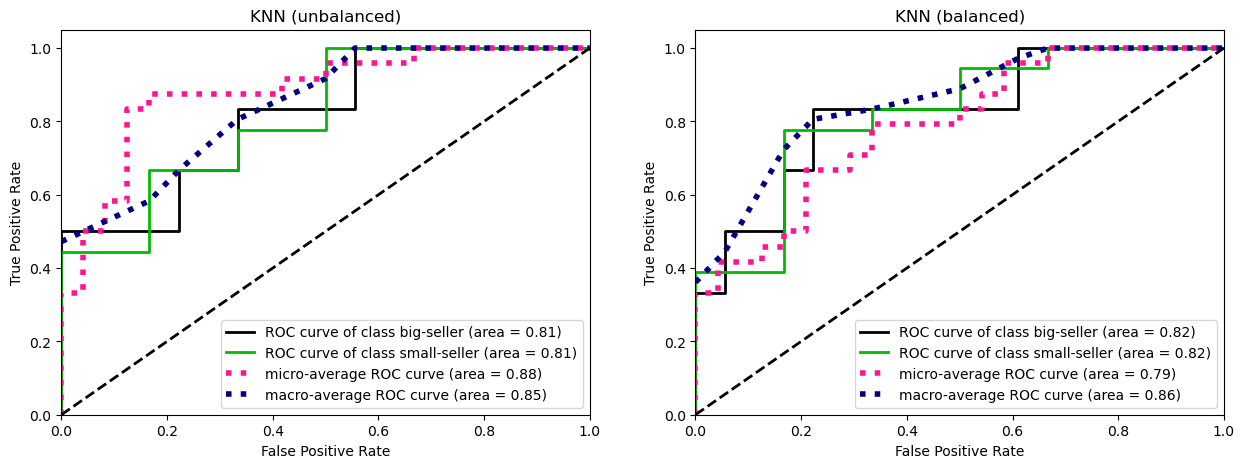

In [106]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

skplt.metrics.plot_roc(test_label.values, test_pred_proba_knn_unb, title="KNN (unbalanced)", ax=axes[0])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_knn_bal, title="KNN (balanced)", ax=axes[1])
plt.show()

We can see that, in this case, KNN with a balanced number of instances has  overall worse results, the model trained on the unbalanced dataset is the winner in terms of accuracy and f1-scores.  
However note that, in the context of big-seller, the balanced model has a higher recall making it more useful if we are more concerned with erroneously classifying a big-seller as a small-seller.

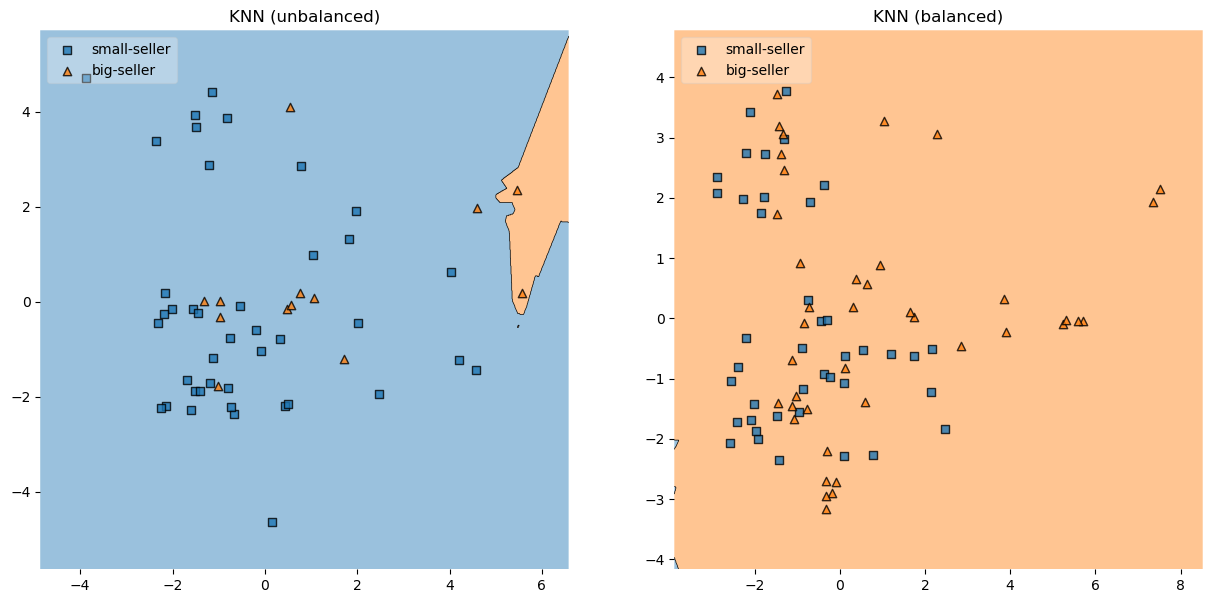

In [216]:
plot_decision_boundary([train_set, train_set_bal], [train_label, train_label_bal], \
                       [knn_unb, knn_bal], ["KNN (unbalanced)", "KNN (balanced)"])

The K-NN decision boundary is much more flexible compared to the ones previously noted, this is because it's shape is determined by the datapoint's immediate neighbourhood in the training set.

### Interpretability
The model is inherently local so it is not possible to explain its global behaviour.  
If we have few enough features, however, we can analyse what are the reasons for its classification by studying the instance's neighbours.

In [217]:
test_entry = test_set.iloc[0]
neigh_id = knn_unb.kneighbors(test_entry.values.reshape(1, -1))[1][0]

knn_unb.kneighbors(test_entry.values.reshape(1, -1))

(array([[5.25845524, 5.80840008, 6.23727117, 6.52126622, 6.59724642,
         6.8985111 , 6.95050244]]),
 array([[48, 33, 27,  9, 47,  8,  6]]))

These are the distances from test_entry to its nearest neighbours.

In [219]:
knn_results = pd.concat([train_set.iloc[neigh_id], train_label.iloc[neigh_id]], axis=1)
knn_results

MaxValuePerOrder  AvgValuePerOrder  \
vendor_code name                                                      
49          Newegg Business              0.220111          0.528521   
27          Dell Small Business         -0.739437         -0.637757   
14          Best Buy                    -0.474712         -0.585873   
78          SuperBiiz                   -0.509966         -1.006915   
47          Newegg                       0.371383         -0.445508   
28          Directron                   -0.020263         -1.307621   
2           Adorama                      0.090633         -0.569198   

                                 AvgMemoryPerOrder  TotMonthBusiness  \
vendor_code name                                                       
49          Newegg Business               0.849930         -1.336469   
27          Dell Small Business          -1.130140          0.612028   
14          Best Buy                      0.217479          0.709453   
78          SuperBiiz                    -0.559073          0.709453   
47          Newegg                        0.607522          0.709453   
28          Directron                    -1.250900          0.612028   
2           Adorama                      -0.308858          0.222328   

                                     Eram      Egeo      Ecur  \
vendor_code name                                                
49          Newegg Business      1.337679 -1.565545 -1.273951   
27          Dell Small Business -2.303280 -1.565545 -1.273951   
14          Best Buy            -0.421930 -1.565545 -1.273951   
78          SuperBiiz           -0.112836 -1.565545 -1.273951   
47          Newegg               1.775138 -1.565545 -1.273951   
28          Directron            0.346954 -1.565545 -1.273951   
2           Adorama              0.088941 -1.565545 -1.273951   

                                 TopBrand_CORSAIR  TopBrand_CRUCIAL  \
vendor_code name                                                      
49          Newegg Business             -0.727607         -0.313993   
27          Dell Small Business         -0.727607         -0.313993   
14          Best Buy                     1.374369         -0.313993   
78          SuperBiiz                   -0.727607         -0.313993   
47          Newegg                      -0.727607         -0.313993   
28          Directron                   -0.727607          3.184785   
2           Adorama                     -0.727607          3.184785   

                                 TopBrand_G.SKILL  ...  TopSalesMonth_12.0  \
vendor_code name                                   ...                       
49          Newegg Business              1.647509  ...           -0.261712   
27          Dell Small Business         -0.606977  ...           -0.261712   
14          Best Buy                    -0.606977  ...           -0.261712   
78          SuperBiiz                   -0.606977  ...           -0.261712   
47          Newegg                       1.647509  ...           -0.261712   
28          Directron                   -0.606977  ...           -0.261712   
2           Adorama                     -0.606977  ...           -0.261712   

                                 TopSalesMonth_8.0  TopSalesMonth_1.0  \
vendor_code name                                                        
49          Newegg Business              -0.232495          -0.361158   
27          Dell Small Business          -0.232495          -0.361158   
14          Best Buy                     -0.232495          -0.361158   
78          SuperBiiz                    -0.232495           2.768875   
47          Newegg                       -0.232495          -0.361158   
28          Directron                    -0.232495          -0.361158   
2           Adorama                      -0.232495          -0.361158   

                                 TopSalesMonth_7.0  TopSalesMonth_10.0  \
vendor_code name                                                         
49       

We can see that all of the instance's closest neighbours in the training set are small-sellers (apart from Newegg), explaining the model decisions.

## Rule-based classification (Ripper)

In [220]:
#Ripper's fit method requires a single containing the labels
rip_data_unb = pd.concat([train_set, train_label], axis=1)
rip_data_bal = pd.concat([train_set_bal, train_label_bal], axis=1)

### Unbalanced

In [221]:
clf = RIPPER()

param_grid_rip = {"prune_size": np.linspace(0.1, 1, 10), 
              "k": range(2, 10)}

grid_search_rip_unb = RandomizedSearchCV(estimator=clf, 
                                     n_iter=50,
                                     param_distributions=param_grid_rip)

grid_search_rip_unb.fit(train_set, train_label, pos_class="big-seller")

print('Best parameters setting ', grid_search_rip_unb.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_rip_unb.cv_results_['mean_test_score'][0], 
      grid_search_rip_unb.cv_results_['std_test_score'][0])


#define and fit the rule-based model
ripper_unb = RIPPER(**grid_search_rip_unb.best_params_)
ripper_unb.fit(rip_data_unb, class_feat='Label', pos_class="big-seller")

test_pred_rip_unb = ripper_unb.predict(test_set, give_reasons=True)
test_pred_proba_rip_unb = ripper_unb.predict_proba(test_set)

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Rules

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Rules

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.



Best parameters setting  {'prune_size': 0.2, 'k': 5}
Setting's accuracy score mean and std  0.7436363636363637 0.13141317090612842


### Balanced

In [222]:
clf = RIPPER()

param_grid_rip = {"prune_size": np.linspace(0.1, 1, 10), 
              "k": range(2, 10)}

grid_search_rip_bal = RandomizedSearchCV(estimator=clf, 
                                     n_iter=50,
                                     param_distributions=param_grid_rip)

grid_search_rip_bal.fit(train_set_bal, train_label_bal, pos_class="big-seller")

print('Best parameters setting ', grid_search_rip_bal.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_rip_bal.cv_results_['mean_test_score'][0], 
      grid_search_rip_bal.cv_results_['std_test_score'][0])


#define and fit the rule-based model
ripper_bal = RIPPER(**grid_search_rip_bal.best_params_)
ripper_bal.fit(rip_data_unb, class_feat='Label', pos_class="big-seller")

test_pred_rip_bal = ripper_bal.predict(test_set, give_reasons=True)
test_pred_proba_rip_bal = ripper_bal.predict_proba(test_set)

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Rules

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

base.py: .predict | base.py: ._check_allpos_allneg: RuntimeWarning: 
Ruleset is empty. All predictions it makes with method .predict will be negative. It may be untrained or was trained on a dataset split lacking positive examples.

ripper.py: .fit | base.py: ._check_allpos_allneg: RuntimeWarning: 
Rules

Best parameters setting  {'prune_size': 0.8, 'k': 8}
Setting's accuracy score mean and std  0.5941176470588235 0.1449219751891809


base.py: .predict_proba: RuntimeWarning: 
Some examples lacked any rule with sufficient sample size to predict_proba: [0]
 Consider running recalibrate_proba with smaller param min_samples, or set require_min_samples=False



### Evaluation

In [223]:
#Ripper's implementation doesn't output the vendor label but true or false
train_label_rip = train_label.replace({"big-seller":True, "small-seller":False})
train_label_bal_rip = train_label_bal.replace({"big-seller":True, "small-seller":False})
test_label_rip = test_label.replace({"big-seller":True, "small-seller":False})

In [224]:
print("Ripper (unbalanced)")
print(classification_report(test_label_rip, test_pred_rip_unb[0], target_names=['small-seller', 'big-seller']))
print("\n")
print("Ripper (balanced)")
print(classification_report(test_label_rip, test_pred_rip_bal[0], target_names=['small-seller', 'big-seller']))

Ripper (unbalanced)
              precision    recall  f1-score   support

small-seller       0.82      0.50      0.62        18
  big-seller       0.31      0.67      0.42         6

    accuracy                           0.54        24
   macro avg       0.56      0.58      0.52        24
weighted avg       0.69      0.54      0.57        24



Ripper (balanced)
              precision    recall  f1-score   support

small-seller       0.75      0.67      0.71        18
  big-seller       0.25      0.33      0.29         6

    accuracy                           0.58        24
   macro avg       0.50      0.50      0.50        24
weighted avg       0.62      0.58      0.60        24



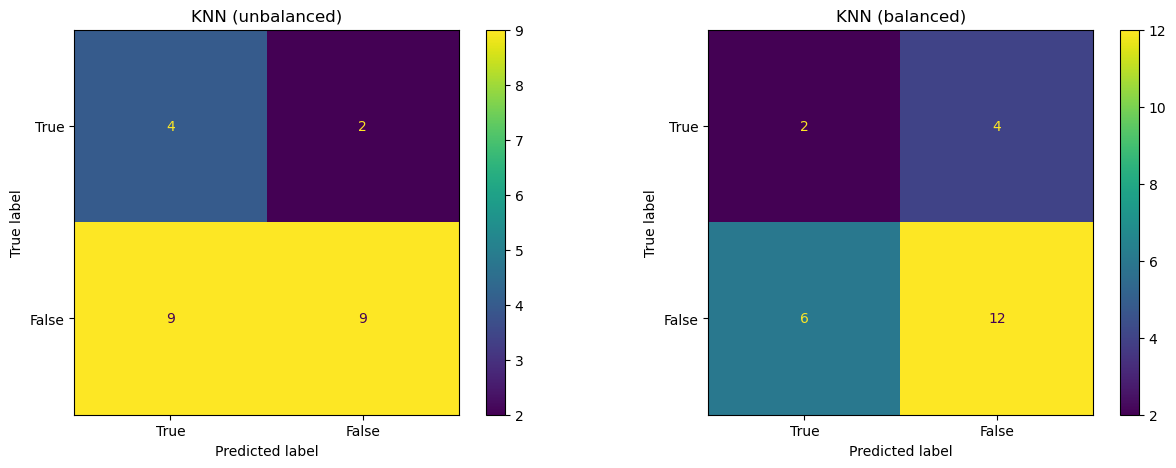

In [234]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

axes[0].set_title("KNN (unbalanced)")
plot_confusion_matrix(ripper_unb, test_set, test_label_rip, ax=axes[0], labels=(True, False))
axes[1].set_title("KNN (balanced)")
plot_confusion_matrix(ripper_bal, test_set, test_label_rip, ax=axes[1], labels=(True, False))
plt.show() 

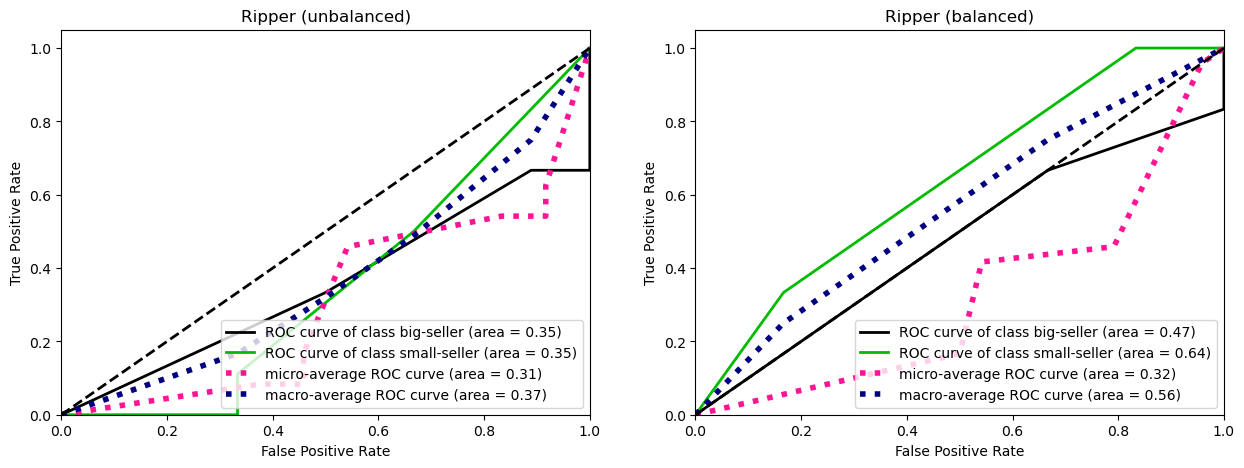

In [235]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

skplt.metrics.plot_roc(test_label.values, test_pred_proba_rip_unb, title="Ripper (unbalanced)", ax=axes[0])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_rip_bal, title="Ripper (balanced)", ax=axes[1])
plt.show()

Ripper in general doesn't perform too well on this dataset, the unbalanced case performs worse than a random classifier as it can be seen from the ROC.  

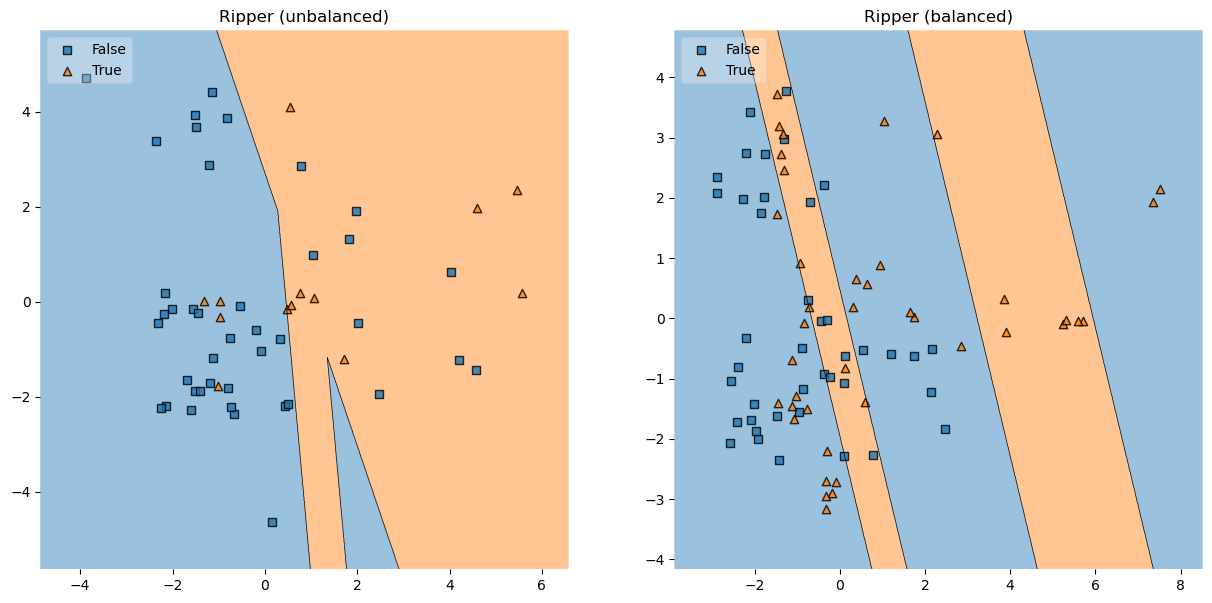

In [229]:
plot_decision_boundary([train_set, train_set_bal], [train_label_rip, train_label_bal_rip], \
                       [ripper_unb, ripper_bal], ["Ripper (unbalanced)", "Ripper (balanced)"], label_dict={True:1, False:0})

### Interpretation
Ripper already gives us the rules used to classify the datapoints and is also able to justify for each entry which rules it used to come to its conclusions.

#### Unbalanced classes

In [230]:
print(ripper_unb.ruleset_)

[MaxValuePerOrder=0.37-5.78] V [Eram=0.15-0.4] V [MaxValuePerOrder=0.22-0.37]


In [231]:
test_pred_rip_unb[1]

[[<Rule [MaxValuePerOrder=0.37-5.78]>],
 [],
 [],
 [],
 [],
 [<Rule [Eram=0.15-0.4]>],
 [<Rule [MaxValuePerOrder=0.37-5.78]>, <Rule [Eram=0.15-0.4]>],
 [],
 [],
 [<Rule [MaxValuePerOrder=0.37-5.78]>],
 [],
 [<Rule [Eram=0.15-0.4]>],
 [<Rule [Eram=0.15-0.4]>, <Rule [MaxValuePerOrder=0.22-0.37]>],
 [],
 [<Rule [MaxValuePerOrder=0.22-0.37]>],
 [],
 [<Rule [MaxValuePerOrder=0.22-0.37]>],
 [],
 [<Rule [MaxValuePerOrder=0.22-0.37]>],
 [<Rule [Eram=0.15-0.4]>],
 [],
 [<Rule [MaxValuePerOrder=0.22-0.37]>],
 [<Rule [MaxValuePerOrder=0.37-5.78]>, <Rule [Eram=0.15-0.4]>],
 [<Rule [Eram=0.15-0.4]>]]

#### Balanced classes

In [232]:
print(ripper_bal.ruleset_)

[Eram=1.34-2.17] V [Eram=0.15-0.4]


In [236]:
test_pred_rip_bal[1]

[[<Rule [Eram=1.34-2.17]>],
 [],
 [],
 [],
 [],
 [<Rule [Eram=0.15-0.4]>],
 [<Rule [Eram=0.15-0.4]>],
 [],
 [],
 [],
 [],
 [<Rule [Eram=0.15-0.4]>],
 [<Rule [Eram=0.15-0.4]>],
 [],
 [],
 [],
 [],
 [],
 [],
 [<Rule [Eram=0.15-0.4]>],
 [],
 [],
 [<Rule [Eram=0.15-0.4]>],
 [<Rule [Eram=0.15-0.4]>]]

# Black-box models
In this section we analyse the results from models that are not interpretable by design.  
They usually provide better performance, unfortunately this can come at a cost for immediate interpretability.  

We will use the dalex python library to aid us in interpreting the models.

In [237]:
test_label_exp = test_label.replace({"big-seller":1, "small-seller":0})

While sklearn encodes the target values to numbers on its own dalex needs help.

## Random forest

In [238]:
random_state_rf = 0

### Unbalanced

In [239]:
#define the parameters' values you want to try
param_dist = {"n_estimators": range(5, 50, 5), 
              "criterion": ['gini', 'entropy'],
              "max_features": range(1, 10),
              "max_depth": range(1, 10), 
              "min_samples_split": range(2, 10),
              "min_samples_leaf": range(1, 10),
              "bootstrap": [True],
              "random_state": [random_state_rf]}

#define the model
clf = RandomForestClassifier()
#define the grid search
grid_search_rf_unb = RandomizedSearchCV(clf, param_distributions=param_dist,
                            n_jobs=-1,
                            n_iter=500,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_rf_unb.fit(train_set, train_label)

print('Best settings parameters ', grid_search_rf_unb.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_rf_unb.cv_results_['mean_test_score'][0], 
      grid_search_rf_unb.cv_results_['std_test_score'][0])


rf_unb = RandomForestClassifier(**grid_search_rf_unb.best_params_) 
rf_unb = rf_unb.fit(train_set, train_label)

test_pred_rf_unb = rf_unb.predict(test_set)
test_pred_proba_rf_unb = rf_unb.predict_proba(test_set)

Best settings parameters  {'random_state': 0, 'n_estimators': 45, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 5, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': True}
Setting's accuracy score mean and std  0.7618181818181818 0.0898851425040602


### Balanced

In [240]:
#define the parameters' values you want to try
param_dist = {"n_estimators": range(5, 50, 5), 
              "criterion": ['gini', 'entropy'],
              "max_features": range(1, 10),
              "max_depth": range(1, 10), 
              "min_samples_split": range(2, 10),
              "min_samples_leaf": range(1, 10),
              "bootstrap": [True],
              "random_state": [random_state_rf]}

#define the model
clf = RandomForestClassifier()
#define the grid search
grid_search_rf_bal = RandomizedSearchCV(clf, param_distributions=param_dist,
                            n_jobs=-1,
                            n_iter=500,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_rf_bal.fit(train_set, train_label)

print('Best settings parameters ', grid_search_rf_bal.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_rf_bal.cv_results_['mean_test_score'][0], 
      grid_search_rf_bal.cv_results_['std_test_score'][0])


rf_bal = RandomForestClassifier(**grid_search_rf_bal.best_params_) 
rf_bal = rf_bal.fit(train_set_bal, train_label_bal)

test_pred_rf_bal = rf_bal.predict(test_set)
test_pred_proba_rf_bal = rf_bal.predict_proba(test_set)

Best settings parameters  {'random_state': 0, 'n_estimators': 15, 'min_samples_split': 9, 'min_samples_leaf': 6, 'max_features': 5, 'max_depth': 8, 'criterion': 'entropy', 'bootstrap': True}
Setting's accuracy score mean and std  0.76 0.0404928317296729


### Balanced with class_weight

In [242]:
#define the parameters' values you want to try
param_dist = {"n_estimators": range(5, 50, 5),
              "criterion": ['gini', 'entropy'],
              "max_features": range(1, 10),
              "max_depth": range(1, 10), 
              "min_samples_split": range(2, 10),
              "min_samples_leaf": range(1, 10),
              "bootstrap": [True], 
              "class_weight": ["balanced"],
              "random_state": [random_state_rf]}

#define the model
clf = RandomForestClassifier()
#define the grid search
grid_search_rf_wei = RandomizedSearchCV(clf, param_distributions=param_dist,
                            n_jobs=-1,
                            n_iter=500,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_rf_wei.fit(train_set, train_label)

print('Best settings parameters ', grid_search_rf_wei.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_rf_wei.cv_results_['mean_test_score'][0], 
      grid_search_rf_wei.cv_results_['std_test_score'][0])


rf_wei = RandomForestClassifier(**grid_search_rf_wei.best_params_) 
rf_wei = rf_wei.fit(train_set, train_label)

test_pred_rf_wei = rf_wei.predict(test_set)
test_pred_proba_rf_wei = rf_wei.predict_proba(test_set)

Best settings parameters  {'random_state': 0, 'n_estimators': 20, 'min_samples_split': 7, 'min_samples_leaf': 7, 'max_features': 5, 'max_depth': 3, 'criterion': 'gini', 'class_weight': 'balanced', 'bootstrap': True}
Setting's accuracy score mean and std  0.7581818181818182 0.12538865199684848


### Evaluation

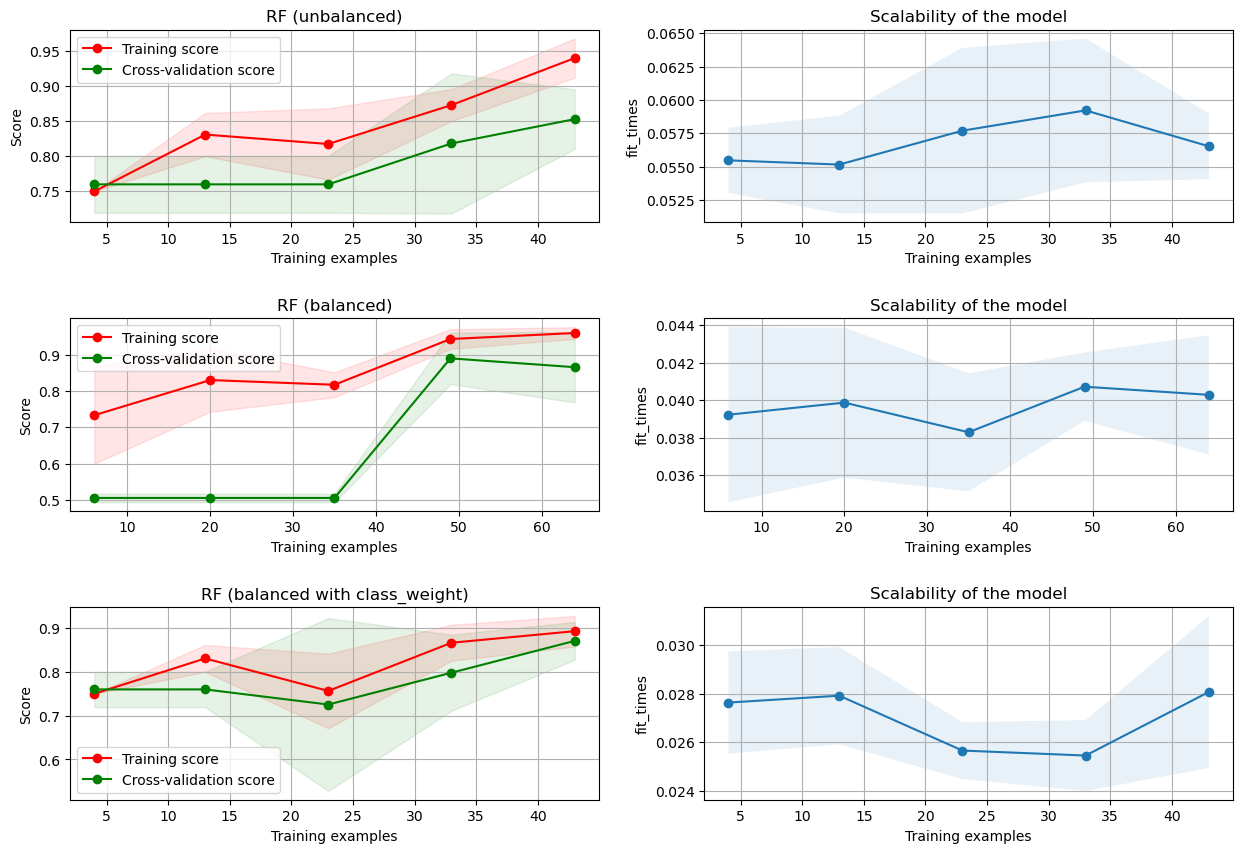

In [243]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

plot_learning_curve(rf_unb, "RF (unbalanced)", train_set, train_label, ax=axes[0])
plot_learning_curve(rf_bal, "RF (balanced)", train_set_bal, train_label_bal, ax=axes[1])
plot_learning_curve(rf_wei, "RF (balanced with class_weight)", train_set, train_label, ax=axes[2])

plt.show()

In [244]:
print("RF (unbalanced)")
report_scores(test_label, test_pred_rf_unb)
print("\n")
print("RF (balanced)")
report_scores(test_label, test_pred_rf_bal)
print("\n")
print("RF (balanced with class_weight)")
report_scores(test_label, test_pred_rf_wei)

RF (unbalanced)
              precision    recall  f1-score   support

  big-seller       0.75      0.50      0.60         6
small-seller       0.85      0.94      0.89        18

    accuracy                           0.83        24
   macro avg       0.80      0.72      0.75        24
weighted avg       0.82      0.83      0.82        24



RF (balanced)
              precision    recall  f1-score   support

  big-seller       0.71      0.83      0.77         6
small-seller       0.94      0.89      0.91        18

    accuracy                           0.88        24
   macro avg       0.83      0.86      0.84        24
weighted avg       0.88      0.88      0.88        24



RF (balanced with class_weight)
              precision    recall  f1-score   support

  big-seller       0.46      1.00      0.63         6
small-seller       1.00      0.61      0.76        18

    accuracy                           0.71        24
   macro avg       0.73      0.81      0.70        24
weighted

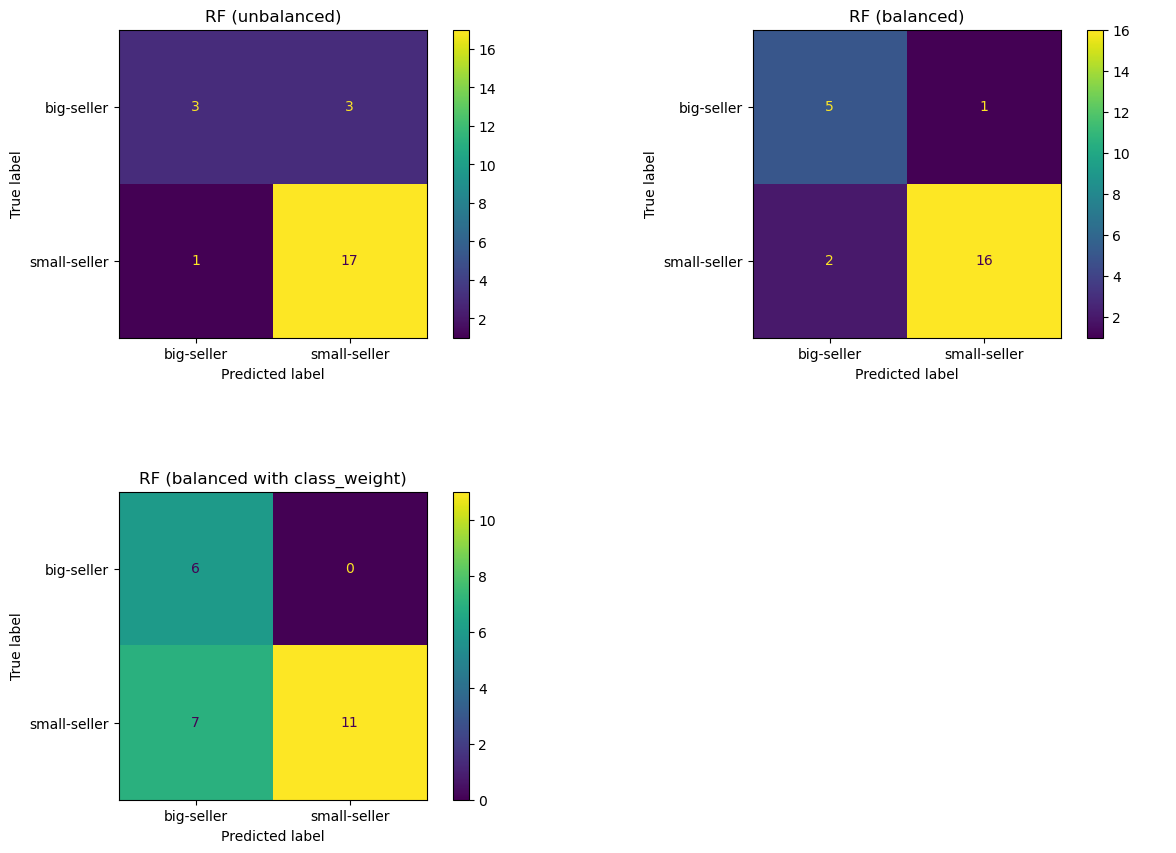

In [245]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

axes[0][0].set_title("RF (unbalanced)")
plot_confusion_matrix(rf_unb, test_set, test_label, ax=axes[0][0])
axes[0][1].set_title("RF (balanced)")
plot_confusion_matrix(rf_bal, test_set, test_label, ax=axes[0][1])
axes[1][0].set_title("RF (balanced with class_weight)")
plot_confusion_matrix(rf_wei, test_set, test_label, ax=axes[1][0])
axes[1][1].axis("off")

plt.show() 

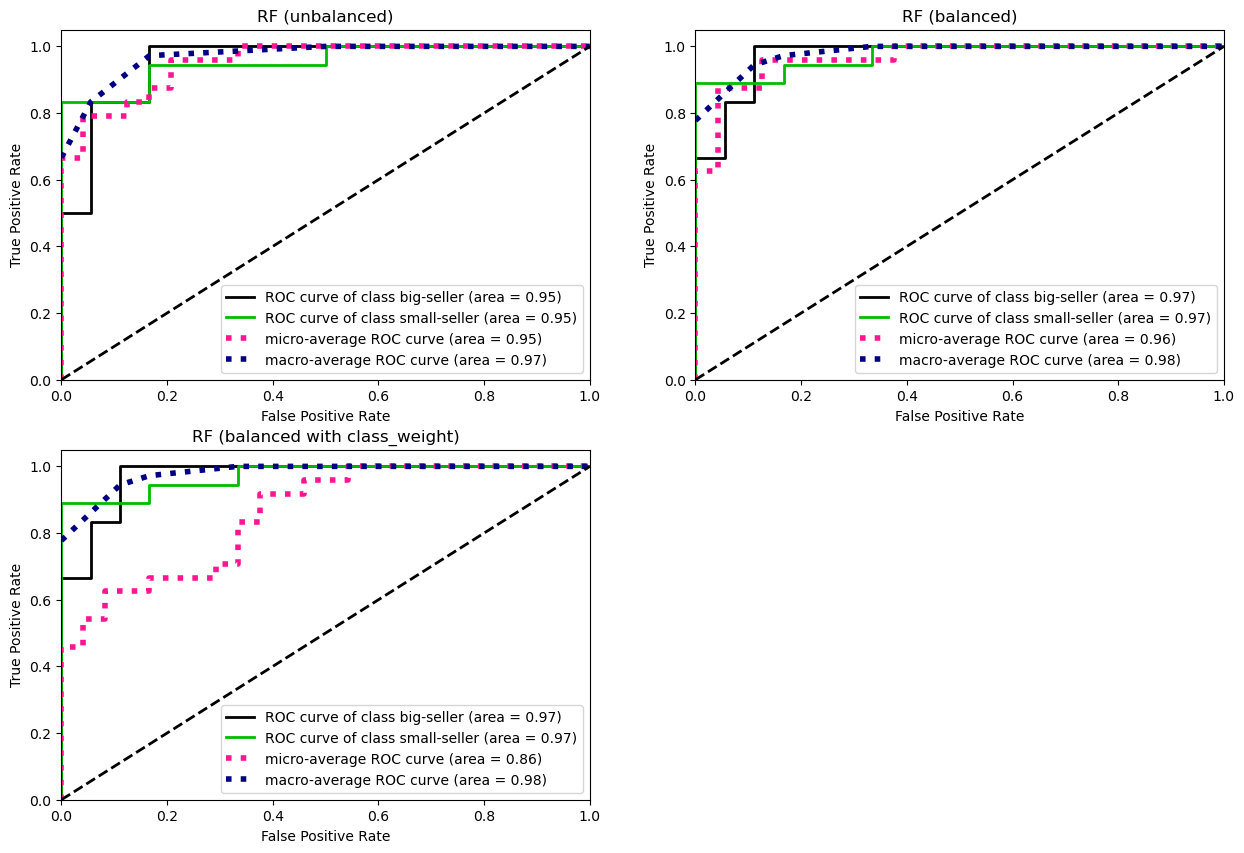

In [246]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

skplt.metrics.plot_roc(test_label.values, test_pred_proba_rf_unb, title="RF (unbalanced)", ax=axes[0][0])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_rf_bal, title="RF (balanced)", ax=axes[0][1])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_rf_wei, title="RF (balanced with class_weight)", ax=axes[1][0])
axes[1][1].axis("off")

plt.show()

The balanced model offers better performances, both in accuracy and in f1-scores compared to the other models.

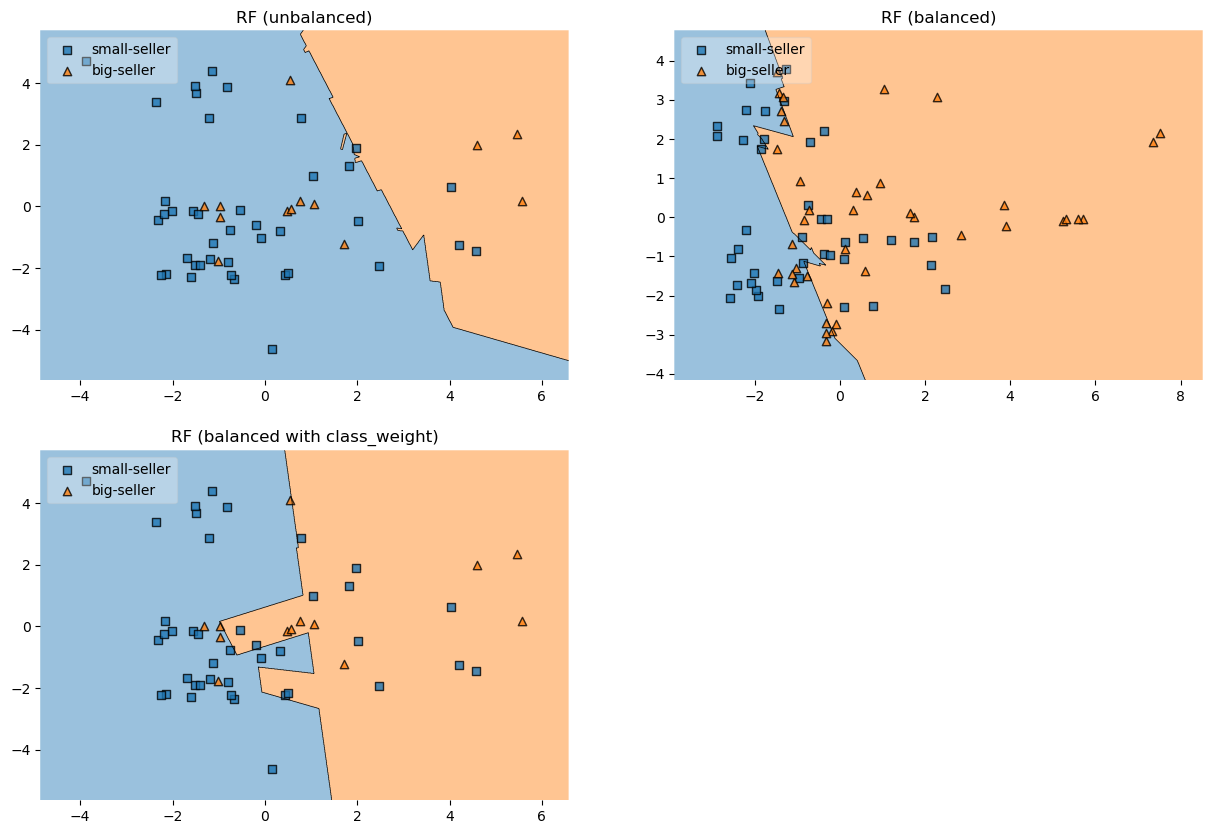

In [248]:
plot_decision_boundary([train_set, train_set_bal, train_set], [train_label, train_label_bal, train_label], \
                       [rf_unb, rf_bal, rf_wei], \
                       ["RF (unbalanced)", "RF (balanced)", "RF (balanced with class_weight)"])

### Interpretation

In [ ]:
Stop here

## SVM
We will consider two different kernels (linear and rbf) and compare their performance.

### Linear

#### Unbalanced

In [249]:
#define the parameters' values you want to try
param_dist_svm_lin = {
    'kernel': ["linear"],
    'probability': [True],
    'gamma': ["scale"],
    'C': np.linspace(0.01, 1000, 1000)
}

#define the model
clf = SVC()
#define the grid search
grid_search_svm_lin_unb = RandomizedSearchCV(clf, param_distributions=param_dist_svm_lin,
                            n_jobs=-1,
                            n_iter=500,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_svm_lin_unb.fit(train_set, train_label)

print('Best settings parameters ', grid_search_svm_lin_unb.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_svm_lin_unb.cv_results_['mean_test_score'][0], 
      grid_search_svm_lin_unb.cv_results_['std_test_score'][0])


svm_lin_unb = SVC(**grid_search_svm_lin_unb.best_params_)
svm_lin_unb.fit(train_set, train_label)

test_pred_proba_svm_lin_unb = svm_lin_unb.predict_proba(test_set)
test_pred_svm_lin_unb = svm_lin_unb.predict(test_set)

Best settings parameters  {'probability': True, 'kernel': 'linear', 'gamma': 'scale', 'C': 533.5381981981982}
Setting's accuracy score mean and std  0.78 0.16727272727272727


#### Balanced

In [250]:
#define the parameters' values you want to try
param_dist_svm_lin = {
    'kernel': ["linear"],
    'probability': [True],
    'gamma': ["scale"],
    'C': np.linspace(0.01, 1000, 1000)
}

#define the model
clf = SVC()
#define the grid search
grid_search_svm_lin_bal = RandomizedSearchCV(clf, param_distributions=param_dist_svm_lin,
                            n_jobs=-1,
                            n_iter=500,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_svm_lin_bal.fit(train_set_bal, train_label_bal)

print('Best settings parameters ', grid_search_svm_lin_bal.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_svm_lin_bal.cv_results_['mean_test_score'][0], 
      grid_search_svm_lin_bal.cv_results_['std_test_score'][0])


svm_lin_bal = SVC(**grid_search_svm_lin_bal.best_params_)
svm_lin_bal.fit(train_set_bal, train_label_bal)

test_pred_proba_svm_lin_bal = svm_lin_bal.predict_proba(test_set)
test_pred_svm_lin_bal = svm_lin_bal.predict(test_set)

Best settings parameters  {'probability': True, 'kernel': 'linear', 'gamma': 'scale', 'C': 635.6392792792793}
Setting's accuracy score mean and std  0.8904411764705882 0.08754015391072148


#### Balanced with class_weight

In [251]:
#define the parameters' values you want to try
param_dist_svm_lin = {
    'kernel': ["linear"],
    'probability': [True],
    'gamma': ["scale"],
    'C': np.linspace(0.01, 1000, 1000), 
    "class_weight": ["balanced"]
}

#define the model
clf = SVC()
#define the grid search
grid_search_svm_lin_wei = RandomizedSearchCV(clf, param_distributions=param_dist_svm_lin,
                            n_jobs=-1,
                            n_iter=500,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_svm_lin_wei.fit(train_set, train_label)

print('Best settings parameters ', grid_search_svm_lin_wei.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_svm_lin_wei.cv_results_['mean_test_score'][0], 
      grid_search_svm_lin_wei.cv_results_['std_test_score'][0])


svm_lin_wei = SVC(**grid_search_svm_lin_wei.best_params_)
svm_lin_wei.fit(train_set, train_label)

test_pred_proba_svm_lin_wei = svm_lin_wei.predict_proba(test_set)
test_pred_svm_lin_wei = svm_lin_wei.predict(test_set)

Best settings parameters  {'probability': True, 'kernel': 'linear', 'gamma': 'scale', 'class_weight': 'balanced', 'C': 588.5927027027028}
Setting's accuracy score mean and std  0.78 0.16727272727272727


#### Evaluation

In [252]:
print("SVM (Linear, unbalanced)")
report_scores(test_label, test_pred_svm_lin_unb)
print("\n")
print("SVM (Linear, balanced)")
report_scores(test_label, test_pred_svm_lin_bal)
print("\n")
print("SVM (Linear, balanced with class_weight)")
report_scores(test_label, test_pred_svm_lin_wei)

SVM (Linear, unbalanced)
              precision    recall  f1-score   support

  big-seller       1.00      0.33      0.50         6
small-seller       0.82      1.00      0.90        18

    accuracy                           0.83        24
   macro avg       0.91      0.67      0.70        24
weighted avg       0.86      0.83      0.80        24



SVM (Linear, balanced)
              precision    recall  f1-score   support

  big-seller       1.00      0.33      0.50         6
small-seller       0.82      1.00      0.90        18

    accuracy                           0.83        24
   macro avg       0.91      0.67      0.70        24
weighted avg       0.86      0.83      0.80        24



SVM (Linear, balanced with class_weight)
              precision    recall  f1-score   support

  big-seller       1.00      0.33      0.50         6
small-seller       0.82      1.00      0.90        18

    accuracy                           0.83        24
   macro avg       0.91      0.67  

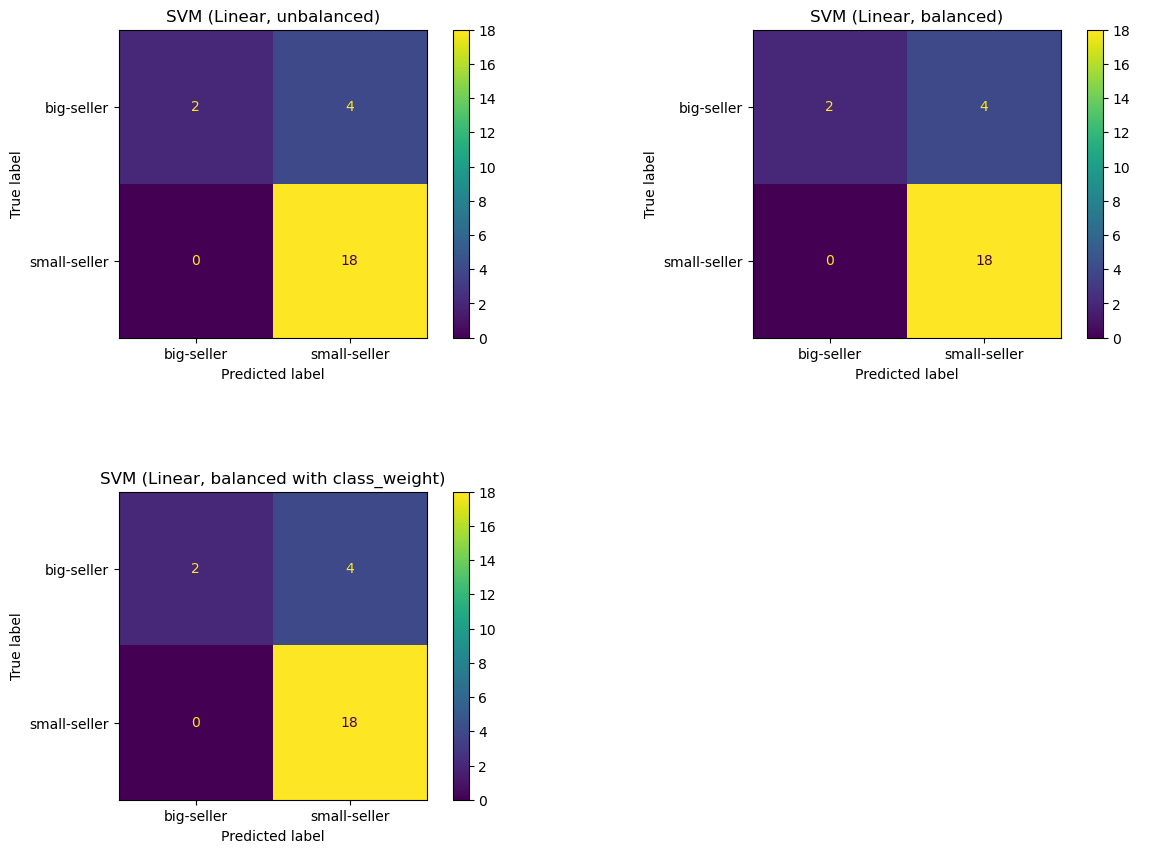

In [253]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

axes[0][0].set_title("SVM (Linear, unbalanced)")
plot_confusion_matrix(svm_lin_unb, test_set, test_label, ax=axes[0][0])
axes[0][1].set_title("SVM (Linear, balanced)")
plot_confusion_matrix(svm_lin_bal, test_set, test_label, ax=axes[0][1])
axes[1][0].set_title("SVM (Linear, balanced with class_weight)")
plot_confusion_matrix(svm_lin_wei, test_set, test_label, ax=axes[1][0])
axes[1][1].axis("off")

plt.show() 

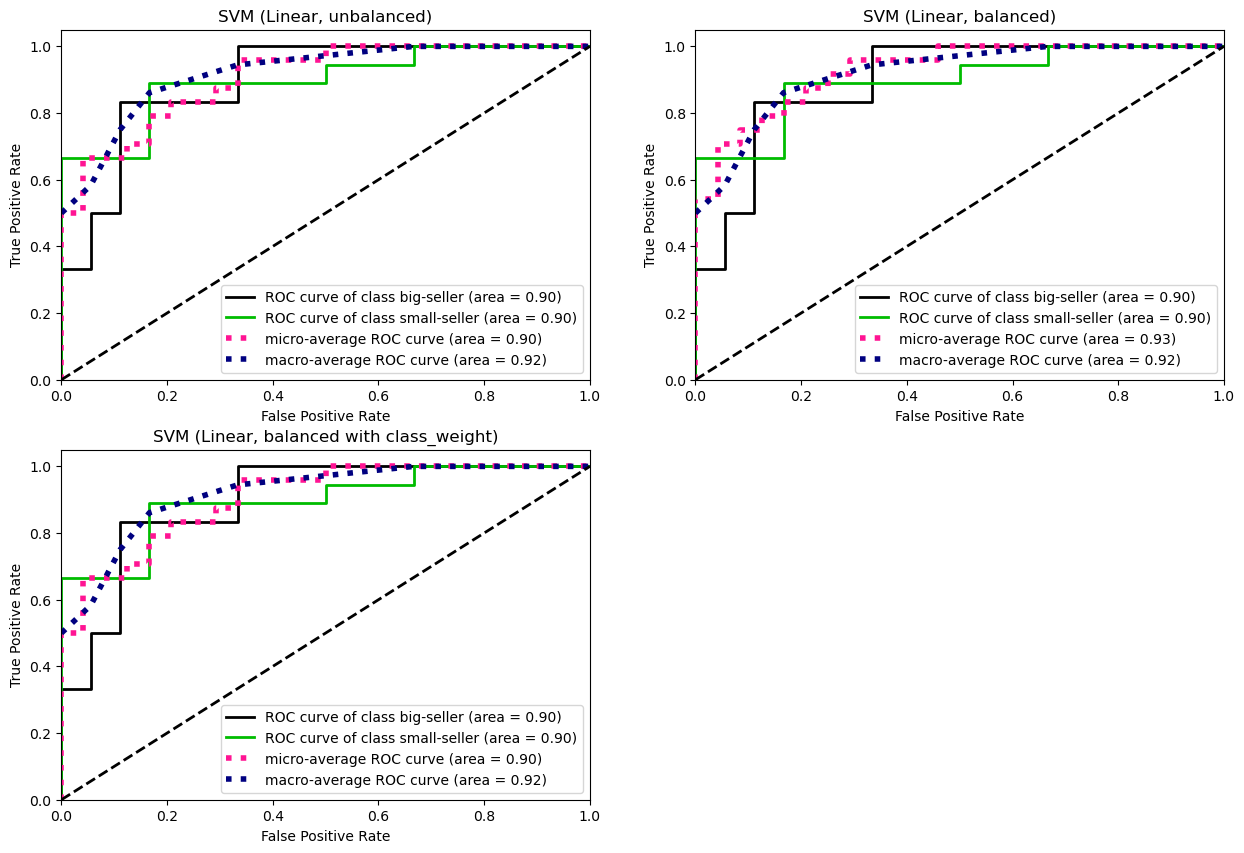

In [254]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

skplt.metrics.plot_roc(test_label.values, test_pred_proba_svm_lin_unb, title="SVM (Linear, unbalanced)", ax=axes[0][0])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_svm_lin_bal, title="SVM (Linear, balanced)", ax=axes[0][1])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_svm_lin_wei, title="SVM (Linear, balanced with class_weight)", ax=axes[1][0])
axes[1][1].axis("off")
plt.show()

The results are identical across models for the linear kernel.

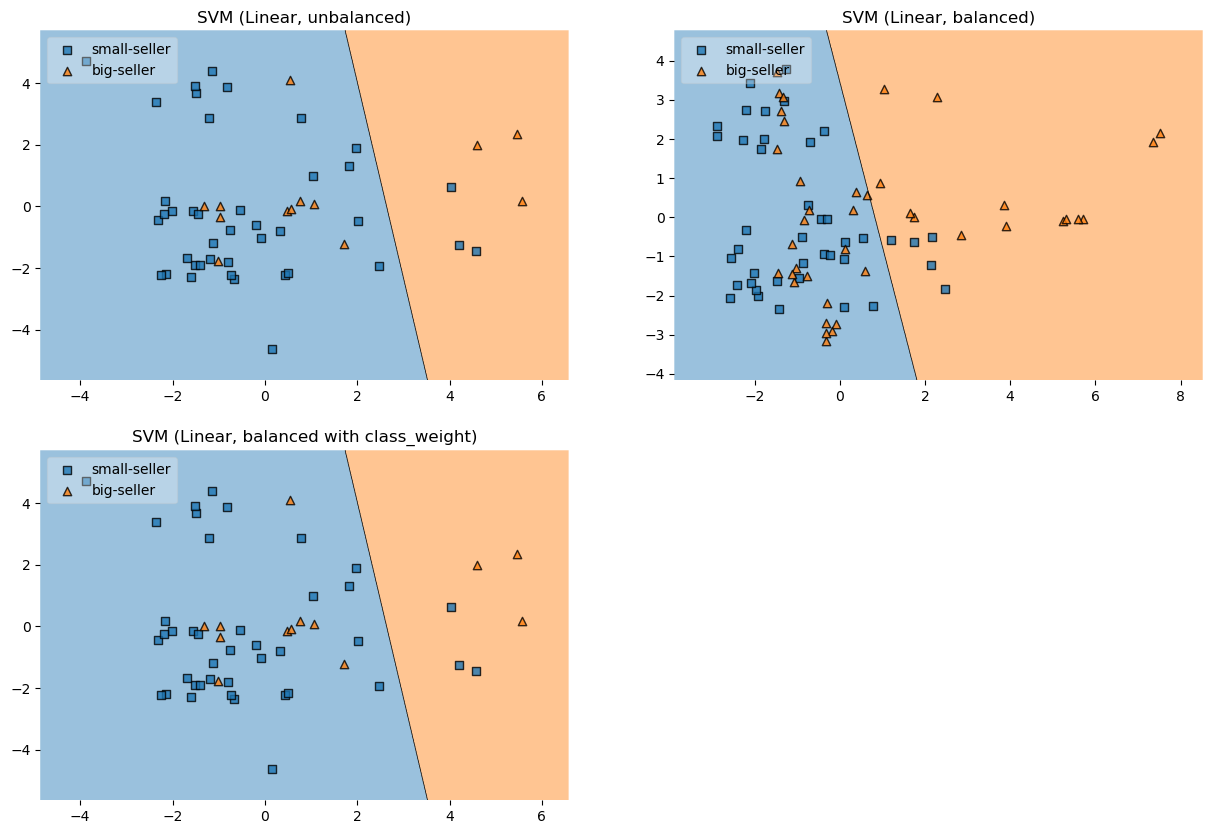

In [255]:
plot_decision_boundary([train_set, train_set_bal, train_set], [train_label, train_label_bal, train_label], \
                       [svm_lin_unb, svm_lin_bal, svm_lin_wei], \
                       ["SVM (Linear, unbalanced)", "SVM (Linear, balanced)", "SVM (Linear, balanced with class_weight)"])

### RBF

#### Unbalanced

In [256]:
#define the parameters' values you want to try
param_dist_svm_rbf = {
    'kernel': ["rbf"],
    'probability': [True],
    'gamma': ["scale"],
    'C': np.linspace(0.01, 1000, 1000)
}

#define the model
clf = SVC()
#define the grid search
grid_search_svm_rbf_unb = RandomizedSearchCV(clf, param_distributions=param_dist_svm_rbf,
                            n_jobs=-1,
                            n_iter=500,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_svm_rbf_unb.fit(train_set, train_label)

print('Best settings parameters ', grid_search_svm_rbf_unb.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_svm_rbf_unb.cv_results_['mean_test_score'][0], 
      grid_search_svm_rbf_unb.cv_results_['std_test_score'][0])


svm_rbf_unb = SVC(**grid_search_svm_rbf_unb.best_params_)
svm_rbf_unb.fit(train_set, train_label)

test_pred_proba_svm_rbf_unb = svm_rbf_unb.predict_proba(test_set)
test_pred_svm_rbf_unb = svm_rbf_unb.predict(test_set)

Best settings parameters  {'probability': True, 'kernel': 'rbf', 'gamma': 'scale', 'C': 689.6927927927928}
Setting's accuracy score mean and std  0.7963636363636365 0.06744449814905965


#### Balanced

In [257]:
#define the parameters' values you want to try
param_dist_svm_rbf = {
    'kernel': ["rbf"],
    'probability': [True],
    'gamma': ["scale"],
    'C': np.linspace(0.01, 1000, 1000)
}

#define the model
clf = SVC()
#define the grid search
grid_search_svm_rbf_bal = RandomizedSearchCV(clf, param_distributions=param_dist_svm_rbf,
                            n_jobs=-1,
                            n_iter=500,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_svm_rbf_bal.fit(train_set_bal, train_label_bal)

print('Best settings parameters ', grid_search_svm_rbf_bal.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_svm_rbf_bal.cv_results_['mean_test_score'][0], 
      grid_search_svm_rbf_bal.cv_results_['std_test_score'][0])


svm_rbf_bal = SVC(**grid_search_svm_rbf_bal.best_params_)
svm_rbf_bal.fit(train_set_bal, train_label_bal)

test_pred_proba_svm_rbf_bal = svm_rbf_bal.predict_proba(test_set)
test_pred_svm_rbf_bal = svm_rbf_bal.predict(test_set)

Best settings parameters  {'probability': True, 'kernel': 'rbf', 'gamma': 'scale', 'C': 250.25774774774777}
Setting's accuracy score mean and std  0.9147058823529411 0.06033893599684897


#### Balanced with class_weight

In [258]:
#define the parameters' values you want to try
param_dist_svm_rbf = {
    'kernel': ["rbf"],
    'probability': [True],
    'gamma': ["scale"],
    'C': np.linspace(0.01, 1000, 1000), 
    "class_weight": ["balanced"]
}

#define the model
clf = SVC()
#define the grid search
grid_search_svm_rbf_wei = RandomizedSearchCV(clf, param_distributions=param_dist_svm_rbf,
                            n_jobs=-1,
                            n_iter=500,
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search_svm_rbf_wei.fit(train_set, train_label)

print('Best settings parameters ', grid_search_svm_rbf_wei.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_svm_rbf_wei.cv_results_['mean_test_score'][0], 
      grid_search_svm_rbf_wei.cv_results_['std_test_score'][0])


svm_rbf_wei = SVC(**grid_search_svm_rbf_wei.best_params_)
svm_rbf_wei.fit(train_set, train_label)

test_pred_proba_svm_rbf_wei = svm_rbf_wei.predict_proba(test_set)
test_pred_svm_rbf_wei = svm_rbf_wei.predict(test_set)

Best settings parameters  {'probability': True, 'kernel': 'rbf', 'gamma': 'scale', 'class_weight': 'balanced', 'C': 447.452972972973}
Setting's accuracy score mean and std  0.7963636363636365 0.06744449814905965


In [259]:
print("SVM (RBF, unbalanced)")
report_scores(test_label, test_pred_svm_rbf_unb)
print("\n")
print("SVM (RBF, balanced)")
report_scores(test_label, test_pred_svm_rbf_bal)
print("\n")
print("SVM (RBF, balanced with class_weight)")
report_scores(test_label, test_pred_svm_rbf_wei)

SVM (RBF, unbalanced)
              precision    recall  f1-score   support

  big-seller       1.00      0.67      0.80         6
small-seller       0.90      1.00      0.95        18

    accuracy                           0.92        24
   macro avg       0.95      0.83      0.87        24
weighted avg       0.92      0.92      0.91        24



SVM (RBF, balanced)
              precision    recall  f1-score   support

  big-seller       0.80      0.67      0.73         6
small-seller       0.89      0.94      0.92        18

    accuracy                           0.88        24
   macro avg       0.85      0.81      0.82        24
weighted avg       0.87      0.88      0.87        24



SVM (RBF, balanced with class_weight)
              precision    recall  f1-score   support

  big-seller       1.00      0.67      0.80         6
small-seller       0.90      1.00      0.95        18

    accuracy                           0.92        24
   macro avg       0.95      0.83      0.87 

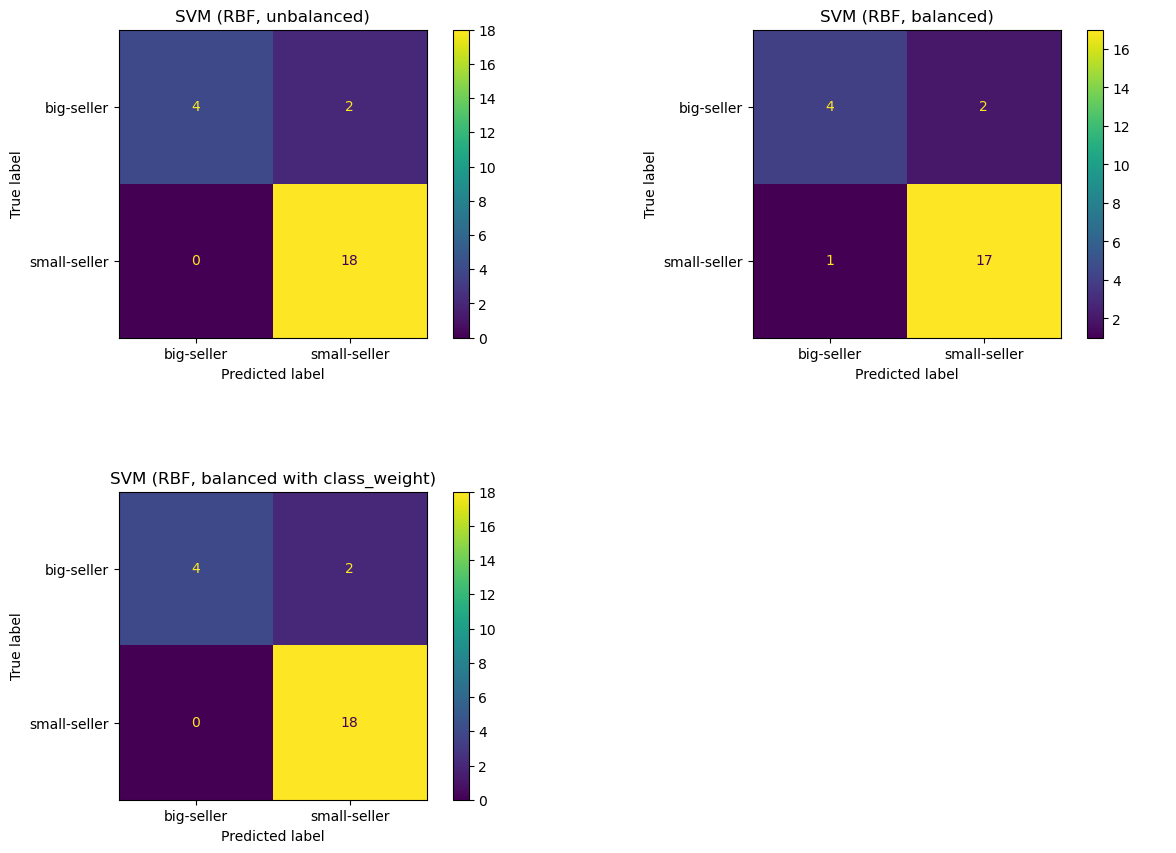

In [260]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

axes[0][0].set_title("SVM (RBF, unbalanced)")
plot_confusion_matrix(svm_rbf_unb, test_set, test_label, ax=axes[0][0])
axes[0][1].set_title("SVM (RBF, balanced)")
plot_confusion_matrix(svm_rbf_bal, test_set, test_label, ax=axes[0][1])
axes[1][0].set_title("SVM (RBF, balanced with class_weight)")
plot_confusion_matrix(svm_rbf_wei, test_set, test_label, ax=axes[1][0])
axes[1][1].axis("off")

plt.show() 

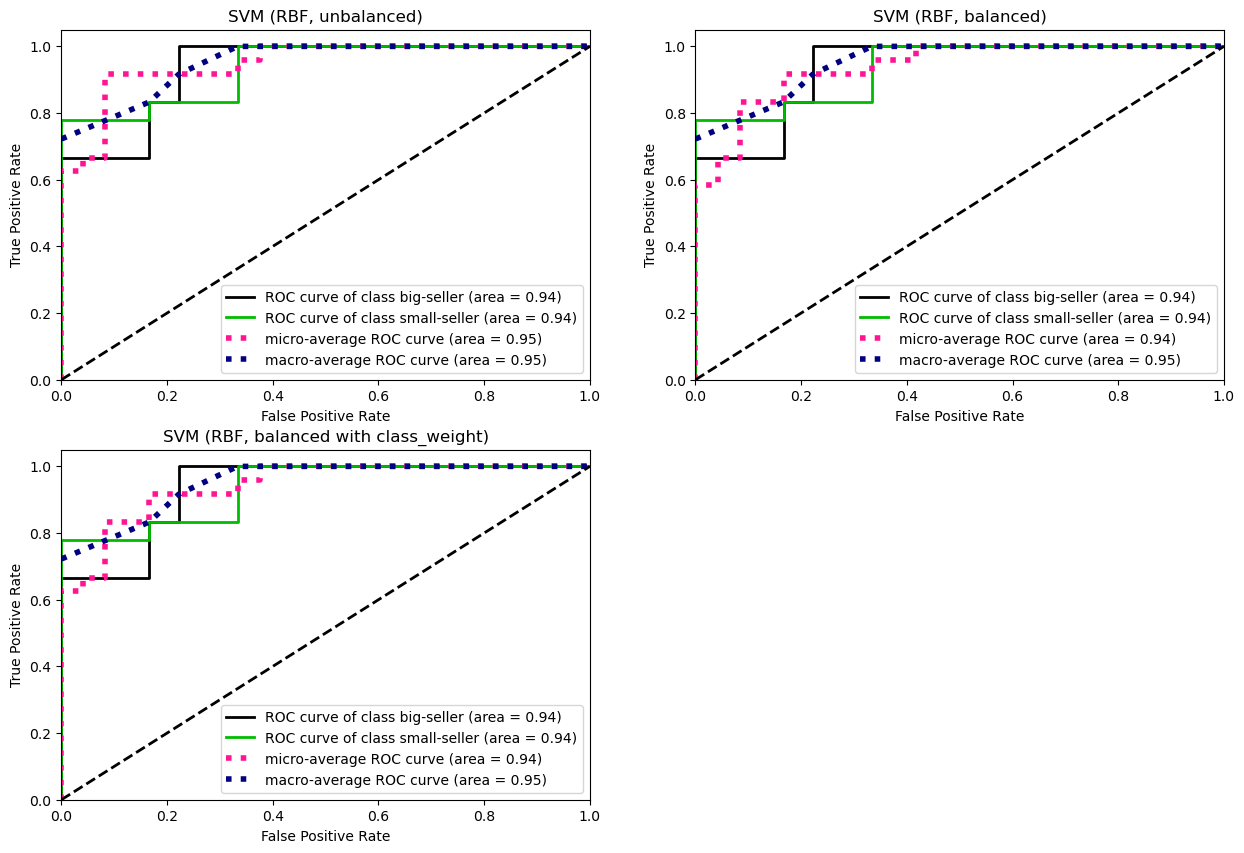

In [261]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

skplt.metrics.plot_roc(test_label.values, test_pred_proba_svm_rbf_unb, title="SVM (RBF, unbalanced)", ax=axes[0][0])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_svm_rbf_bal, title="SVM (RBF, balanced)", ax=axes[0][1])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_svm_rbf_wei, title="SVM (RBF, balanced with class_weight)", ax=axes[1][0])
axes[1][1].axis("off")
plt.show()

The first and third model are identical, while the model trained on the balanced dataset shows slightly lower metrics.

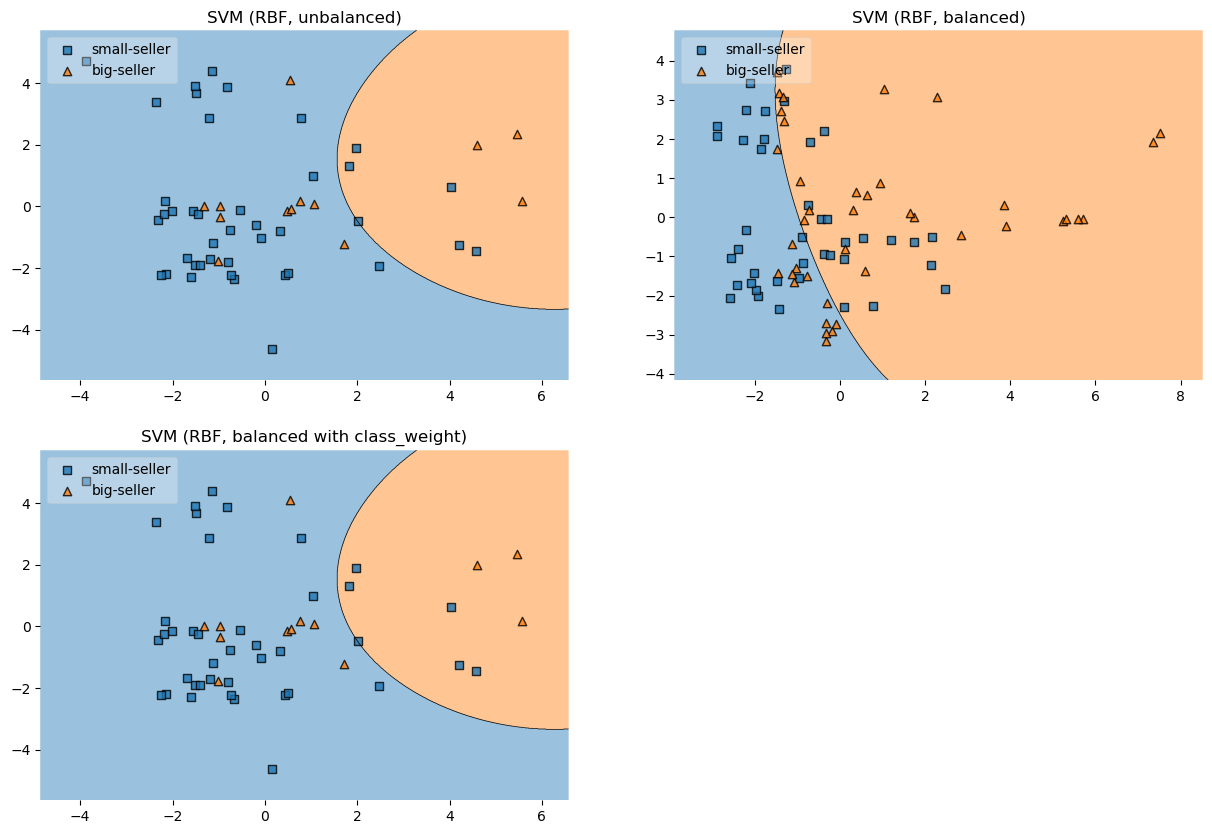

In [262]:
plot_decision_boundary([train_set, train_set_bal, train_set], [train_label, train_label_bal, train_label], \
                       [svm_rbf_unb, svm_rbf_bal, svm_rbf_wei], \
                       ["SVM (RBF, unbalanced)", "SVM (RBF, balanced)", "SVM (RBF, balanced with class_weight)"])

### Kernel comparison

In [263]:
print("SVM (Linear, balanced)")
report_scores(test_label, test_pred_svm_lin_bal)
print("\n")
print("SVM (RBF, balanced with class_weight)")
report_scores(test_label, test_pred_svm_rbf_wei)

SVM (Linear, balanced)
              precision    recall  f1-score   support

  big-seller       1.00      0.33      0.50         6
small-seller       0.82      1.00      0.90        18

    accuracy                           0.83        24
   macro avg       0.91      0.67      0.70        24
weighted avg       0.86      0.83      0.80        24



SVM (RBF, balanced with class_weight)
              precision    recall  f1-score   support

  big-seller       1.00      0.67      0.80         6
small-seller       0.90      1.00      0.95        18

    accuracy                           0.92        24
   macro avg       0.95      0.83      0.87        24
weighted avg       0.92      0.92      0.91        24



The RBF kernel offers better performance in every metric compared to the linear one.

## Multi-layer Perceptron  

### Unbalanced classes

In [273]:
param_dist_mlp = {
    'solver': ["sgd", "adam", "lbfgs"],
    'alpha': [0.0001, 0.001],
    'learning_rate': ["constant", "invscaling", "adaptive"],
    'hidden_layer_sizes': [(x,) for x in range(5, 40, 5)],
    'early_stopping': [True, False]
}

clf = MLPClassifier()
grid_search_mlp_unb = GridSearchCV(clf, param_grid=param_dist_mlp,
                            n_jobs=4,
                            scoring=make_scorer(accuracy_score))

grid_search_mlp_unb.fit(train_set, train_label)

print('Best settings parameters ', grid_search_mlp_unb.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_mlp_unb.cv_results_['mean_test_score'][0], 
      grid_search_mlp_unb.cv_results_['std_test_score'][0])


mlp_unb = MLPClassifier(**grid_search_mlp_unb.best_params_).fit(train_set, train_label)

test_pred_mlp_unb = mlp_unb.predict(test_set)
test_pred_proba_mlp_unb = mlp_unb.predict_proba(test_set)

Best settings parameters  {'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (5,), 'learning_rate': 'constant', 'solver': 'sgd'}
Setting's accuracy score mean and std  0.4418181818181818 0.19830688297361426


/usr/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/usr/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


We conducted also some testing with more hidden layers, however the cv score worsened.

### Balanced classes

In [272]:
param_dist_mlp = {
    'solver': ["sgd", "adam", "lbfgs"],
    'alpha': [0.0001, 0.001],
    'learning_rate': ["constant", "invscaling", "adaptive"],
    'hidden_layer_sizes': [(x,) for x in range(5, 40, 5)],
    'early_stopping': [True, False]
}

clf = MLPClassifier()
grid_search_mlp_bal = GridSearchCV(clf, param_grid=param_dist_mlp,
                            n_jobs=4,
                            scoring=make_scorer(accuracy_score))

grid_search_mlp_bal.fit(train_set_bal, train_label_bal)

print('Best settings parameters ', grid_search_mlp_bal.cv_results_['params'][0])
print("Setting's accuracy score mean and std ", grid_search_mlp_bal.cv_results_['mean_test_score'][0], 
      grid_search_mlp_bal.cv_results_['std_test_score'][0])


mlp_bal = MLPClassifier(**grid_search_mlp_bal.best_params_).fit(train_set_bal, train_label_bal)

test_pred_mlp_bal = mlp_bal.predict(test_set)
test_pred_proba_mlp_bal = mlp_bal.predict_proba(test_set)

Best settings parameters  {'alpha': 0.0001, 'early_stopping': True, 'hidden_layer_sizes': (5,), 'learning_rate': 'constant', 'solver': 'sgd'}
Setting's accuracy score mean and std  0.48382352941176465 0.1492592725756996


### Evaluation

In [274]:
print("MLP (unbalanced)")
report_scores(test_label, test_pred_mlp_unb)
print("\n")
print("MLP (balanced)")
report_scores(test_label, test_pred_mlp_bal)

MLP (unbalanced)
              precision    recall  f1-score   support

  big-seller       0.43      0.50      0.46         6
small-seller       0.82      0.78      0.80        18

    accuracy                           0.71        24
   macro avg       0.63      0.64      0.63        24
weighted avg       0.72      0.71      0.72        24



MLP (balanced)
              precision    recall  f1-score   support

  big-seller       0.80      0.67      0.73         6
small-seller       0.89      0.94      0.92        18

    accuracy                           0.88        24
   macro avg       0.85      0.81      0.82        24
weighted avg       0.87      0.88      0.87        24



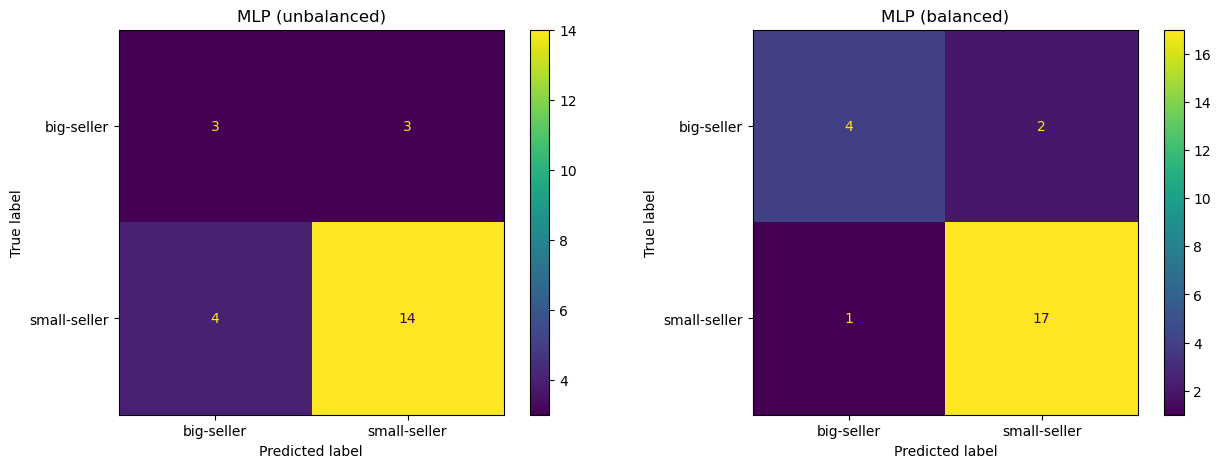

In [275]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

axes[0].set_title("MLP (unbalanced)")
plot_confusion_matrix(mlp_unb, test_set, test_label, ax=axes[0])
axes[1].set_title("MLP (balanced)")
plot_confusion_matrix(mlp_bal, test_set, test_label, ax=axes[1])
plt.show() 

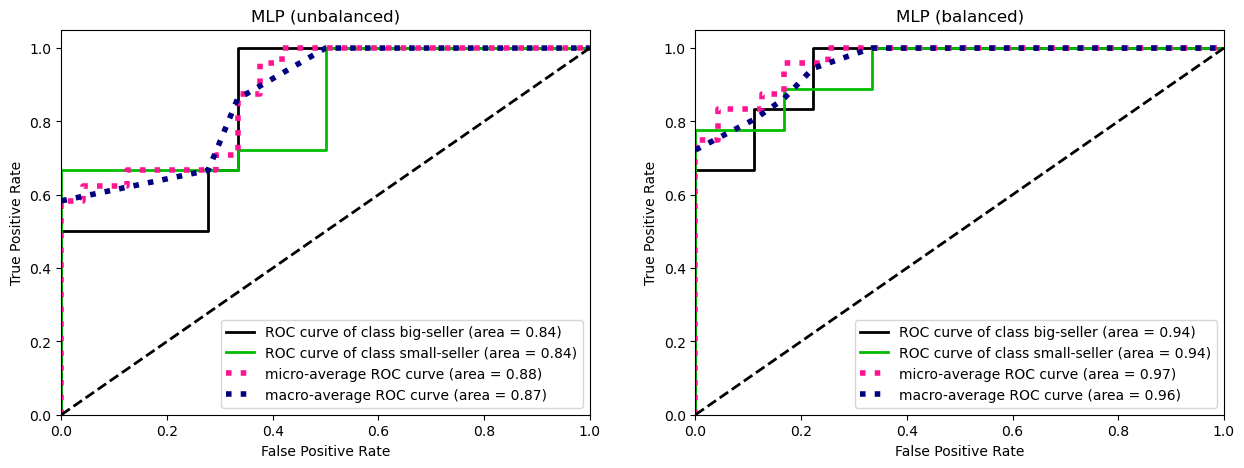

In [276]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
fig.subplots_adjust(hspace=0.2, wspace=0.2)

skplt.metrics.plot_roc(test_label.values, test_pred_proba_mlp_unb, title="MLP (unbalanced)", ax=axes[0])
skplt.metrics.plot_roc(test_label.values, test_pred_proba_mlp_bal, title="MLP (balanced)", ax=axes[1])
plt.show()

The results for the balanced dataset are quite good, even compared to the best models previously analysed.  

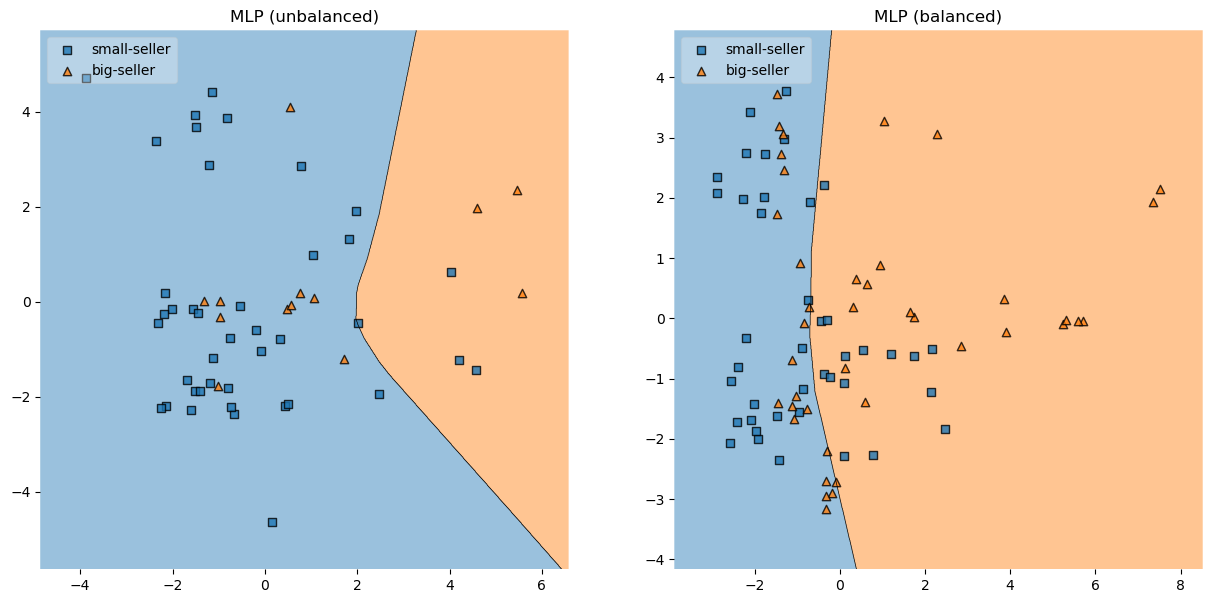

In [278]:
plot_decision_boundary([train_set, train_set_bal], [train_label, train_label_bal], \
                       [mlp_unb, mlp_bal], ["MLP (unbalanced)", "MLP (balanced)"])

## Results recap
Following are the best results from each classifier.

In [292]:
result_dict = {"Logistic regression (unbalanced)":test_pred_log_unb, 
               "DT (balanced with class_weight, pruned)":test_pred_dt_wei_post,
               "Naive Bayes (unbalanced)":test_pred_nb_unb, 
               "KNN (unbalanced)":test_pred_knn_unb,
               "Ripper (balanced)":test_pred_rip_bal, 
               "RF (balanced)":test_pred_rf_bal, 
               "SVM (RBF, balanced with class_weight)":test_pred_svm_rbf_wei, 
               "MLP (balanced)":test_pred_mlp_bal}

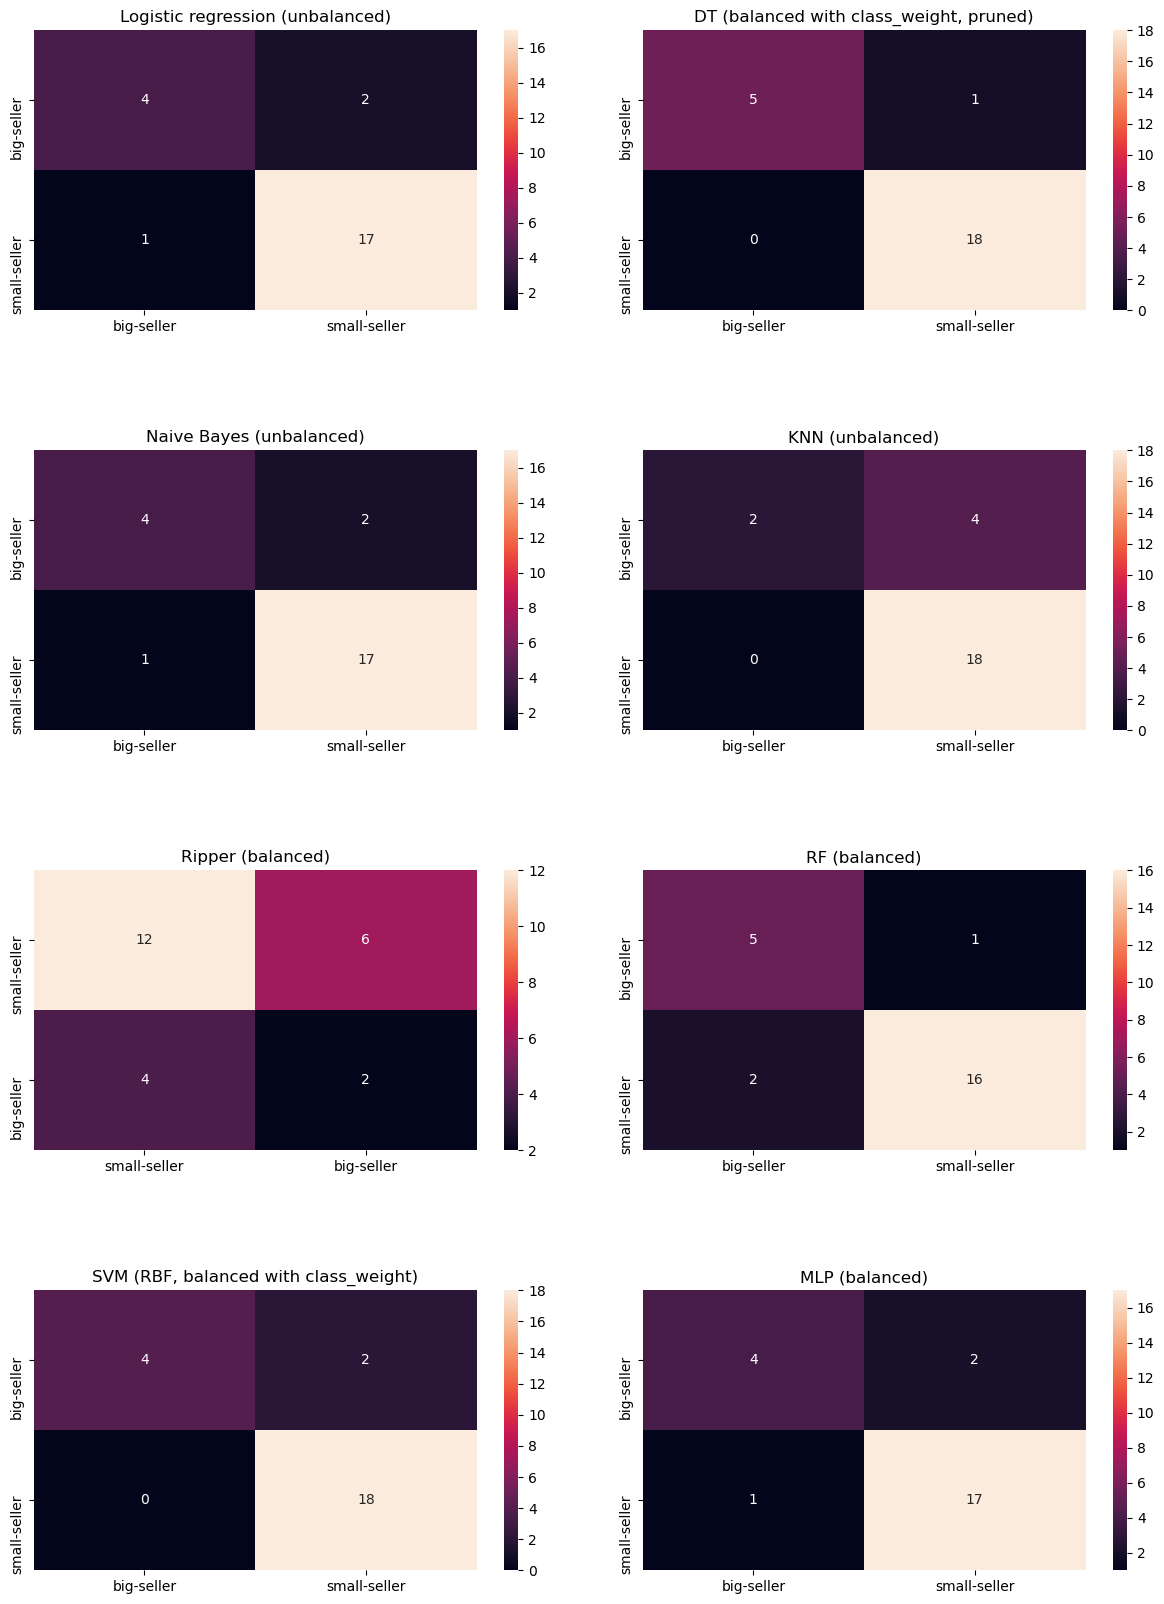

In [305]:
n_models = len(result_dict)
fig, axes = plt.subplots(nrows=(n_models+1)//2, ncols=2, figsize=(15, 5*(n_models//2)))
fig.subplots_adjust(hspace=0.5, wspace=0.1)

pos = 0
for k,v in result_dict.items():
    
    row_id = pos//2
    col_id = pos%2
    
    cur_title = k
    cur_result = v
    
    axes[row_id][col_id].set_title(cur_title)
    
    if cur_title != "Ripper (balanced)":
        sn.heatmap(confusion_matrix(test_label, cur_result), annot=True, \
               xticklabels=["big-seller", "small-seller"], yticklabels=["big-seller", "small-seller"], ax=axes[row_id][col_id])
    else:
        sn.heatmap(confusion_matrix(test_label_rip, cur_result[0]), annot=True, \
               xticklabels=["small-seller", "big-seller"], yticklabels=["small-seller", "big-seller"], ax=axes[row_id][col_id])
    
    pos += 1
    
    if pos == n_models and n_models%2 == 1:
        axes[pos//2][pos%2].axis("off")

plt.show() 

### Conclusions
All the models, except for ripper, performed quite well with a nearly perfect score reached by the DT.  
None of the classifiers tested managed to get a perfect score on the minority class (big-seller).

### Global explanations

#### Variable importance

In [ ]:
mp_rf = exp_rf.model_parts()
mp_rf.plot()

In [ ]:
mp_svm = exp_svm.model_parts()
mp_svm.plot()

In [ ]:
mp_mlp = exp_mlp.model_parts()
mp_mlp.plot()

#### Partial dependence profile

In [ ]:
rf_mprofile_group = exp_rf.model_profile(variables=["MaxValuePerOrder", "AvgValuePerOrder", "AvgMemoryPerOrder", "TotMonthBusiness", "Eram"], 
                                         type = "partial")
rf_mprofile_group.plot()

In [ ]:
svm_mprofile_group = exp_svm.model_profile(variables=["AvgValuePerOrder", "AvgMemoryPerOrder", "TotMonthBusiness", "Eram"], \
                                           type = "partial")
svm_mprofile_group.plot()

In [ ]:
mlp_mprofile_group = exp_mlp.model_profile(variables=["MaxValuePerOrder", "AvgMemoryPerOrder", "TotMonthBusiness", "Eram", \
                                                     "TopSalesMonth"], type = "partial")
mlp_mprofile_group.plot()

### Local explanations
In this section we will take a look at the explanations given by the model for the outliers that we inserted at the beginning of the task.

In [ ]:
outlier_obs = pred_df[pred_df.index.isin(outlier_df.index)]
outlier_obs

#### LIME

In [ ]:
exp_rf.predict_surrogate(new_observation = outlier_obs.iloc[0]).show_in_notebook()

In [ ]:
exp_svm.predict_surrogate(new_observation = outlier_obs.iloc[0]).show_in_notebook()

In [ ]:
exp_mlp.predict_surrogate(new_observation = outlier_obs.iloc[0]).show_in_notebook()

# TODO
- add dalex xai code
- write conclusions
- check SMOTE algorithm